# ARIMA Model Diagnostics for Inflation Time Series

This notebook conducts a diagnostic analysis of ARIMA models for headline inflation data from the three regions: Switzerland (CH), the Euro Area (EU), and the United States (US).

The primary objectives are to understand the properties of these time series and to assess the stability of model selection over time.

The analysis includes the following steps:
1.  **Data Visualization**: Plotting the inflation series to observe trends and patterns.
2.  **Stationarity Testing**: Applying the Augmented Dickey-Fuller (ADF) test to determine the order of integration.
3.  **Autocorrelation Analysis**: Generating ACF and PACF plots to identify potential AR and MA components.
4.  **Residual Diagnostics**: Fitting a simple AR(1) model and analyzing its residuals for goodness-of-fit.
5.  **Automatic Model Selection**: Using `auto_arima` to find the optimal model order for the entire dataset based on the Bayesian Information Criterion (BIC).
6.  **Model Order Stability**: Performing a rolling-window analysis to see how the optimal ARIMA order changes as new data becomes available.

In [ ]:
# Add the root directory of the repo to sys.path
import sys
from pathlib import Path

# The notebook is in 'notebooks/', so we go up one level to the project root
ROOT_DIR = Path("../").resolve()
sys.path.append(str(ROOT_DIR))

# Setup: imports and dataset loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import norm
from pmdarima import auto_arima
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load datasets from the new 'data/processed' directory
DATA_DIR = ROOT_DIR / "data" / "processed"
datasets = {
    "ch": pd.read_csv(DATA_DIR / "ch_data_final.csv"),
    "eu": pd.read_csv(DATA_DIR / "eu_data_final.csv"),
    "us": pd.read_csv(DATA_DIR / "us_data_final.csv"),
}

# Preprocess to time series format and include additional variables
def preprocess(df, inflation_column, cpi_column):
    dates = pd.to_datetime(df["date"]) + pd.offsets.MonthEnd(0)
    inflation_series = pd.Series(df[inflation_column].values, index=dates).asfreq("ME").dropna()
    cpi_series = pd.Series(df[cpi_column].values, index=dates).asfreq("ME").dropna()
    return inflation_series, cpi_series

# Update series dictionary to include the additional variables
series = {}
cpi_series = {}

for key in datasets:
    if key == "ch":
        inflation_column = "cpi_total_yoy"
        cpi_column = "cpi_total_base_month_december_2020_ind"
    elif key == "eu":
        inflation_column = "hcpi_yoy"
        cpi_column = "hicpov_ea"
    elif key == "us":
        inflation_column = "cpi_all_yoy"
        cpi_column = "cpiaucsl"
    else:
        continue

    series[key], cpi_series[key] = preprocess(datasets[key], inflation_column, cpi_column)

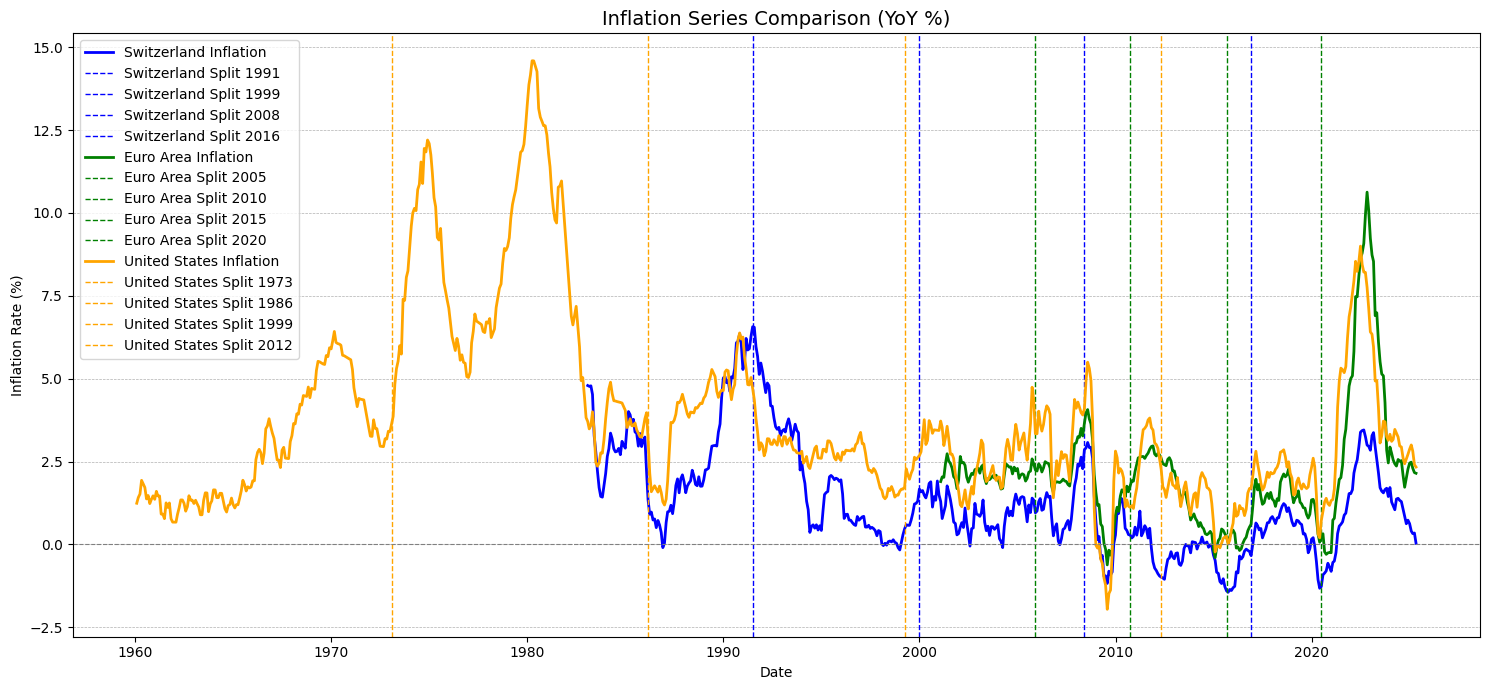

In [5]:
# Calculate the 20%, 40%, 60%, and 80% splits for each series
splits = {}
split_dates = {}
for key in series:
    length = len(series[key])
    splits[key] = [int(length * p) for p in [0.2, 0.4, 0.6, 0.8]]
    split_dates[key] = [series[key].index[split] for split in splits[key]]

# Plot the series
plt.figure(figsize=(15, 7))
colors = {"ch": "blue", "eu": "green", "us": "orange"}
labels = {"ch": "Switzerland", "eu": "Euro Area", "us": "United States"}

for key in series:
    plt.plot(series[key].index, series[key].values, linewidth=2, color=colors[key], label=f'{labels[key]} Inflation')
    for split_date in split_dates[key]:
        plt.axvline(x=split_date, color=colors[key], linestyle='--', linewidth=1, label=f'{labels[key]} Split {split_date.year}')

plt.axhline(0, linestyle='--', color='grey', linewidth=0.8)
plt.title('Inflation Series Comparison (YoY %)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



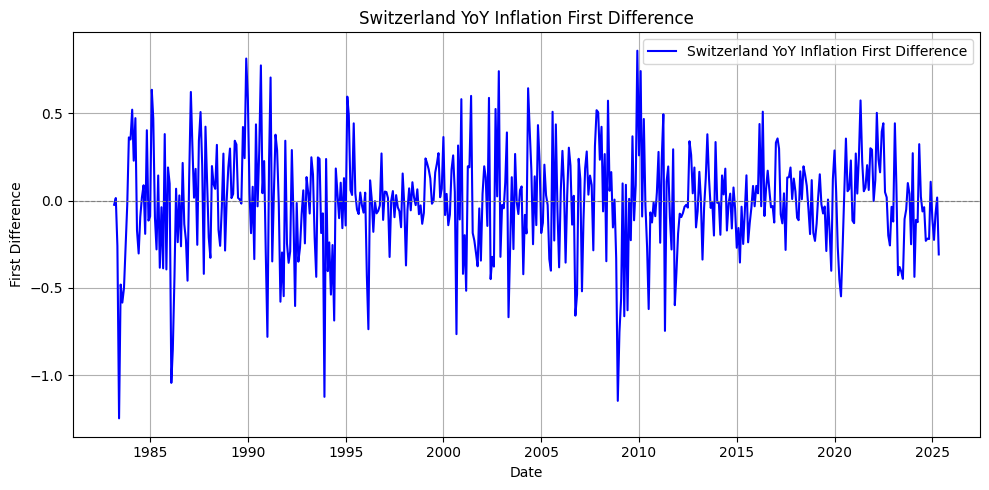

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



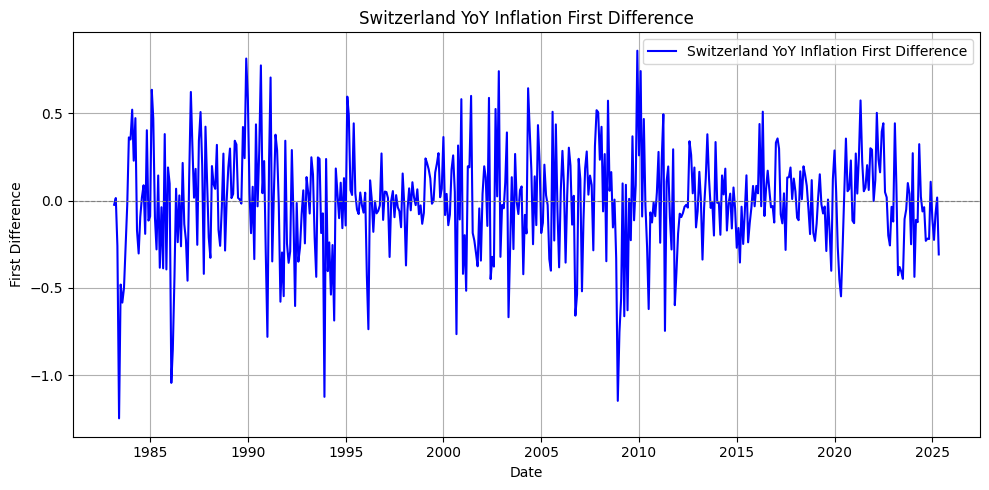

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



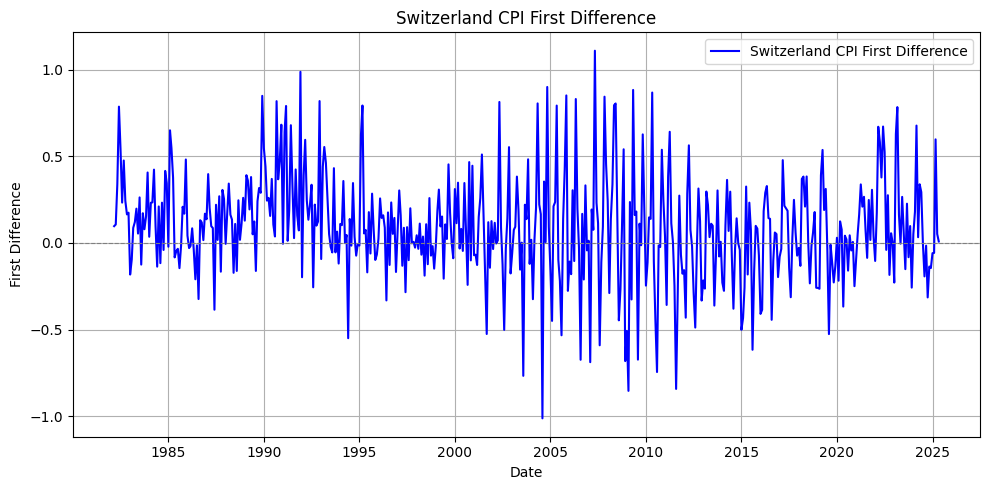

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



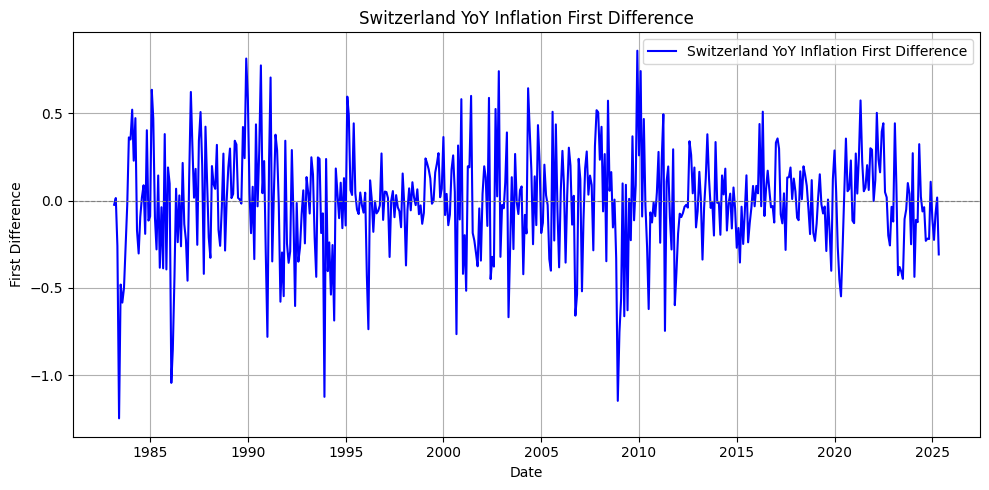

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



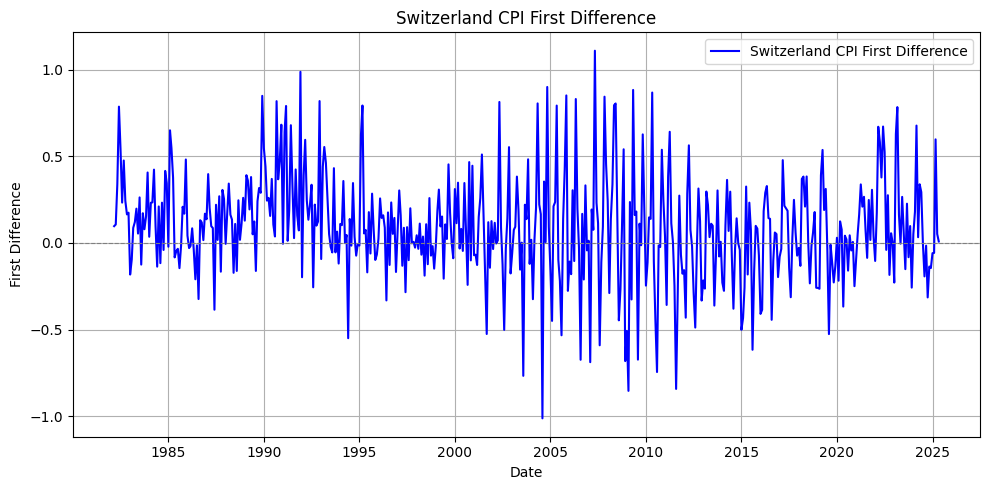

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



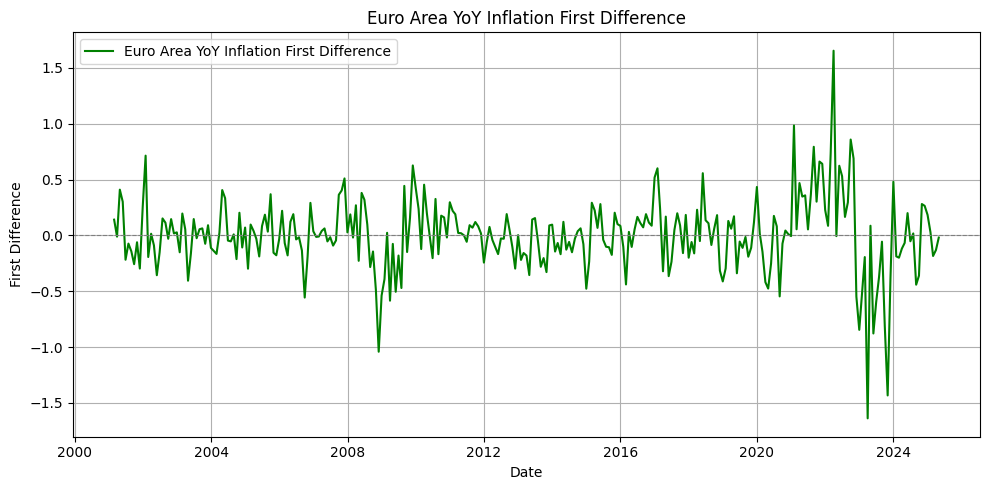

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



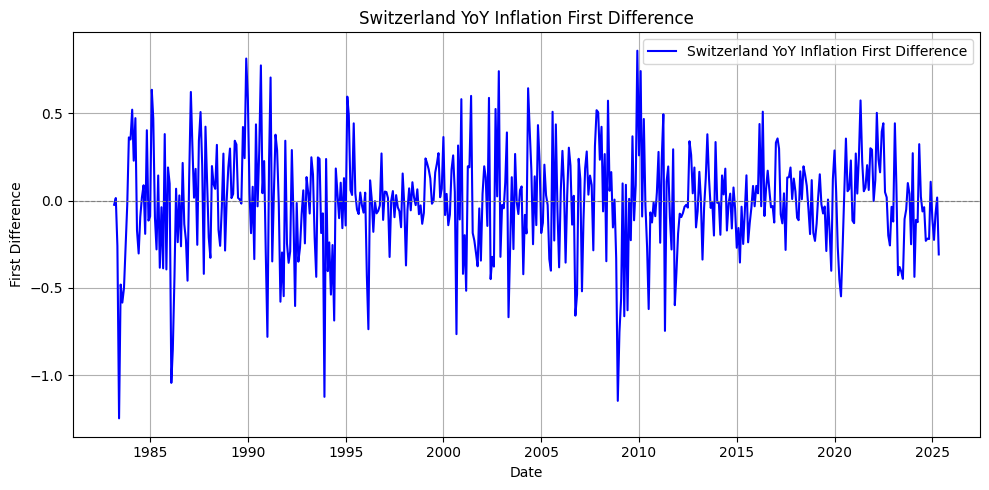

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



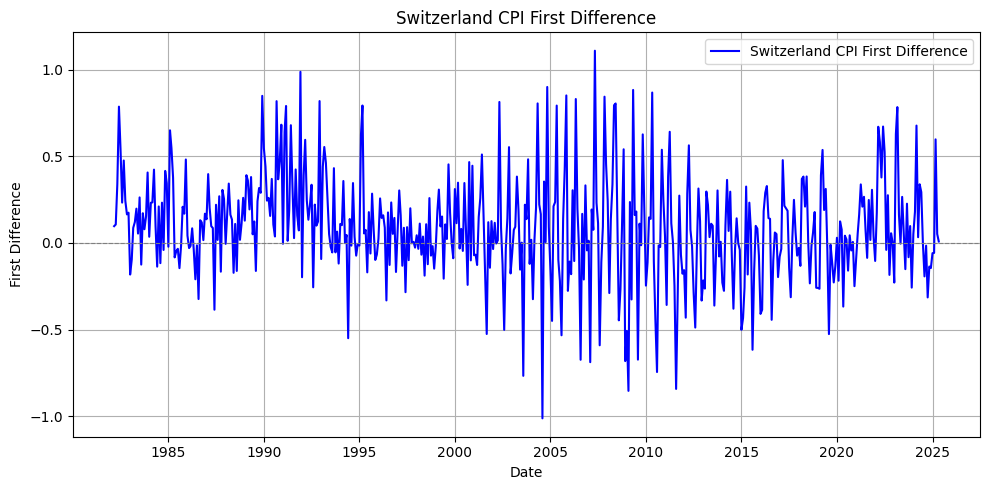

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



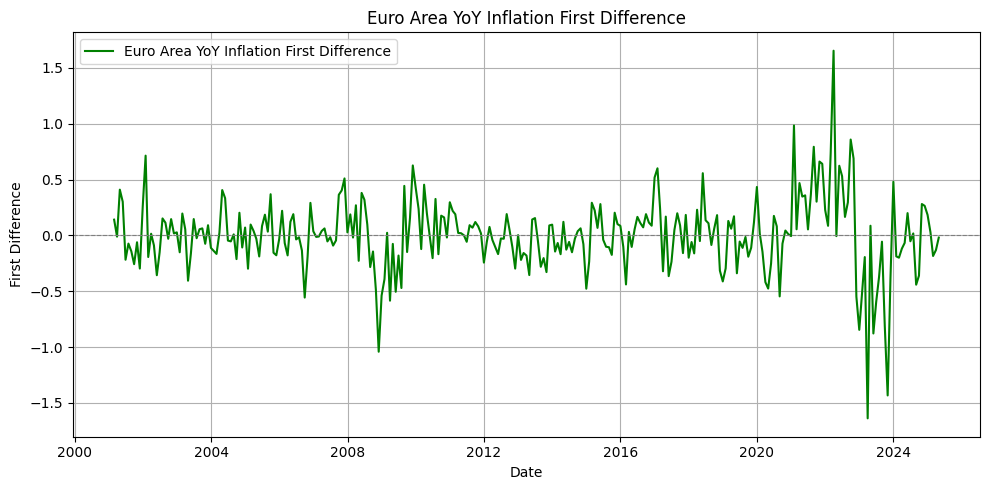

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



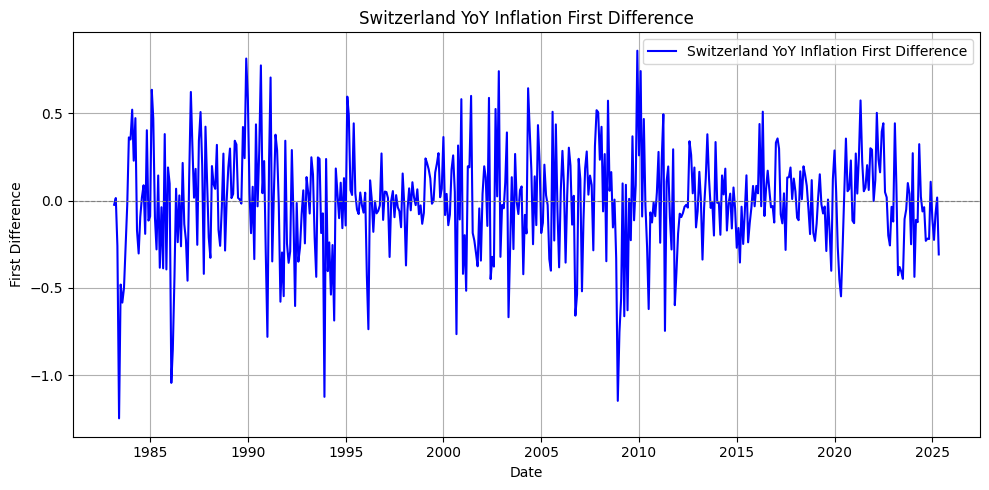

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



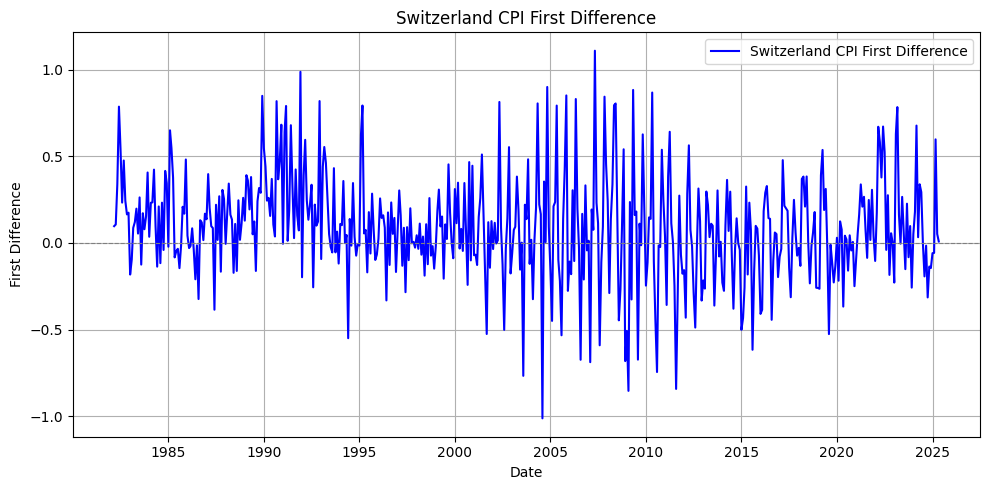

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



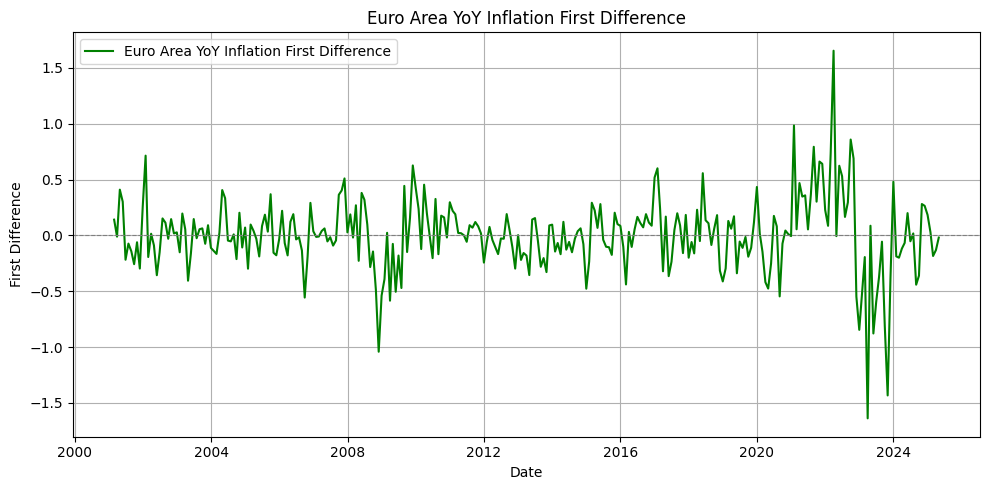

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



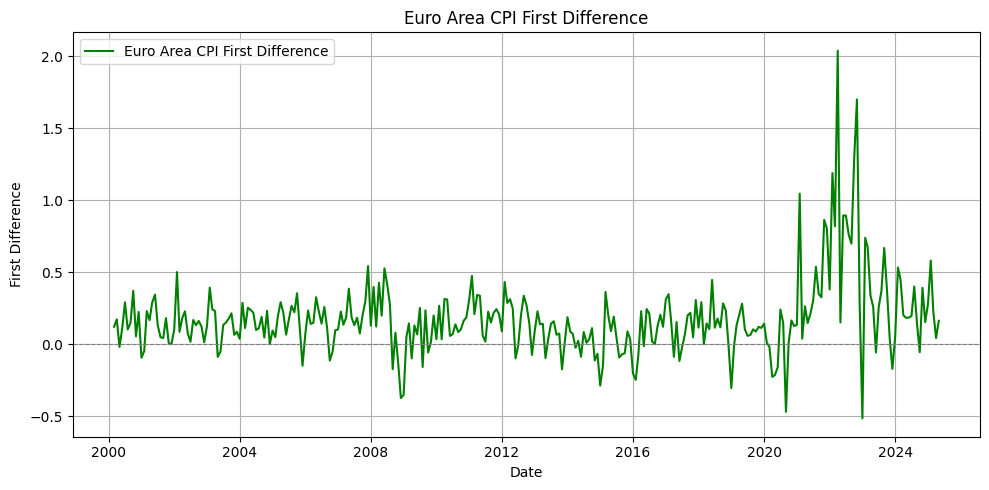

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



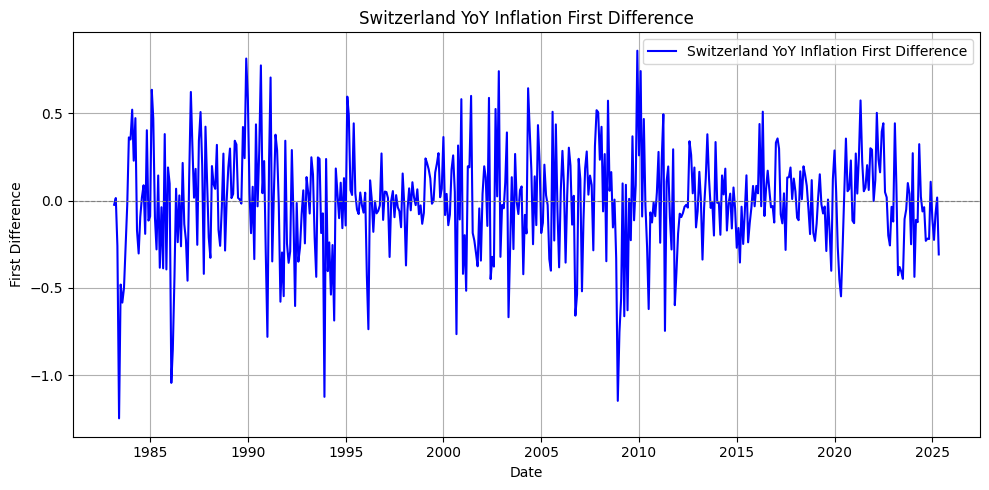

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



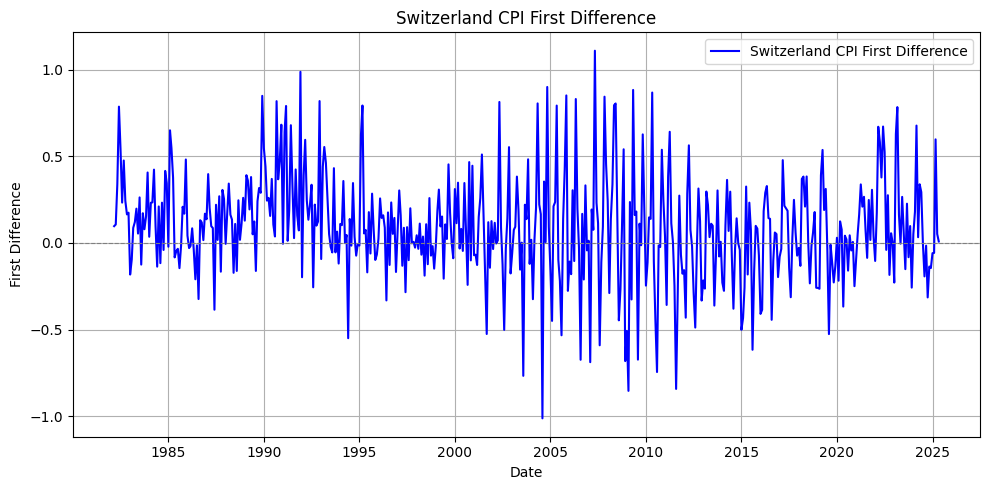

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



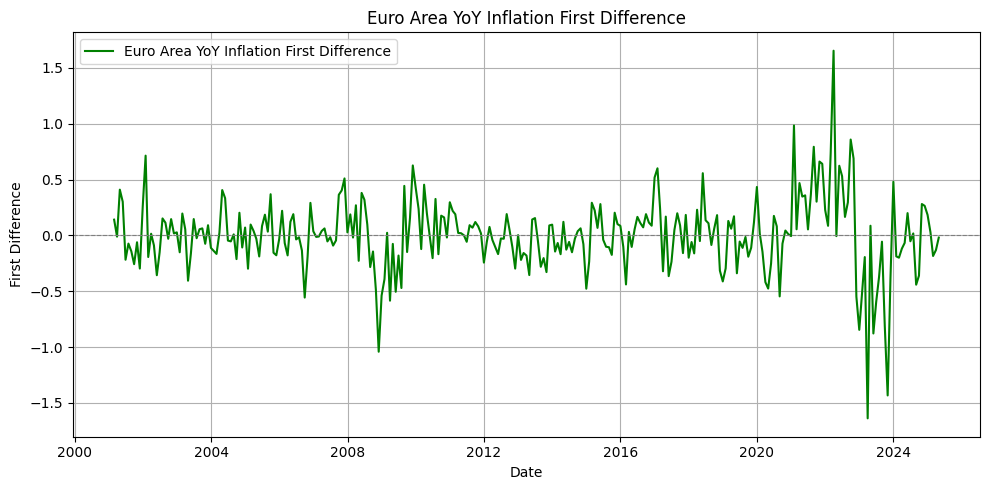

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



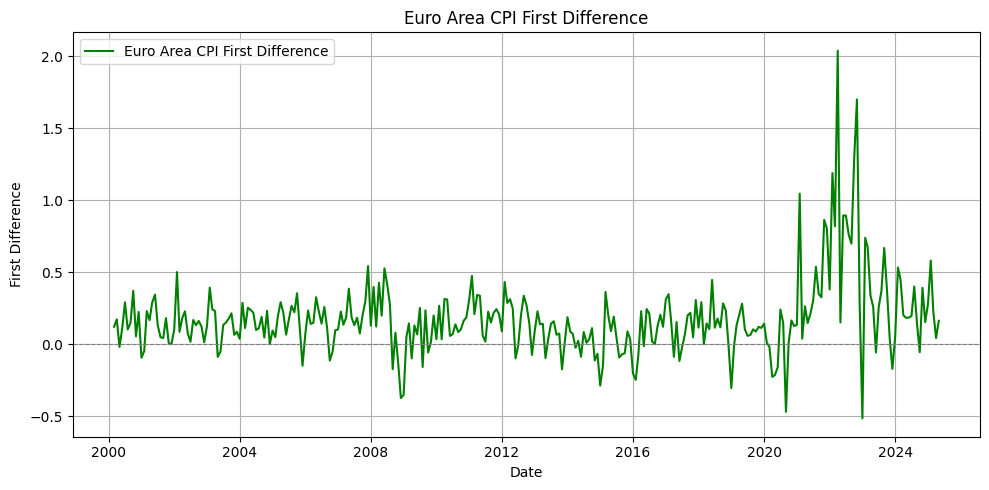

--- ADF Tests for United States YoY Inflation ---
ADF P-value (Original): 0.0166 -> Stationary: Yes
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes

ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



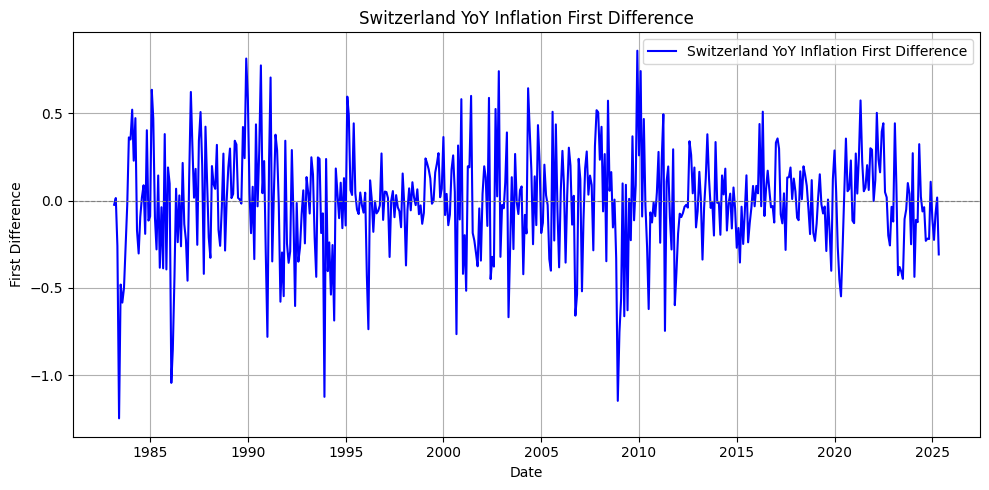

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



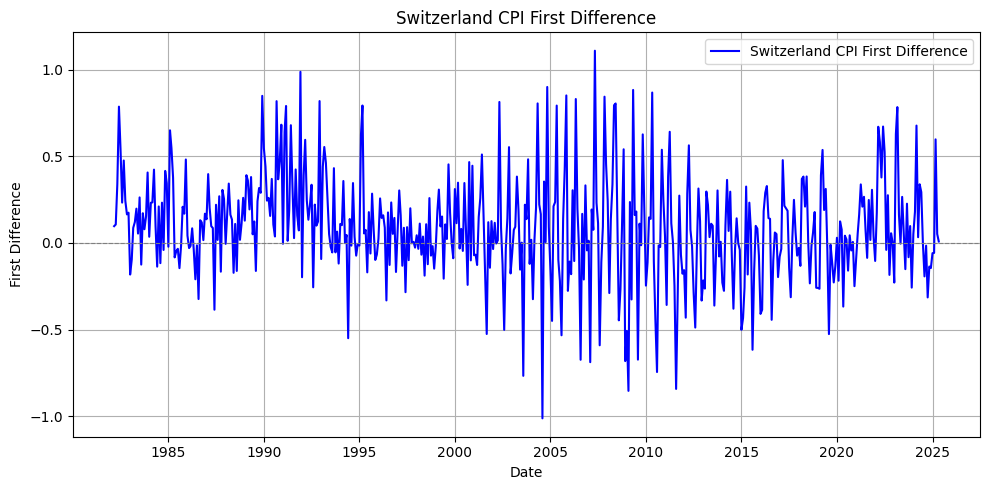

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



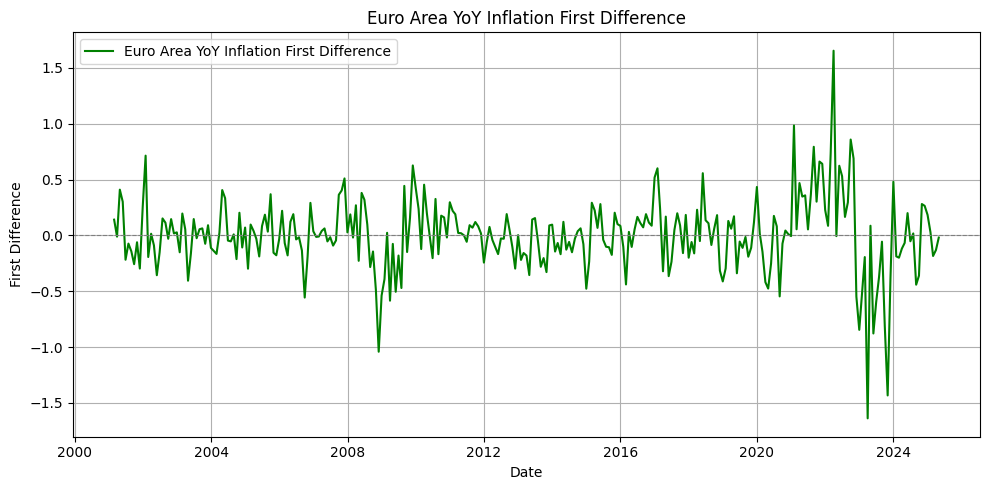

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



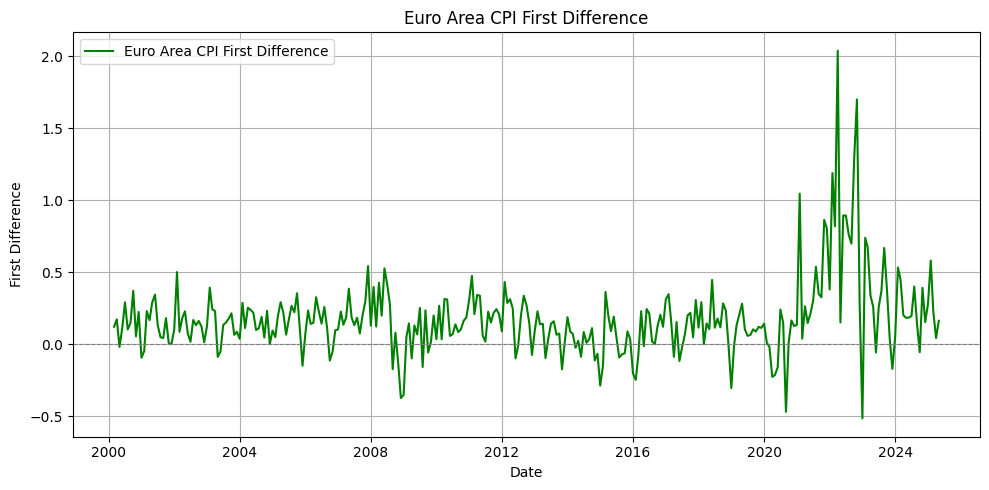

--- ADF Tests for United States YoY Inflation ---
ADF P-value (Original): 0.0166 -> Stationary: Yes
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes

ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



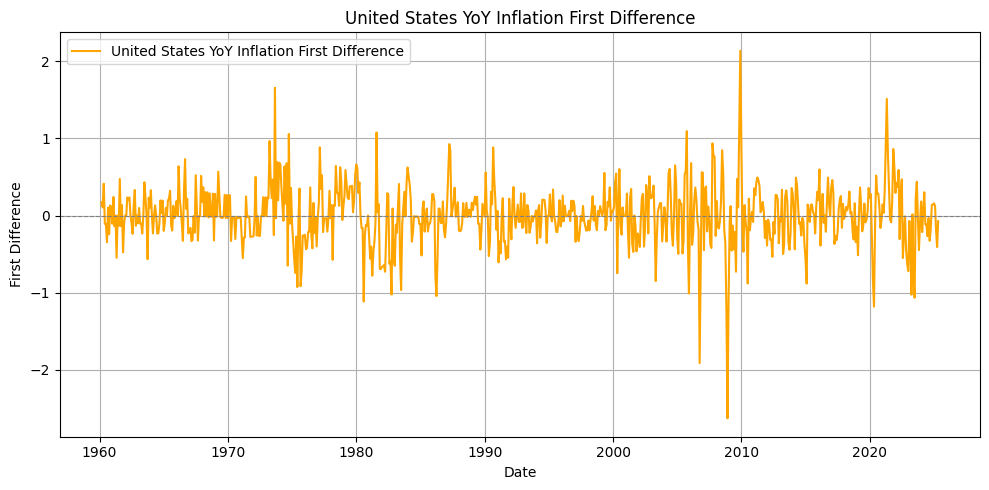

--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



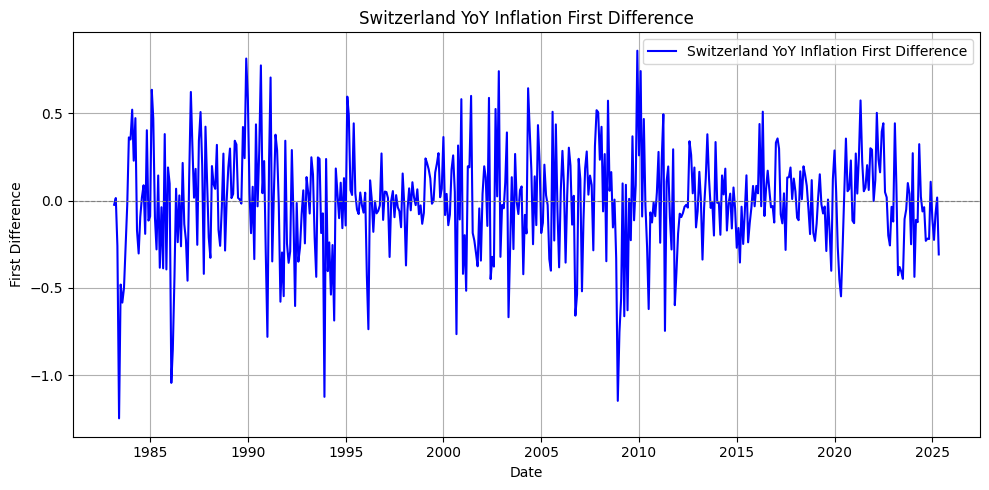

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



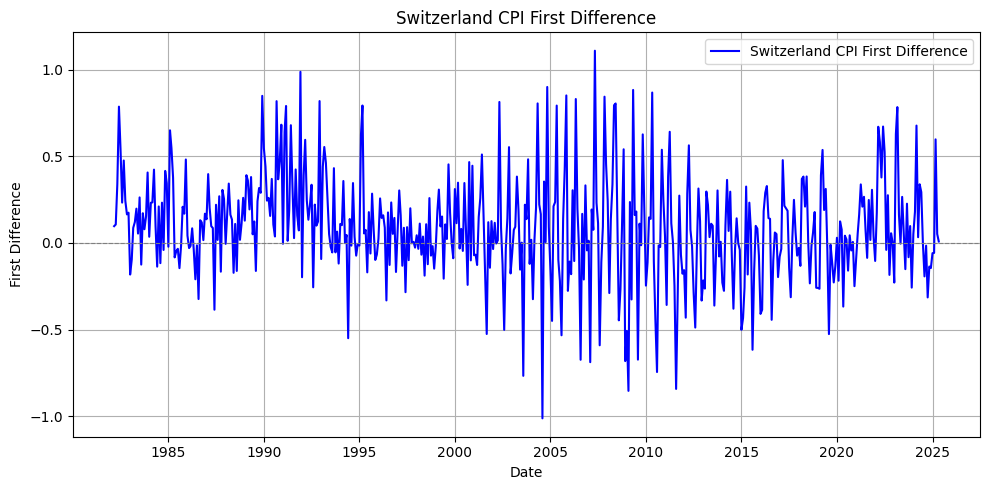

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



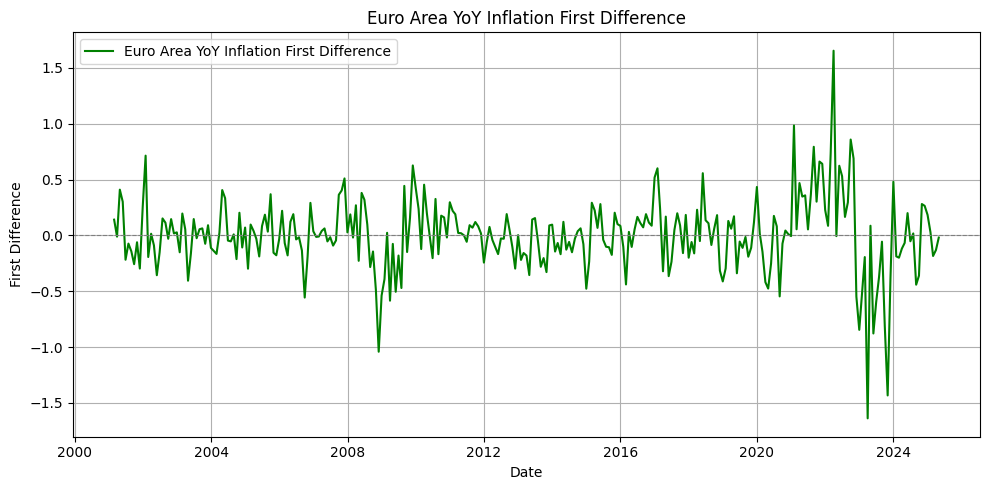

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



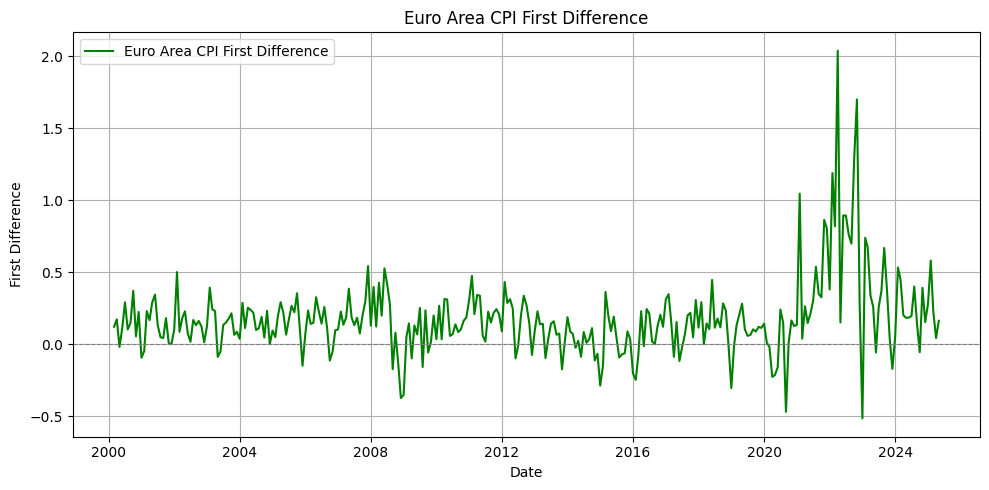

--- ADF Tests for United States YoY Inflation ---
ADF P-value (Original): 0.0166 -> Stationary: Yes
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes

ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



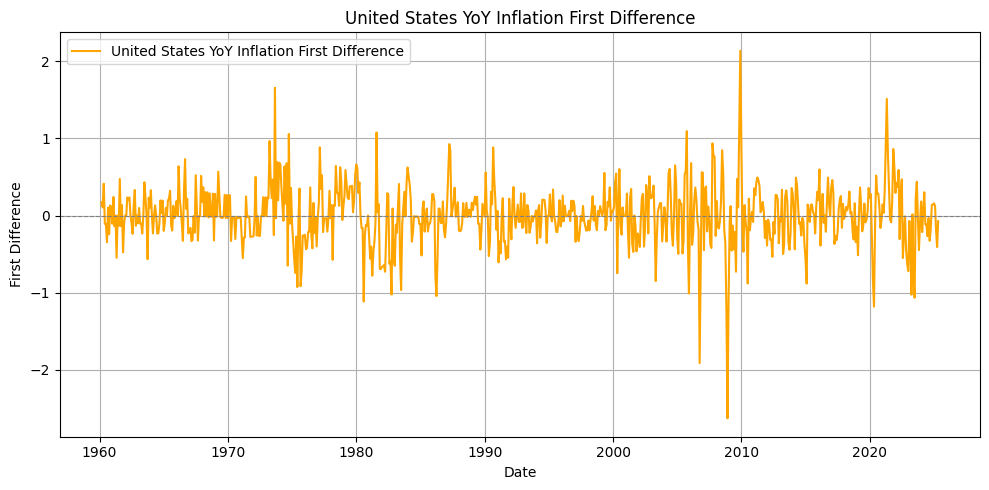

--- ADF Tests for United States CPI ---
ADF P-value (Original): 0.9987 -> Stationary: No
ADF P-value (1st Diff): 0.0031 -> Stationary: Yes

ADF P-value (Original): 0.9987 -> Stationary: No
ADF P-value (1st Diff): 0.0031 -> Stationary: Yes



--- ADF Tests for Switzerland YoY Inflation ---
ADF P-value (Original): 0.1232 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



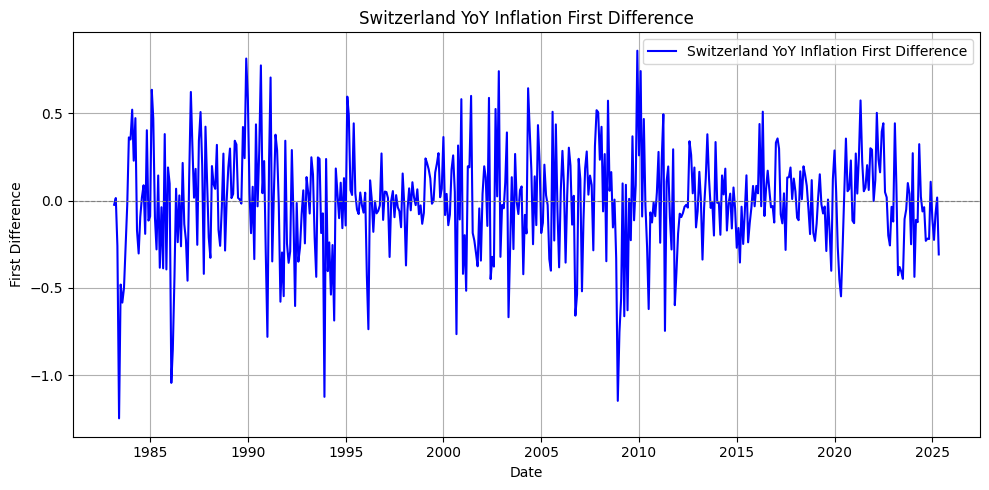

--- ADF Tests for Switzerland CPI ---
ADF P-value (Original): 0.2293 -> Stationary: No
ADF P-value (1st Diff): 0.0205 -> Stationary: Yes



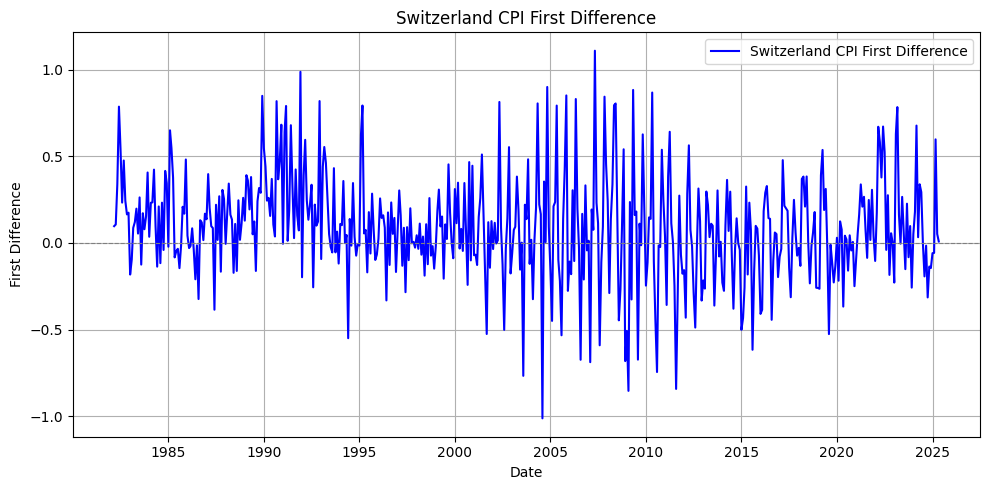

--- ADF Tests for Euro Area YoY Inflation ---
ADF P-value (Original): 0.0883 -> Stationary: No
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



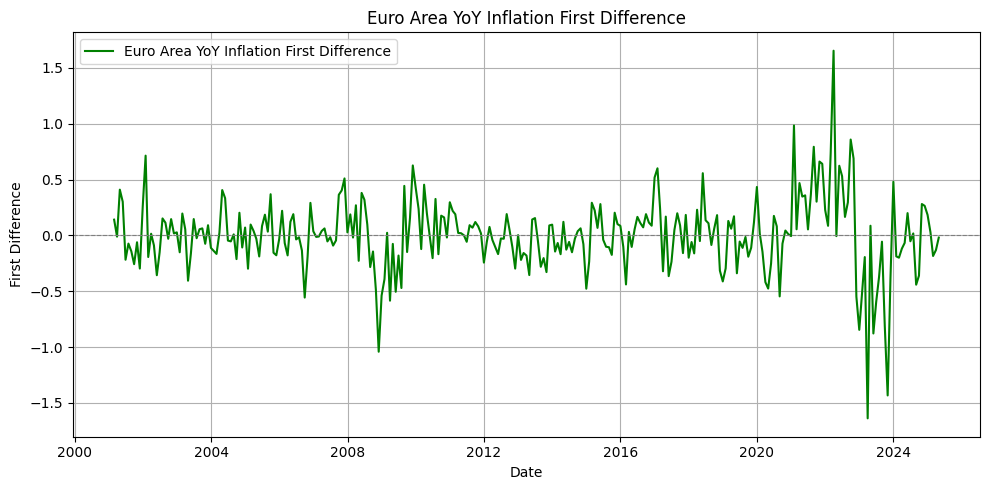

--- ADF Tests for Euro Area CPI ---
ADF P-value (Original): 0.9922 -> Stationary: No
ADF P-value (1st Diff): 0.0185 -> Stationary: Yes



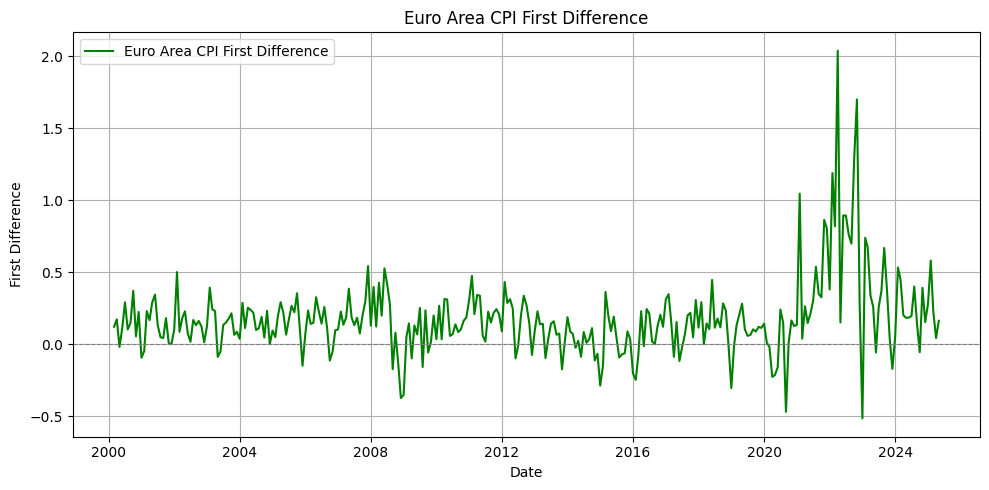

--- ADF Tests for United States YoY Inflation ---
ADF P-value (Original): 0.0166 -> Stationary: Yes
ADF P-value (1st Diff): 0.0000 -> Stationary: Yes

ADF P-value (1st Diff): 0.0000 -> Stationary: Yes



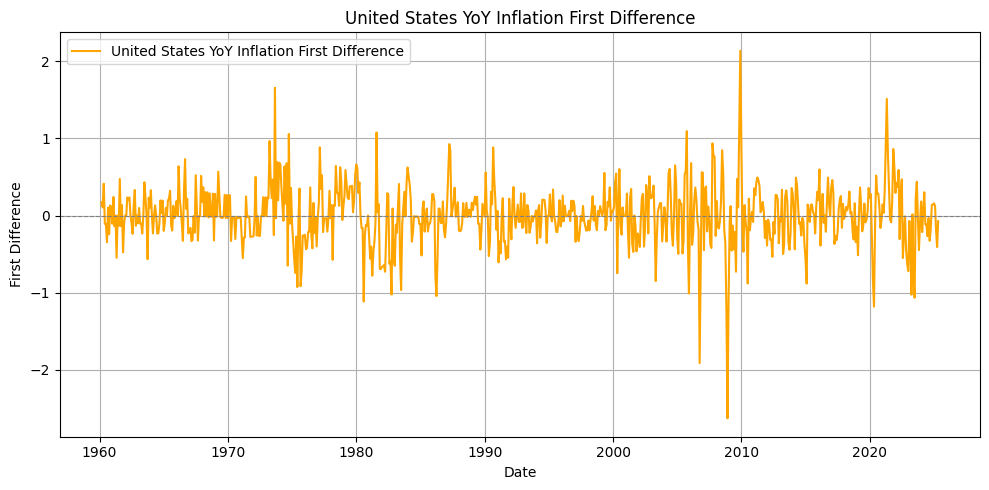

--- ADF Tests for United States CPI ---
ADF P-value (Original): 0.9987 -> Stationary: No
ADF P-value (1st Diff): 0.0031 -> Stationary: Yes

ADF P-value (Original): 0.9987 -> Stationary: No
ADF P-value (1st Diff): 0.0031 -> Stationary: Yes



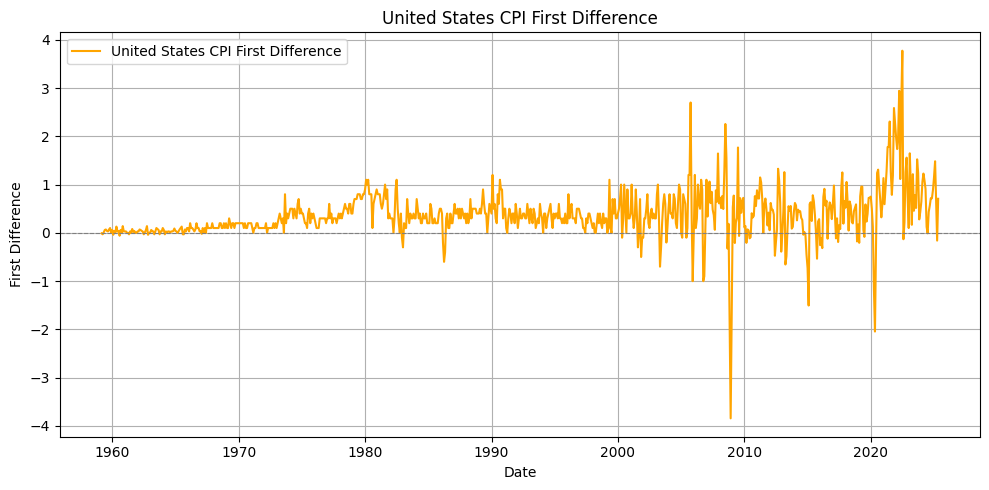

In [6]:
# Helper function for ADF test and plotting
def perform_and_plot_adf(ts, name, color):
    """Conducts ADF test on a series and its first difference, then plots the difference."""
    print(f"--- ADF Tests for {name} ---")
    
    # Test original series
    result_orig = adfuller(ts)
    print(f"ADF P-value (Original): {result_orig[1]:.4f} -> Stationary: {'Yes' if result_orig[1] < 0.05 else 'No'}")

    # Test first difference
    diff_ts = ts.diff().dropna()
    result_diff = adfuller(diff_ts)
    print(f"ADF P-value (1st Diff): {result_diff[1]:.4f} -> Stationary: {'Yes' if result_diff[1] < 0.05 else 'No'}\n")
    
    # Plot first differences
    plt.figure(figsize=(10, 5))
    plt.plot(diff_ts, label=f'{name} First Difference', color=color)
    plt.axhline(0, linestyle='--', color='grey', linewidth=0.8)
    plt.title(f'{name} First Difference')
    plt.xlabel('Date')
    plt.ylabel('First Difference')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return diff_ts

# Perform ADF tests and create differenced series
diff_series = {}
diff_cpi_series = {}
for key in series:
    diff_series[key] = perform_and_plot_adf(series[key], f"{labels[key]} YoY Inflation", colors[key])
    diff_cpi_series[key] = perform_and_plot_adf(cpi_series[key], f"{labels[key]} CPI", colors[key])

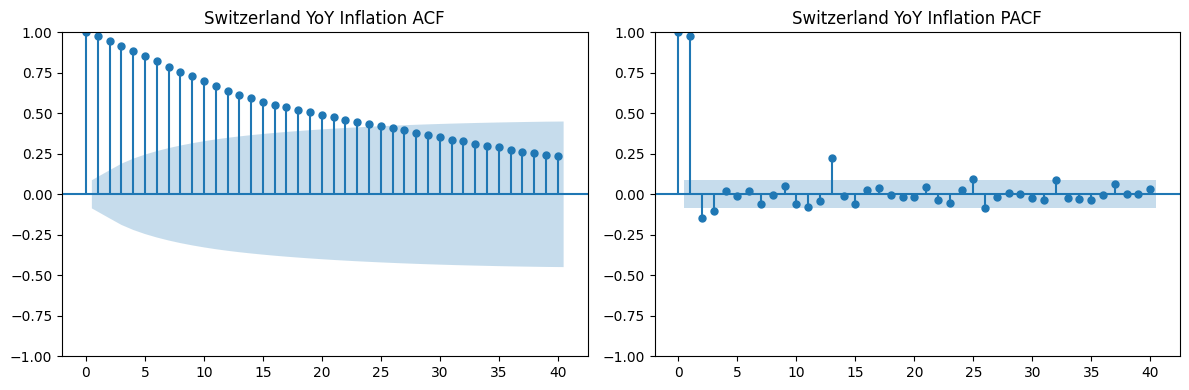

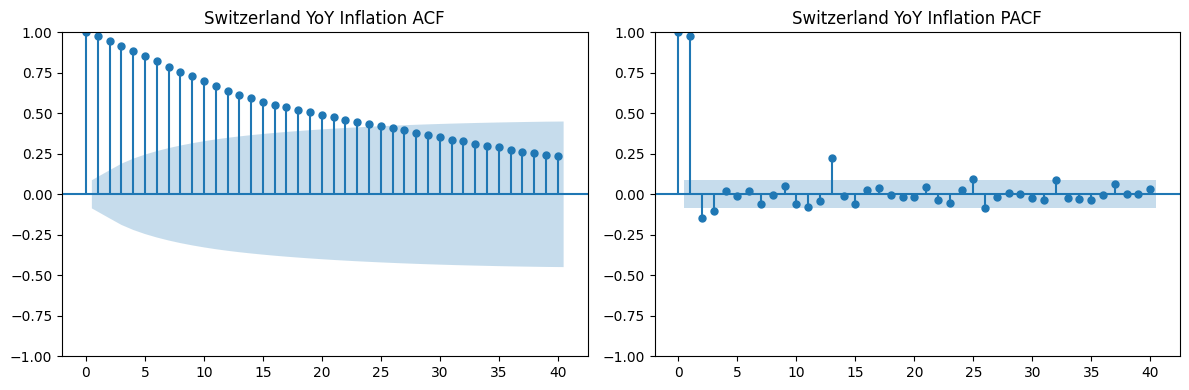

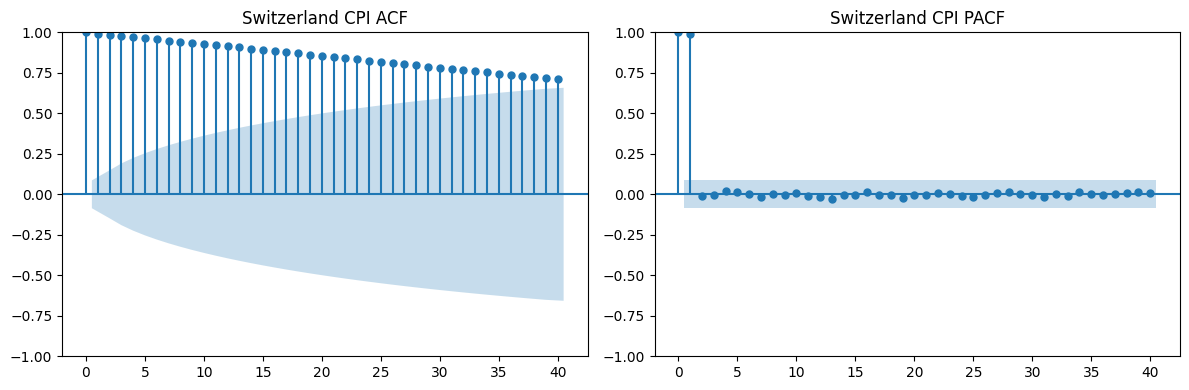

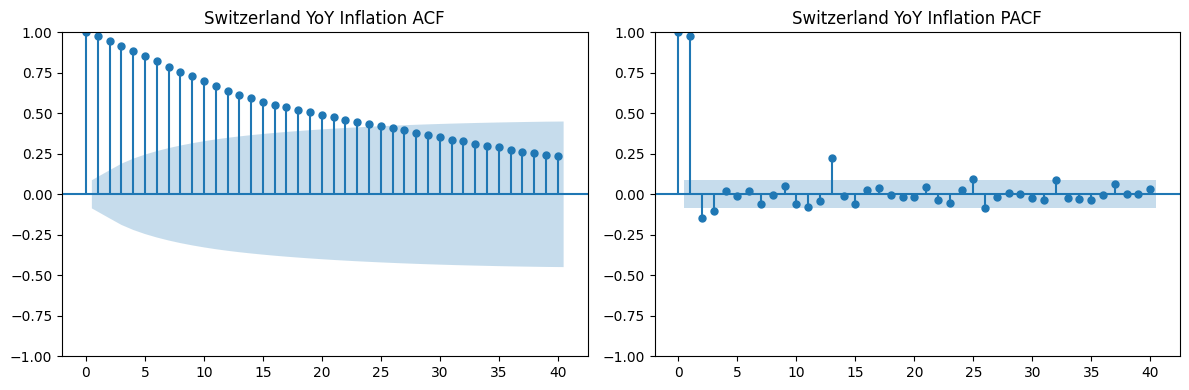

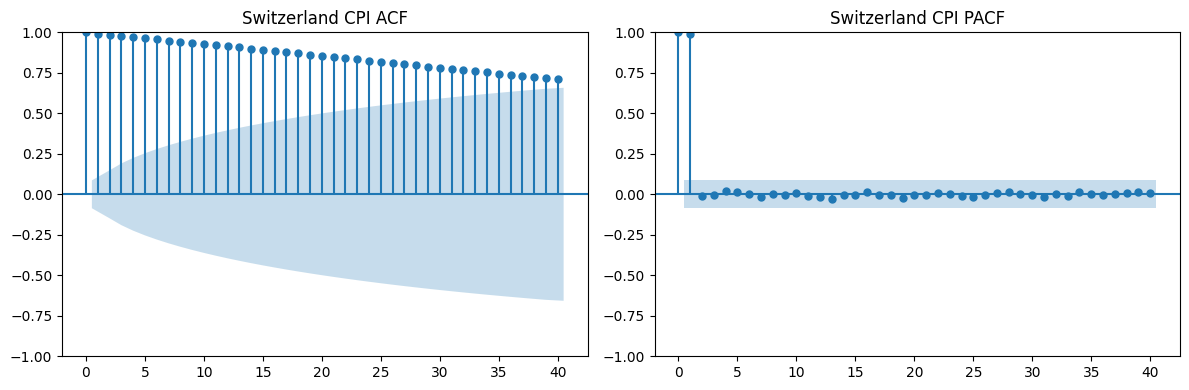

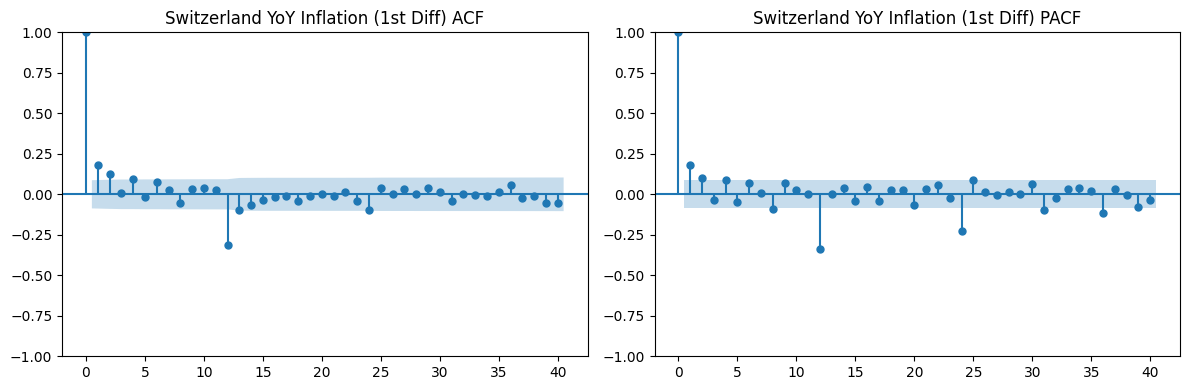

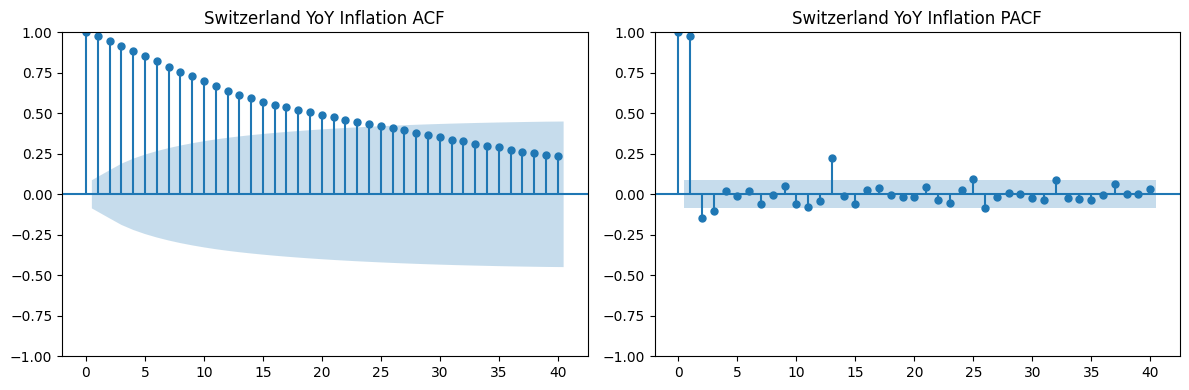

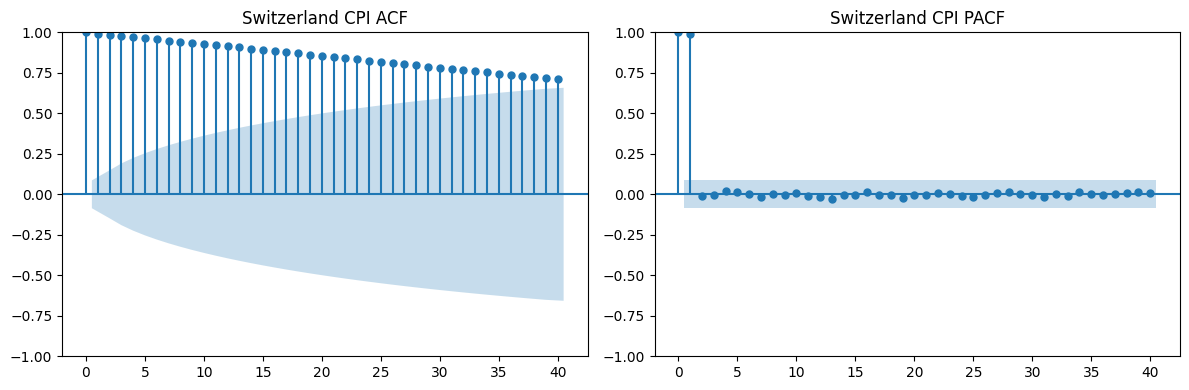

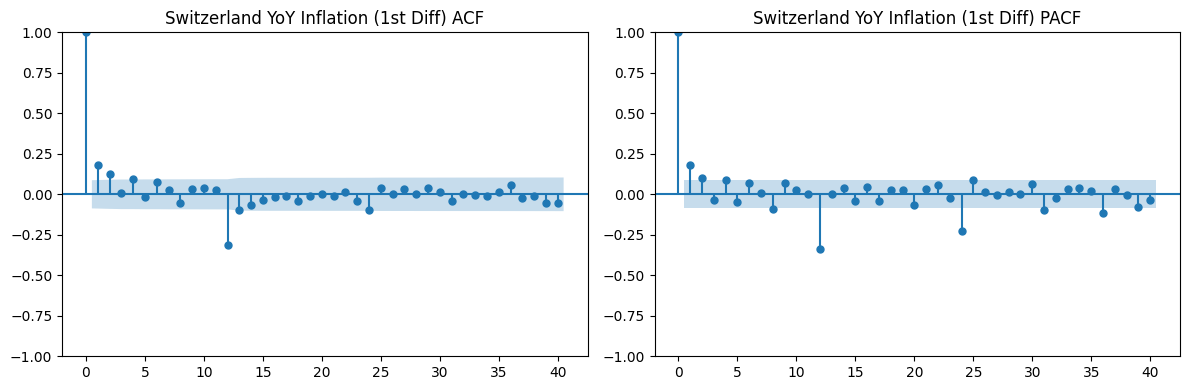

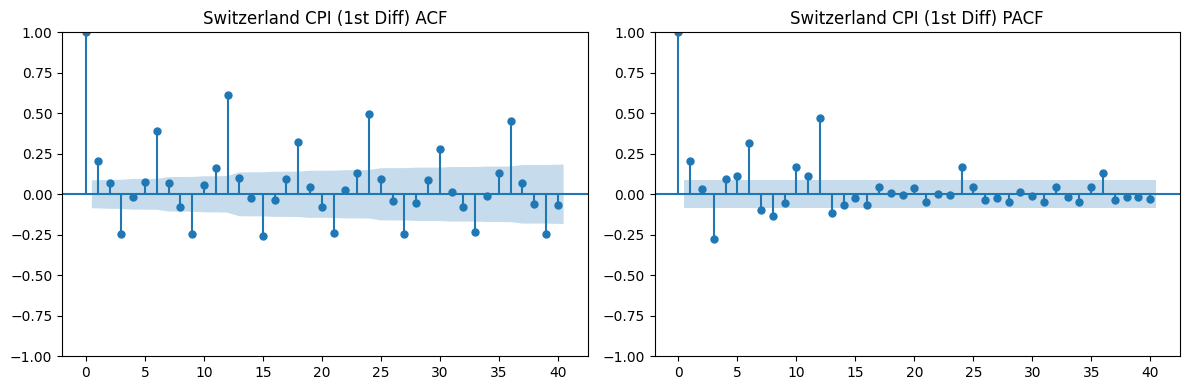

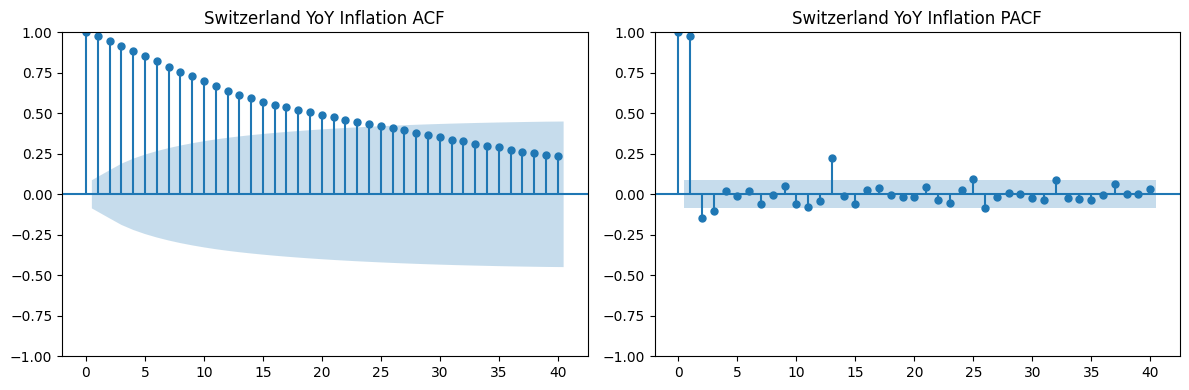

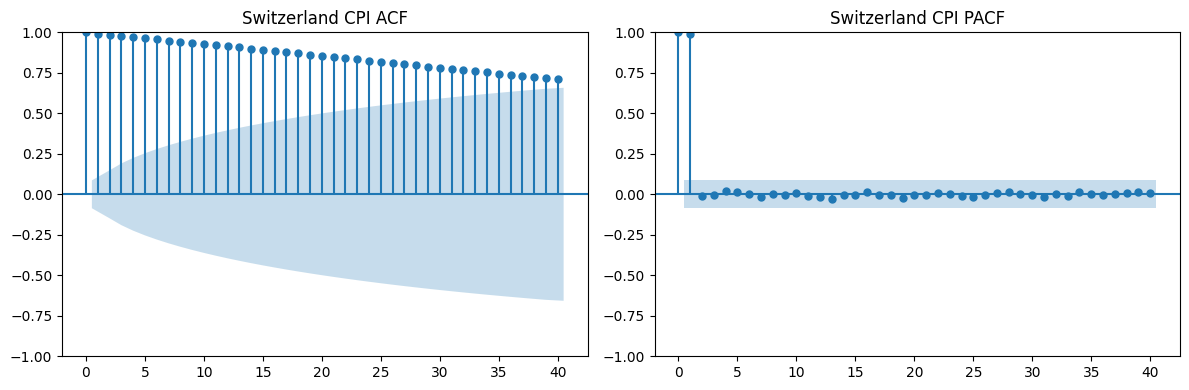

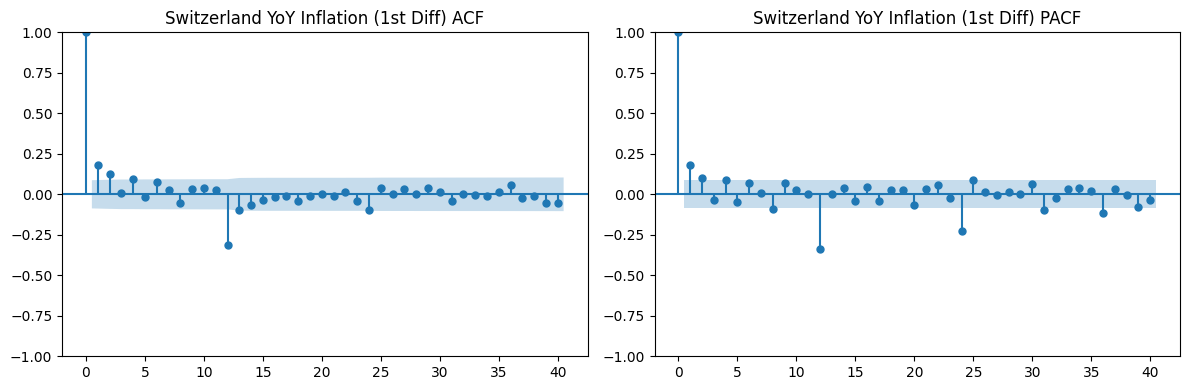

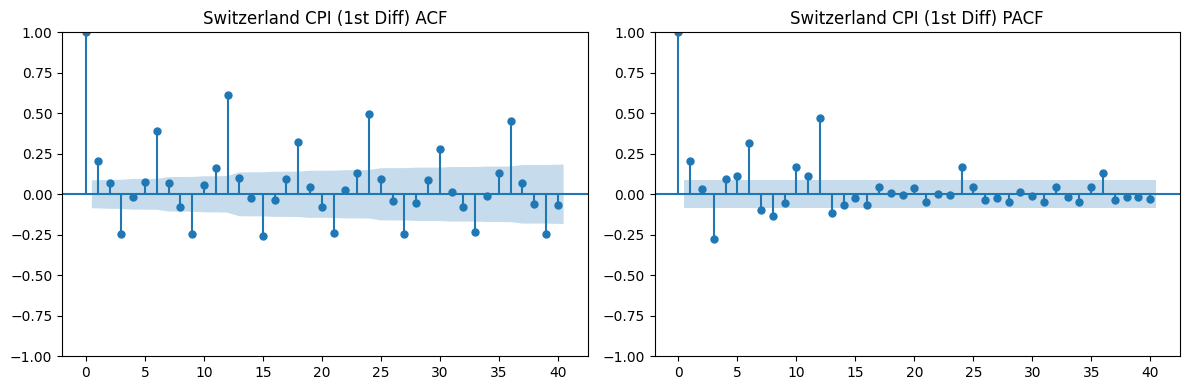

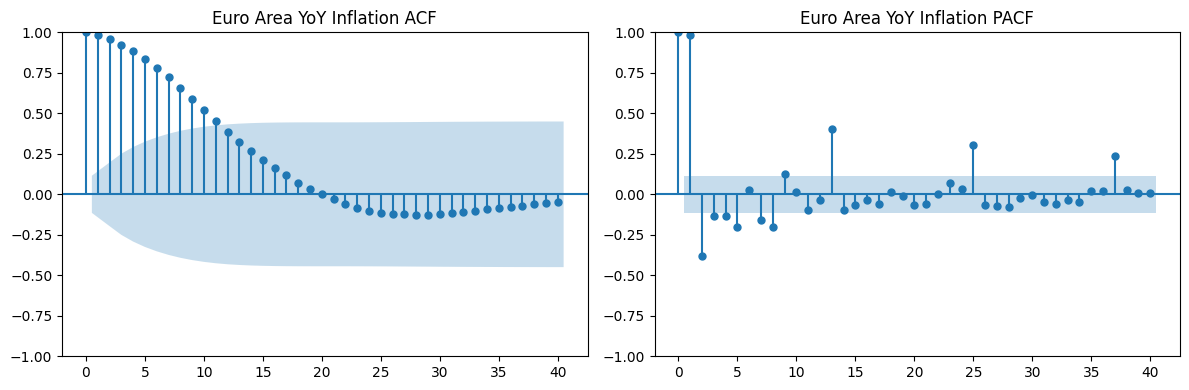

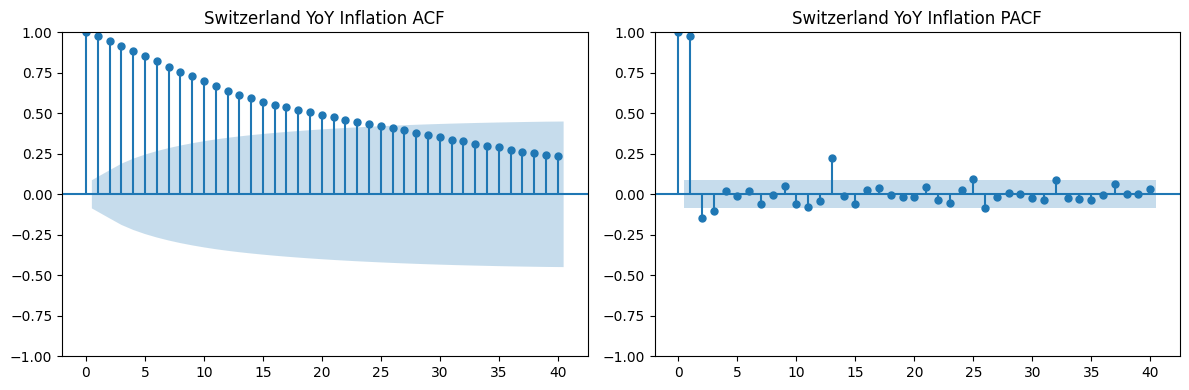

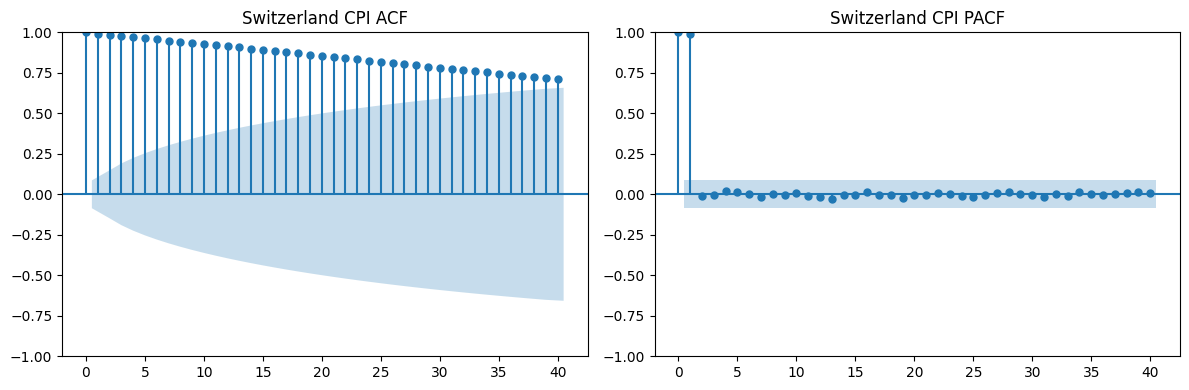

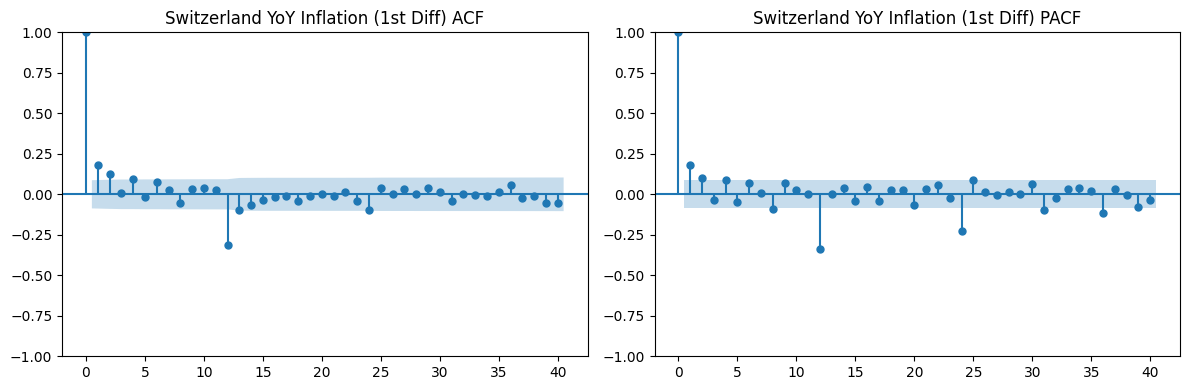

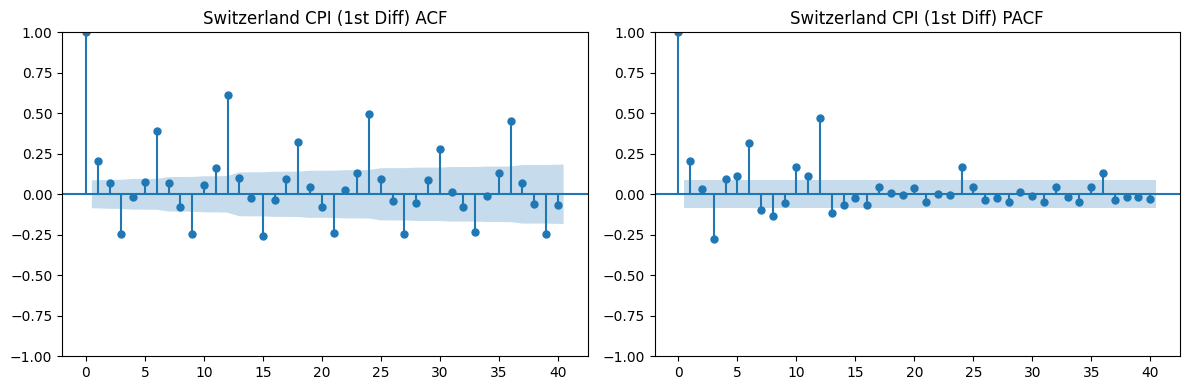

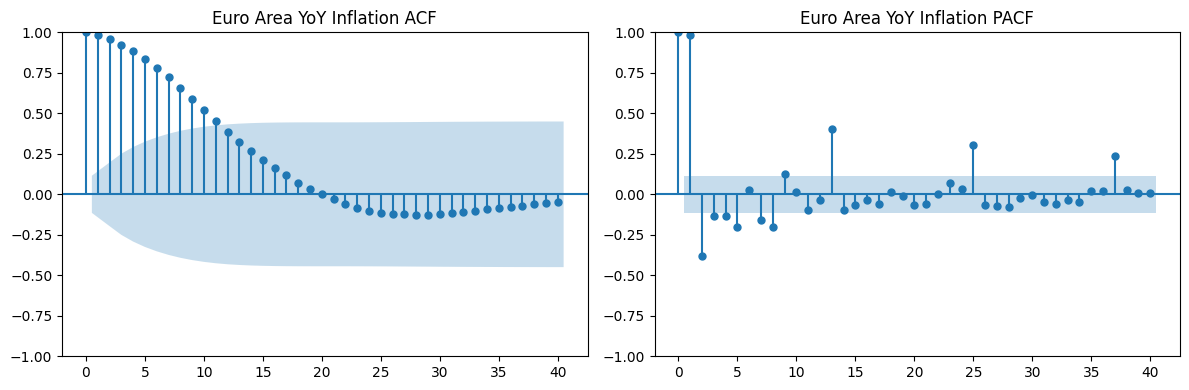

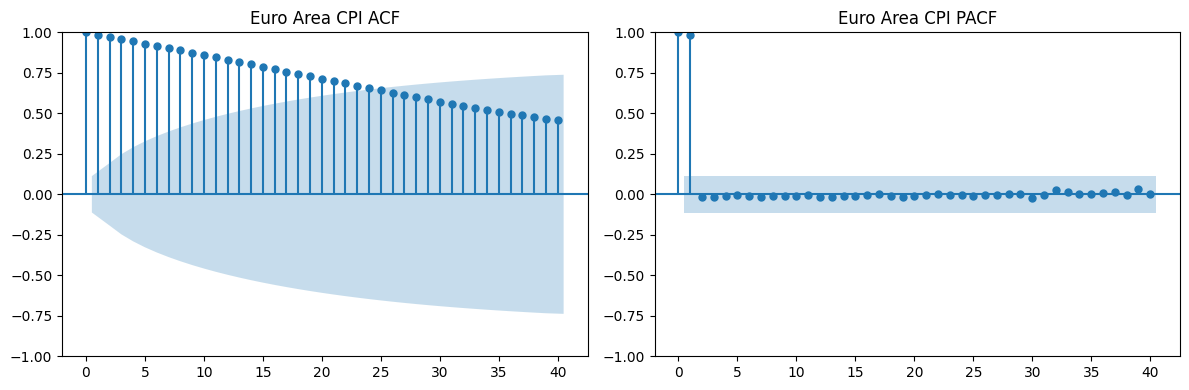

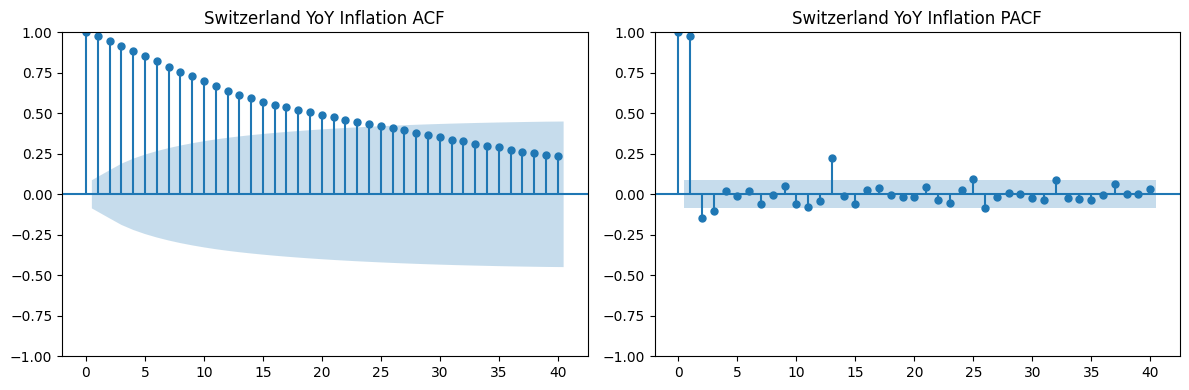

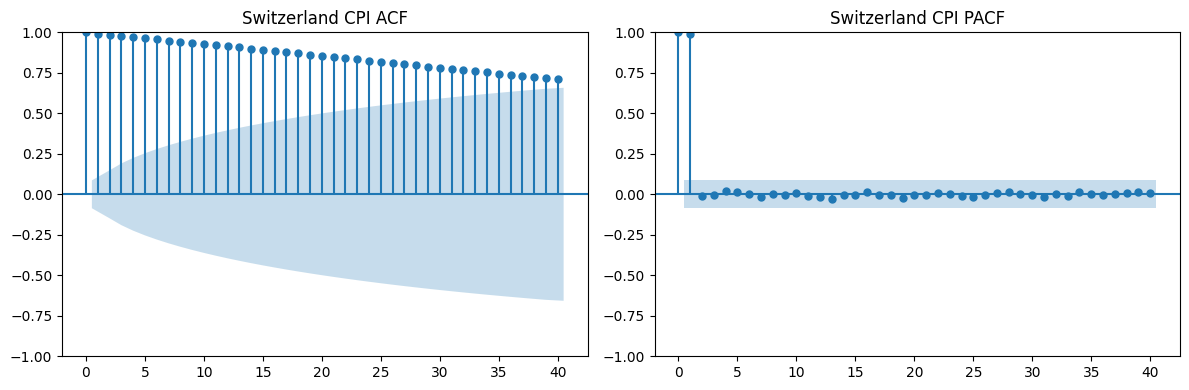

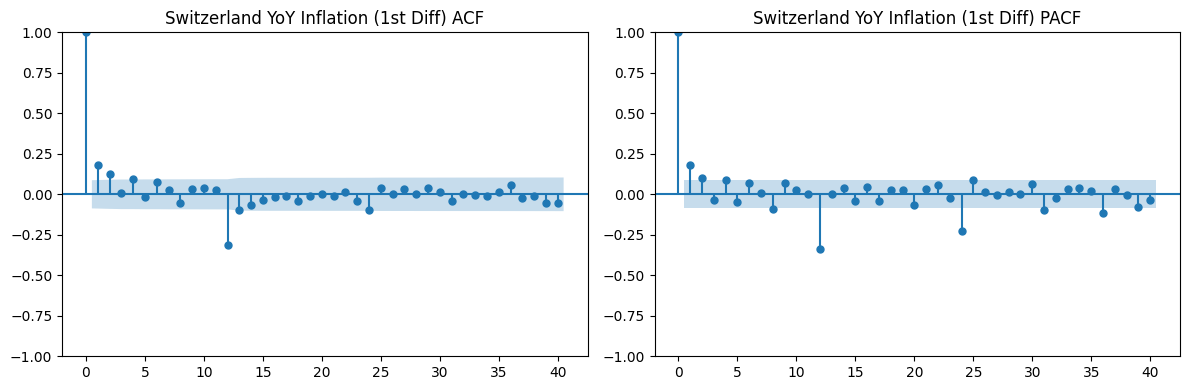

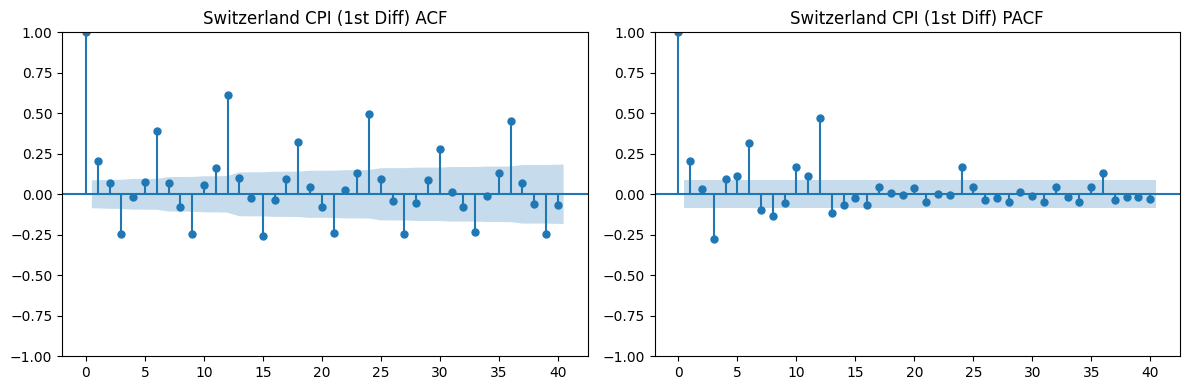

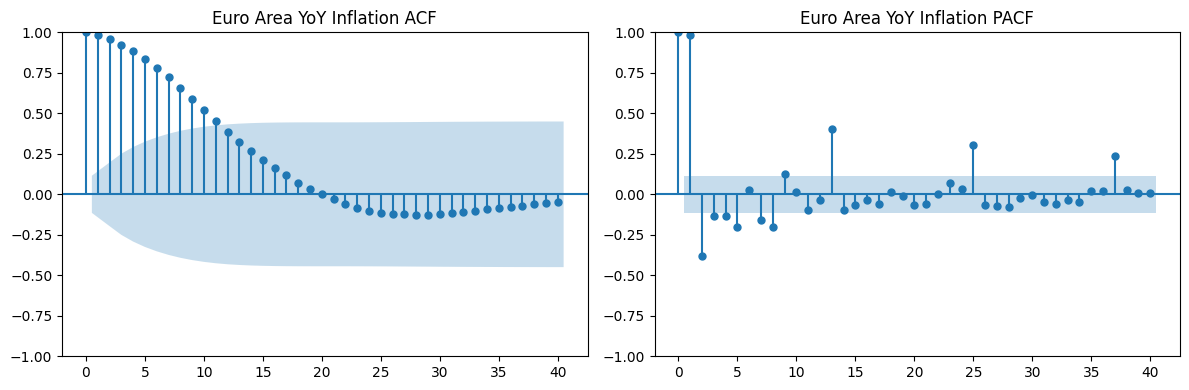

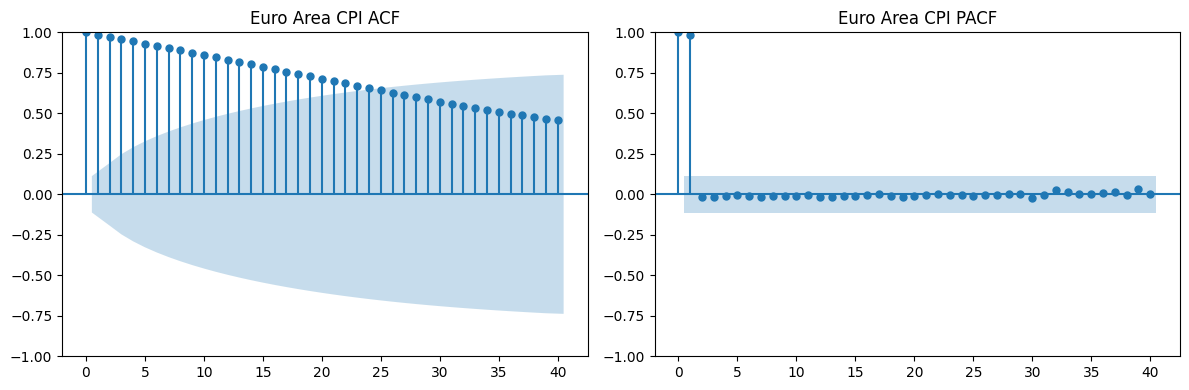

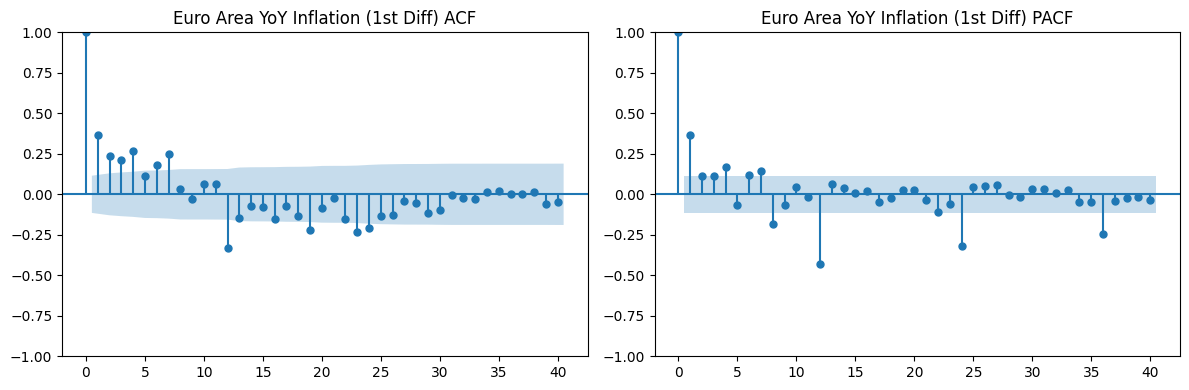

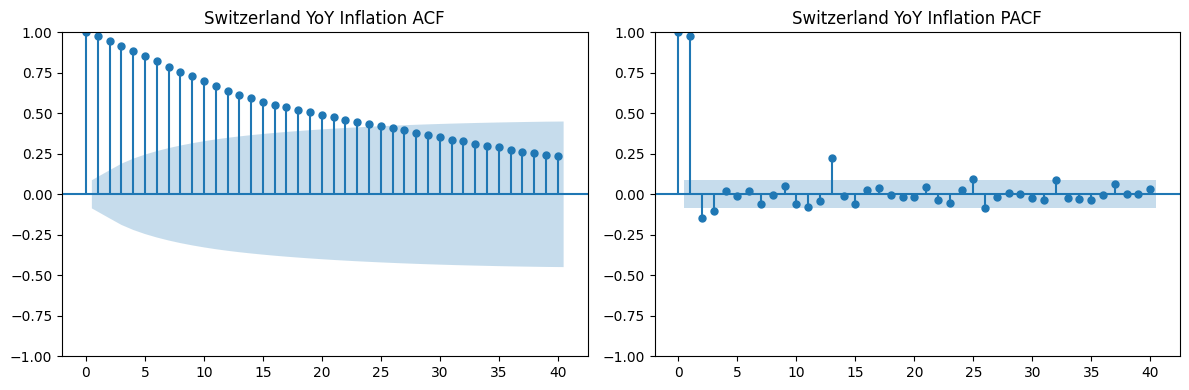

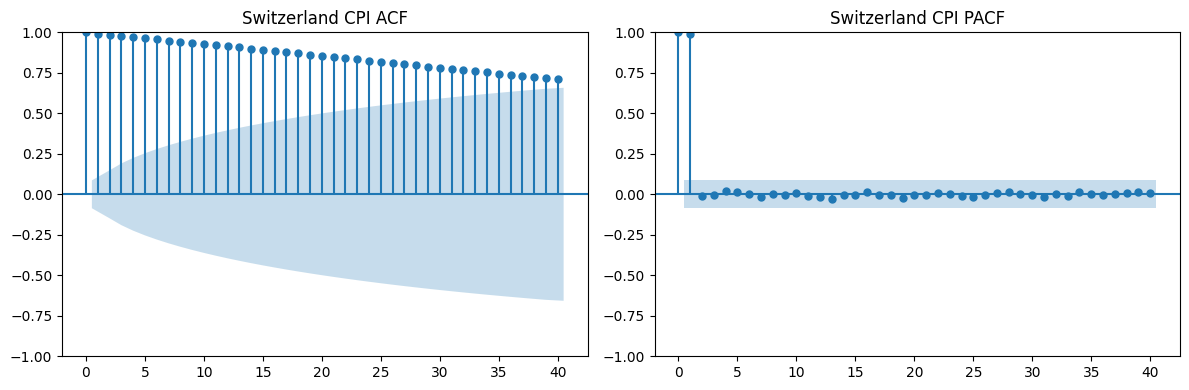

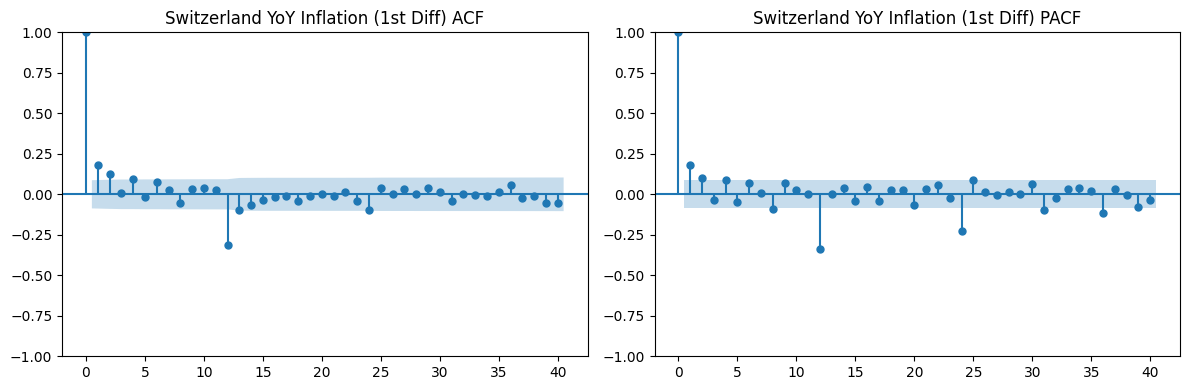

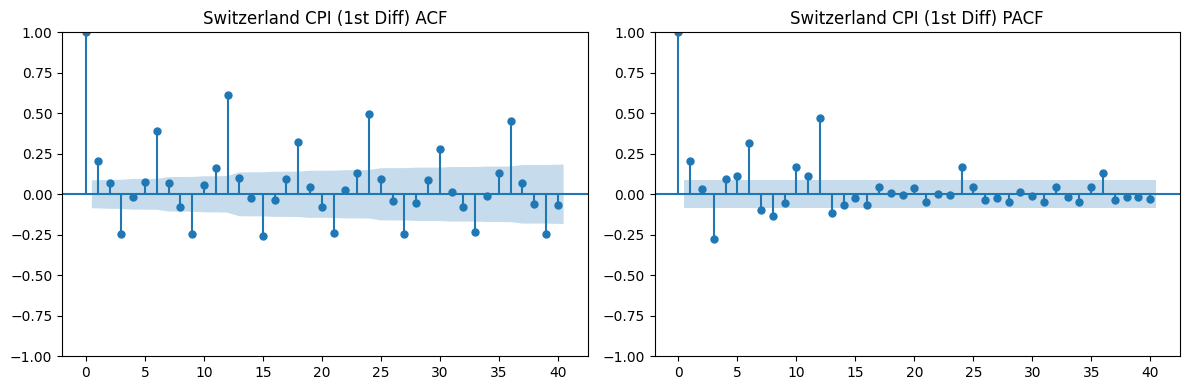

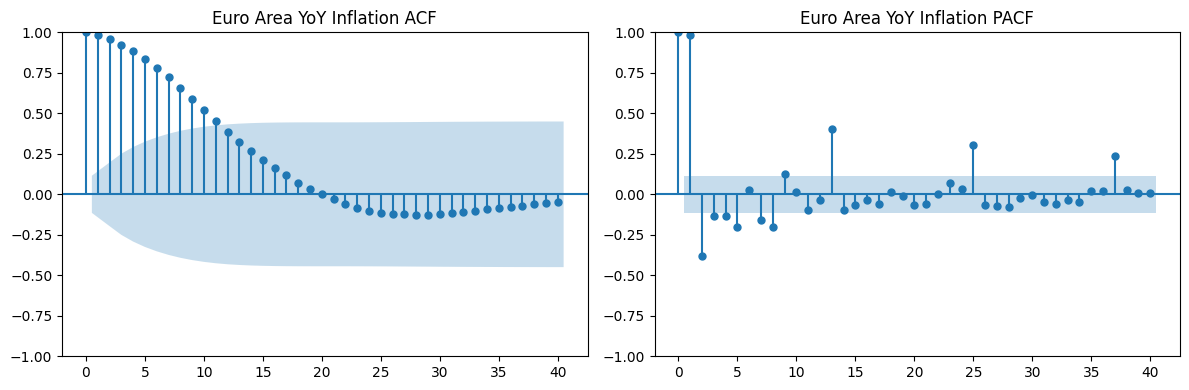

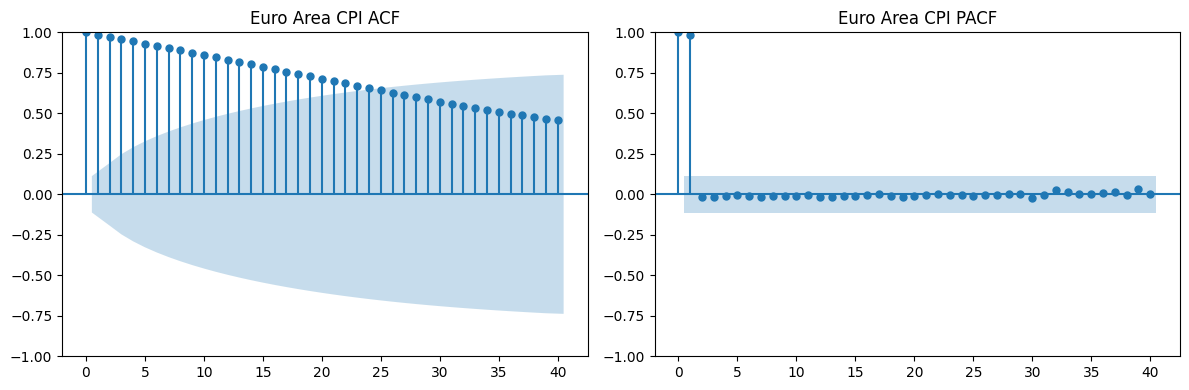

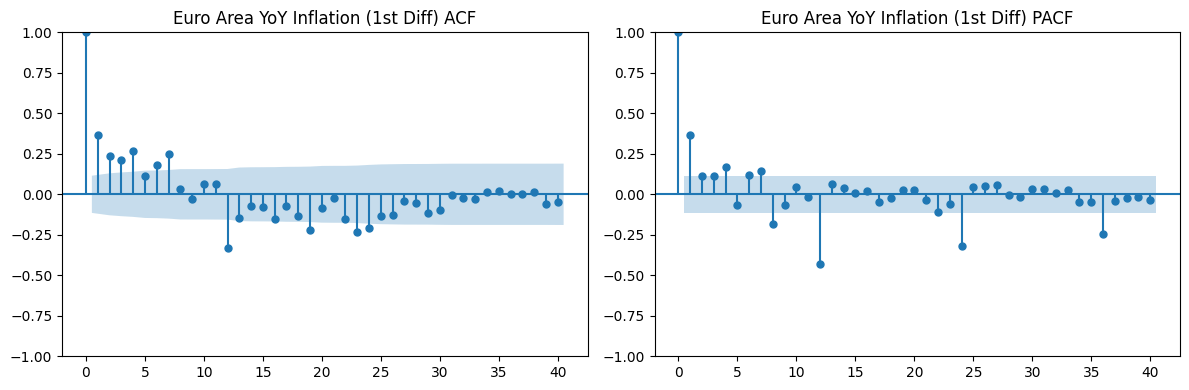

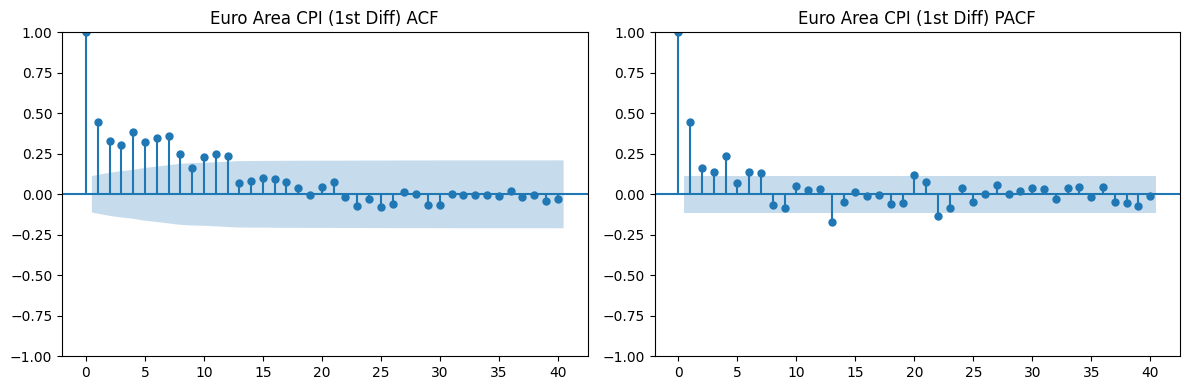

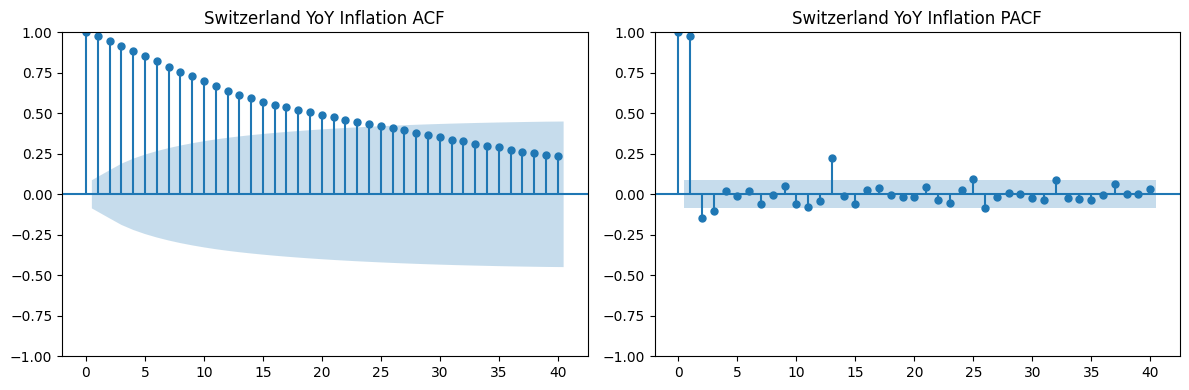

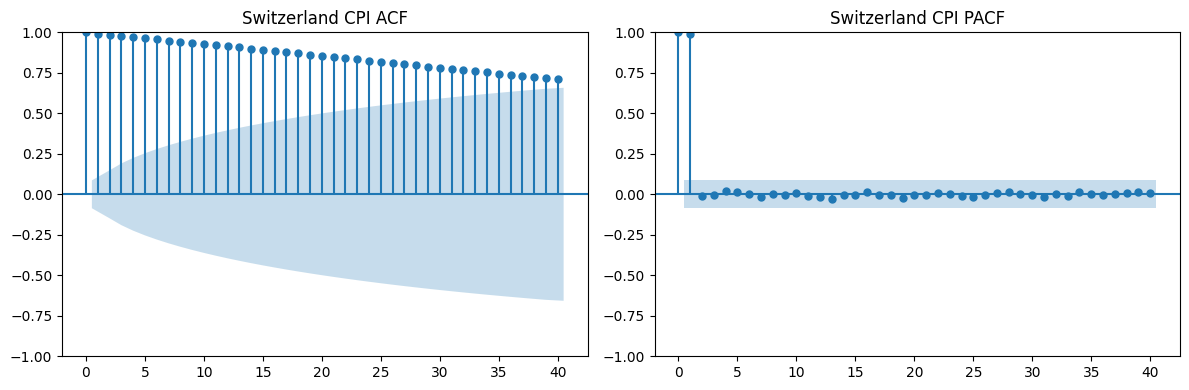

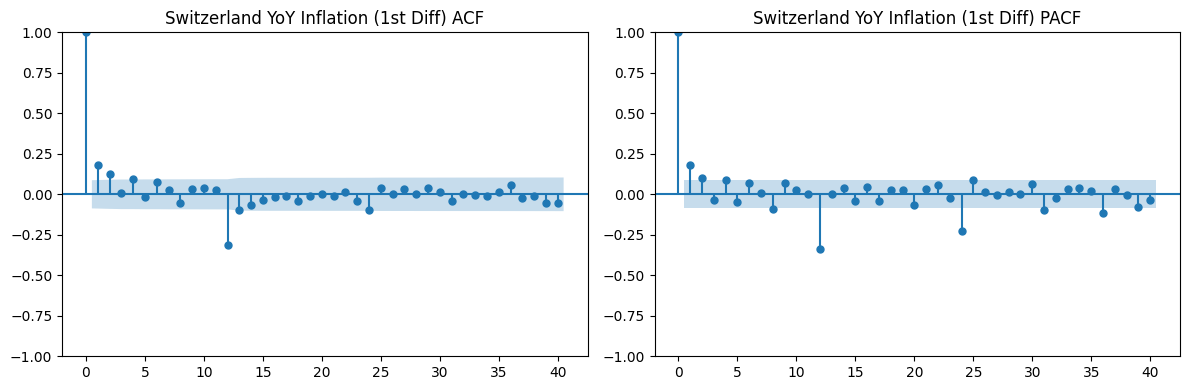

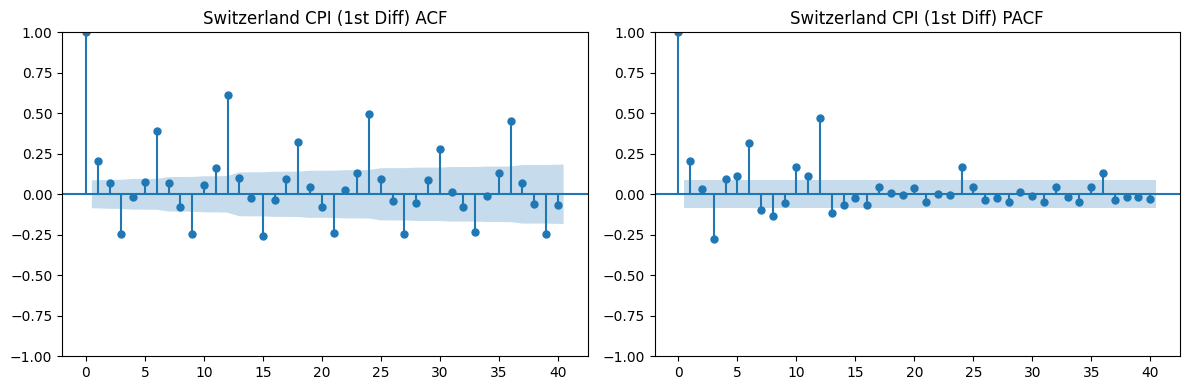

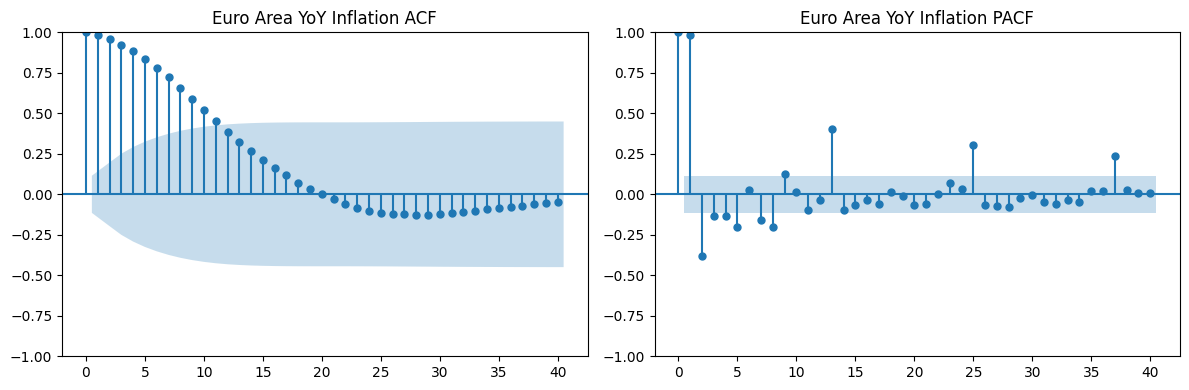

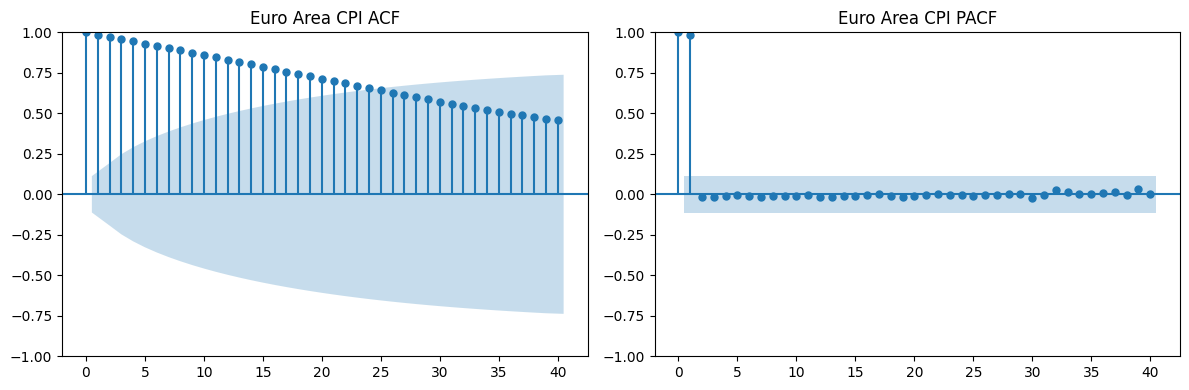

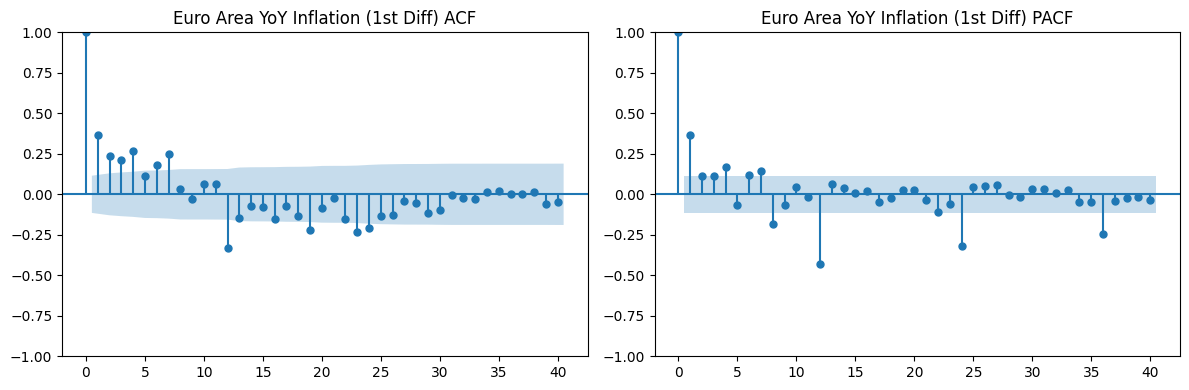

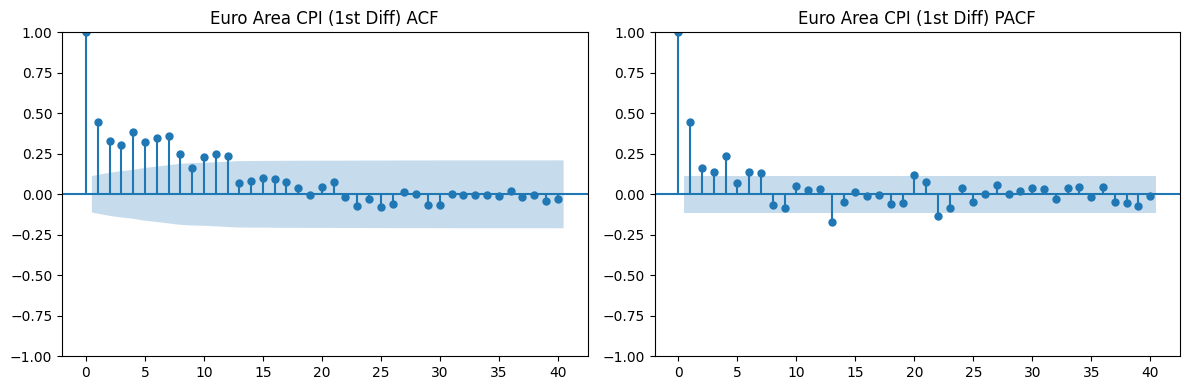

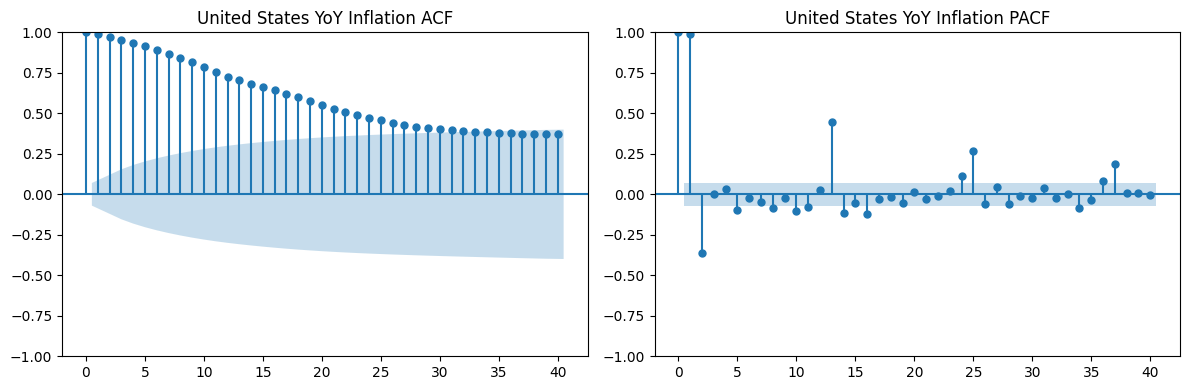

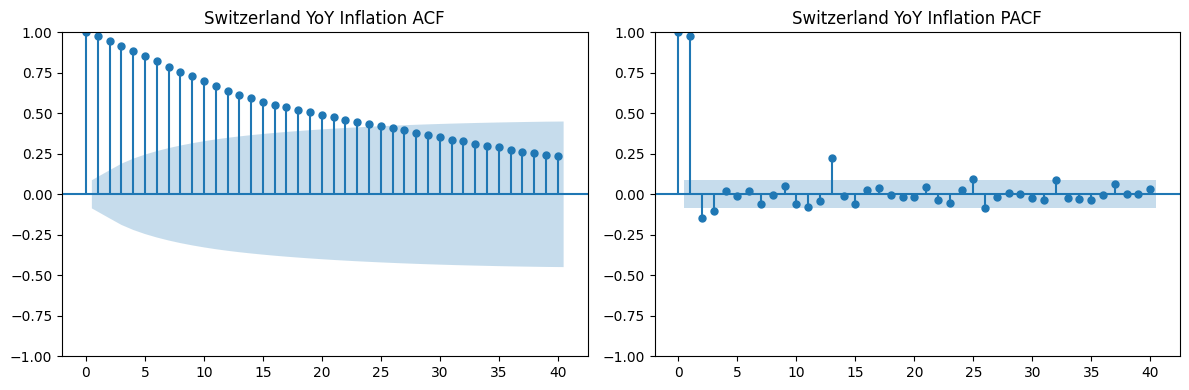

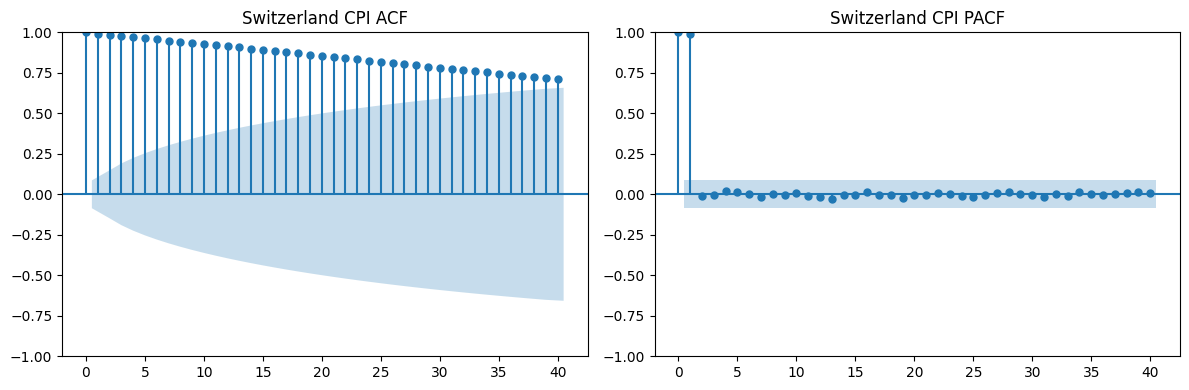

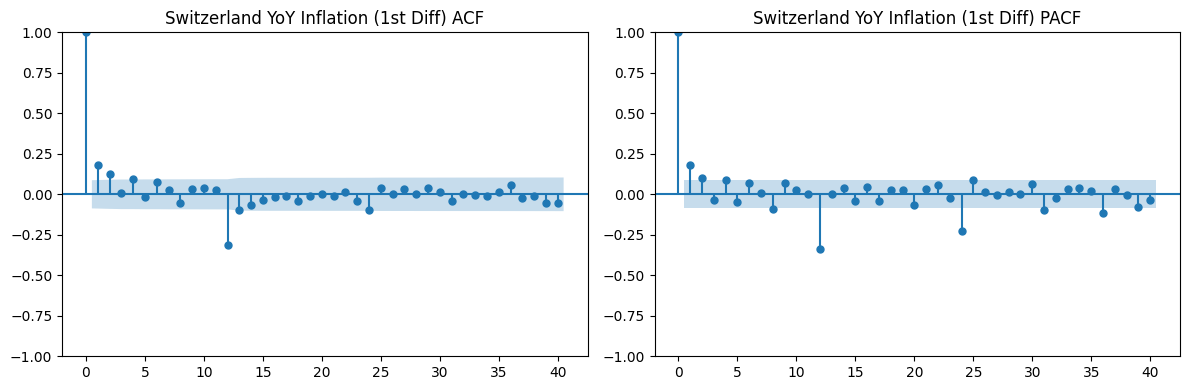

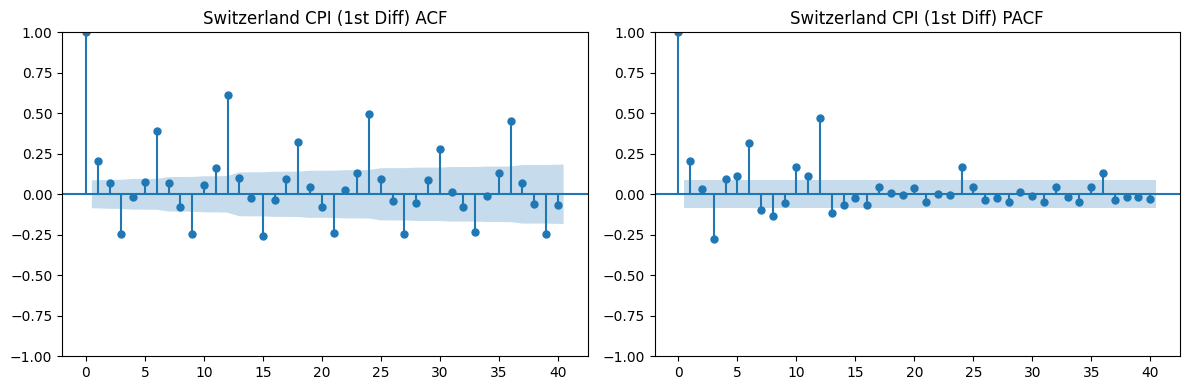

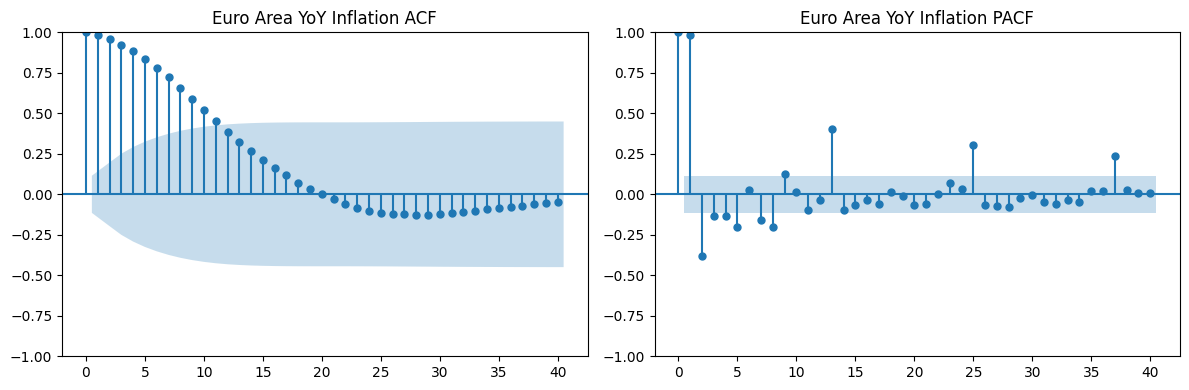

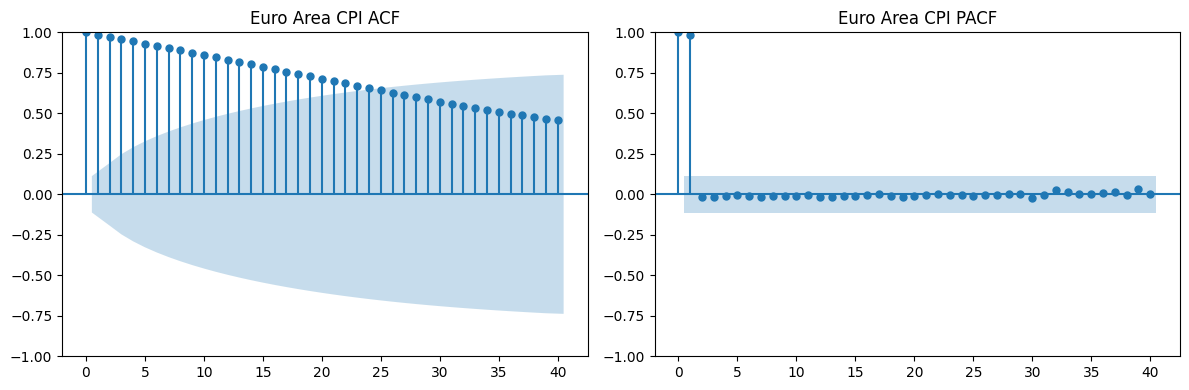

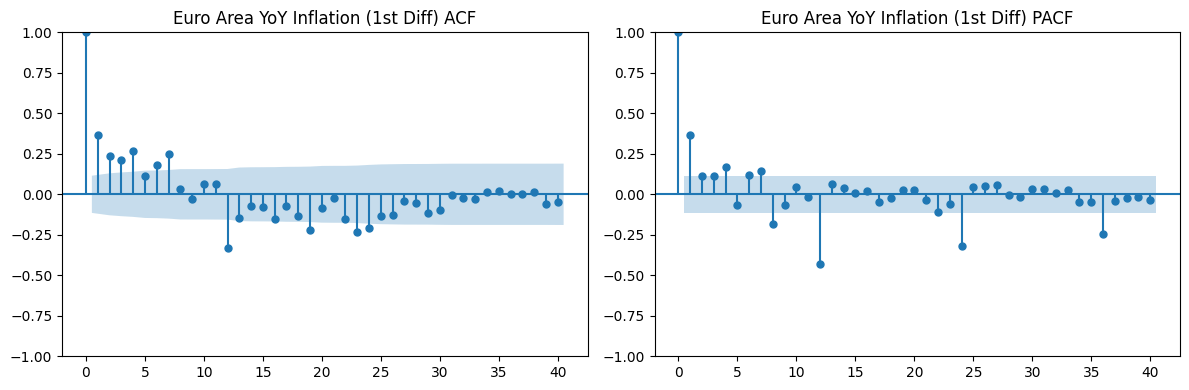

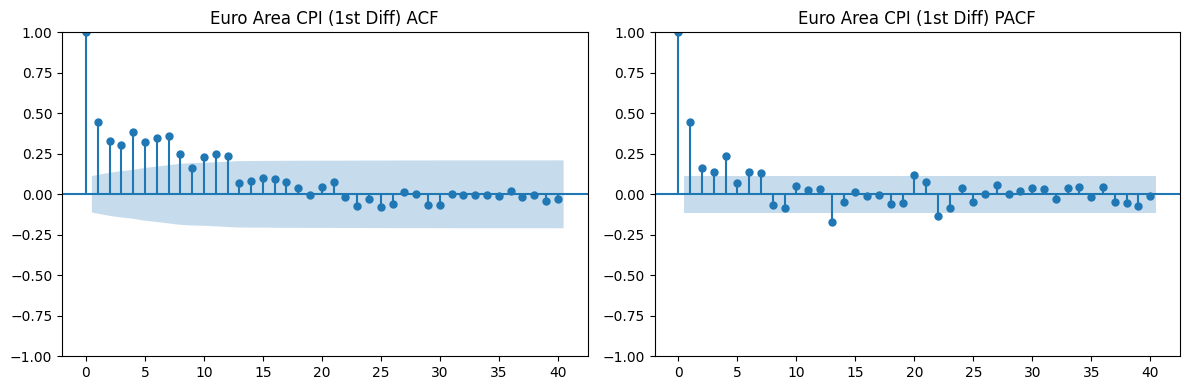

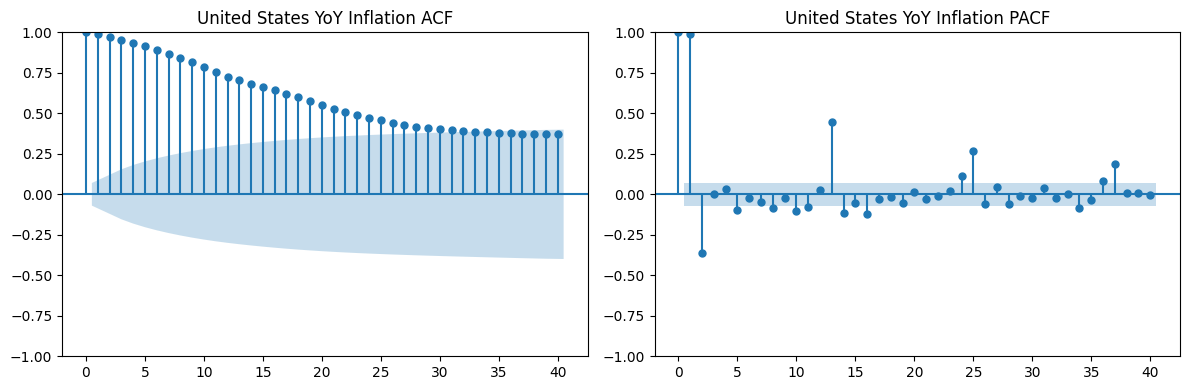

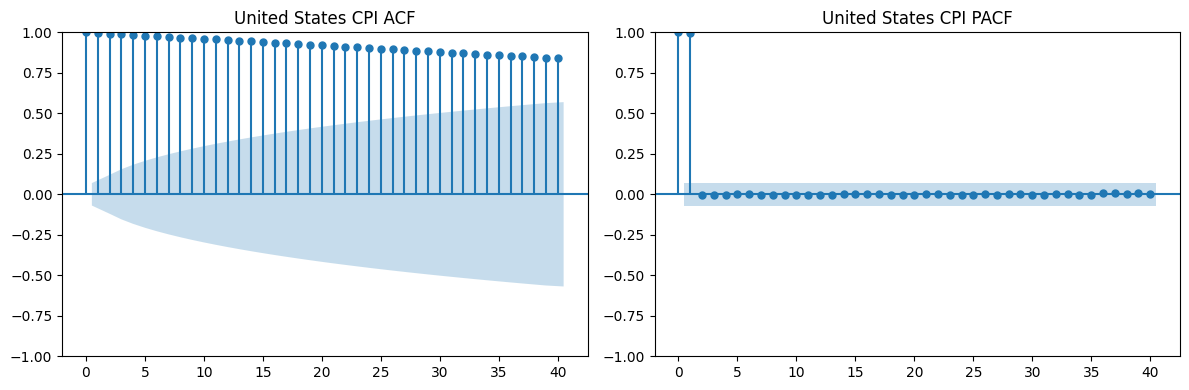

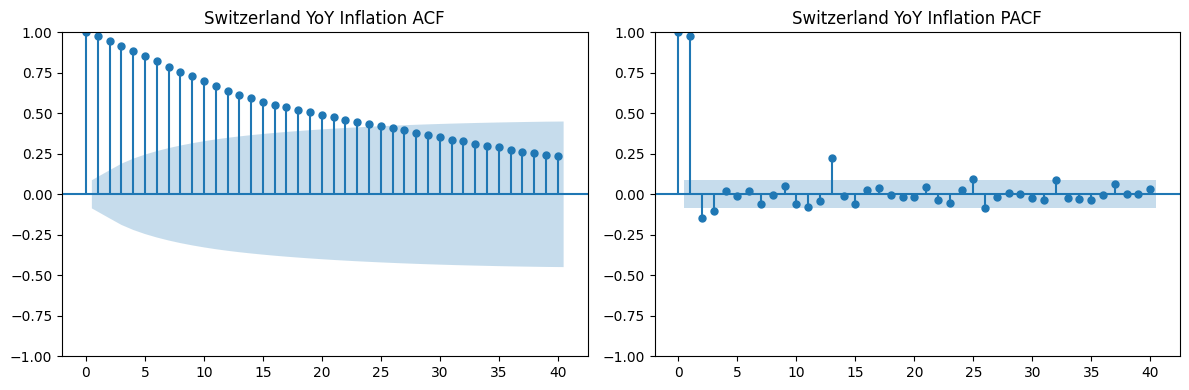

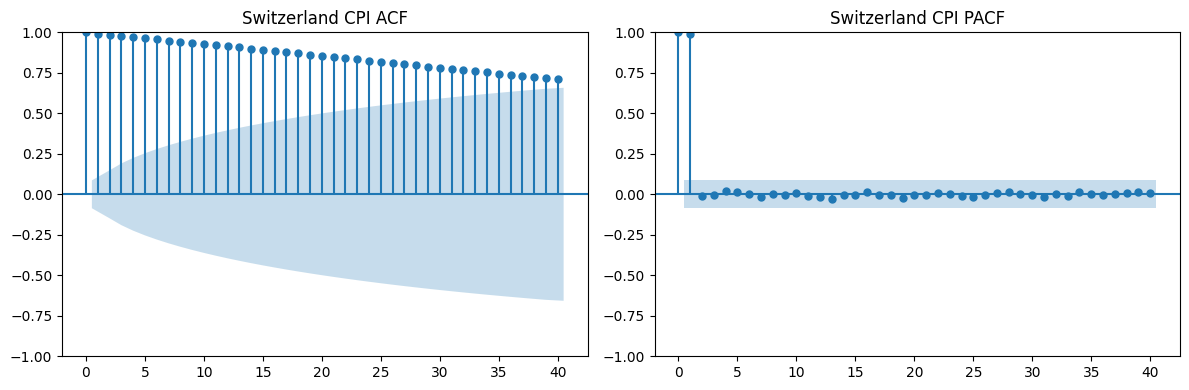

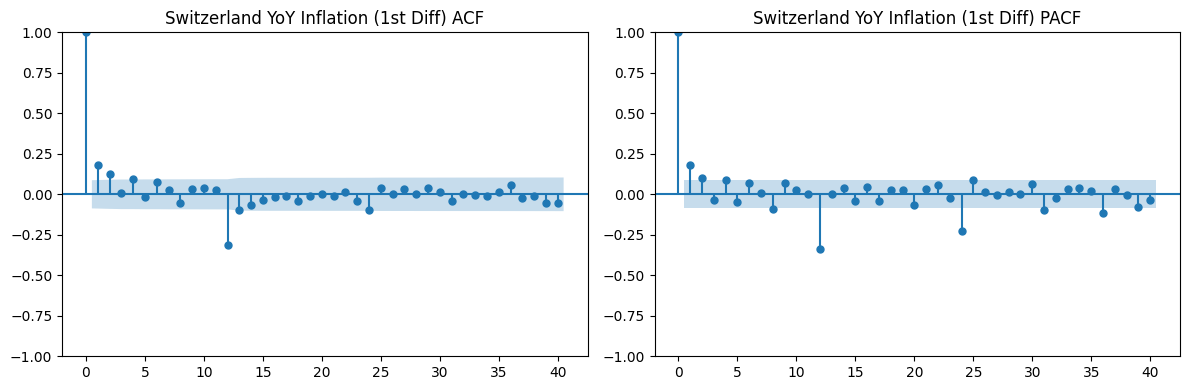

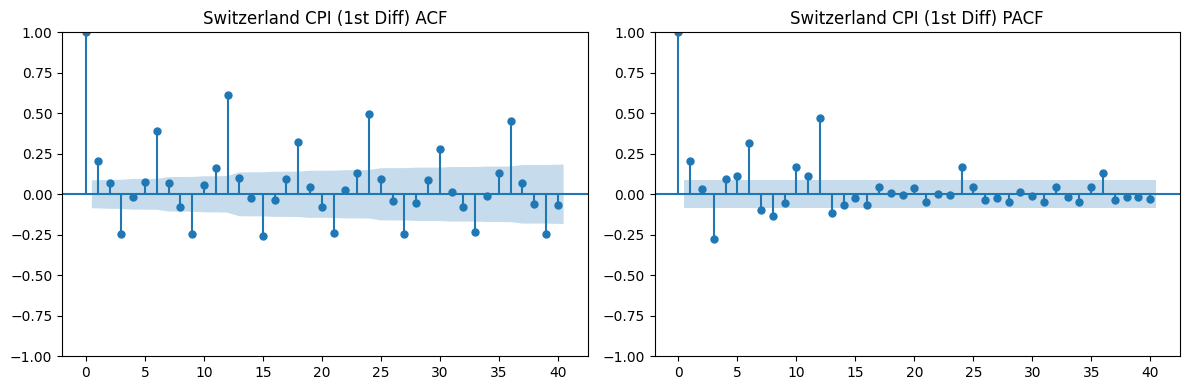

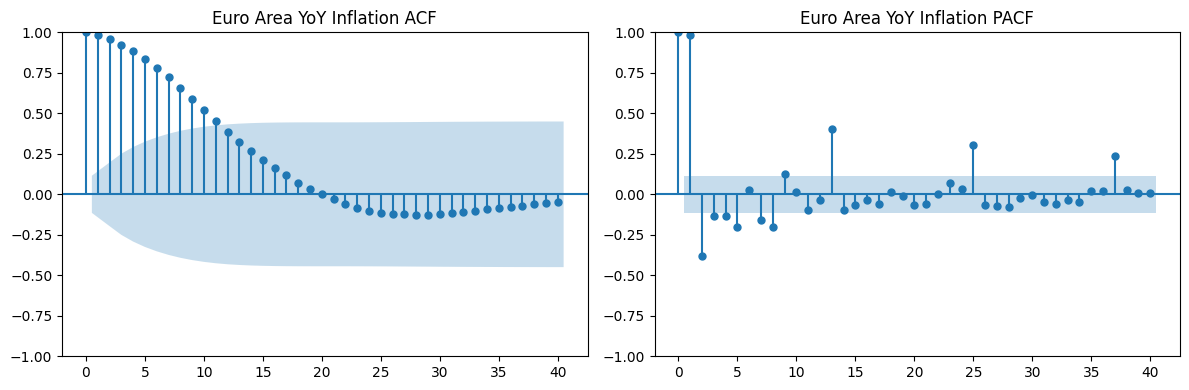

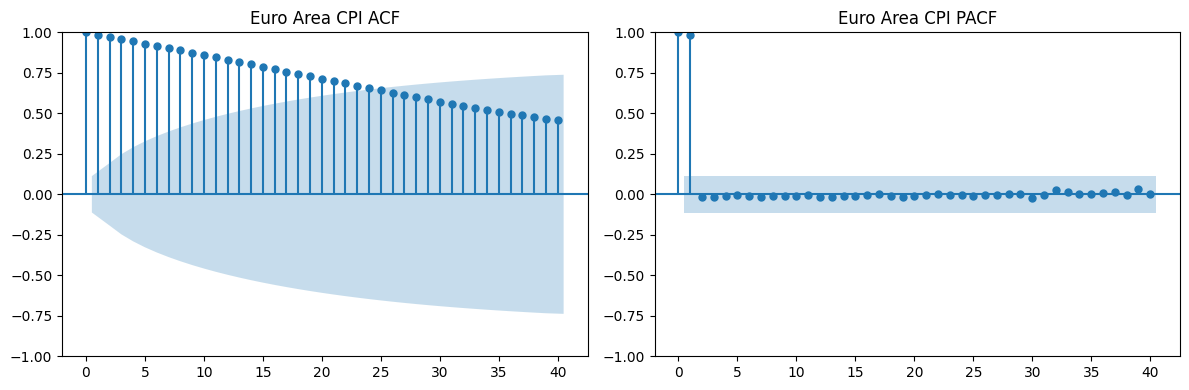

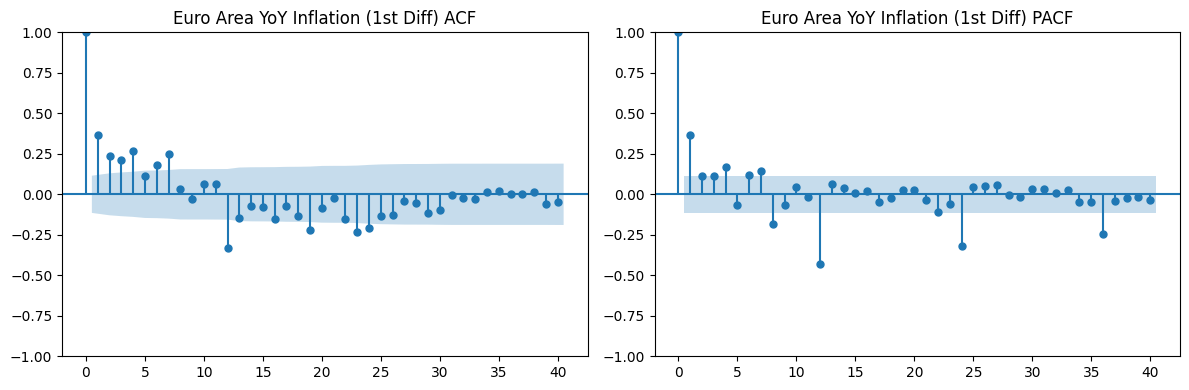

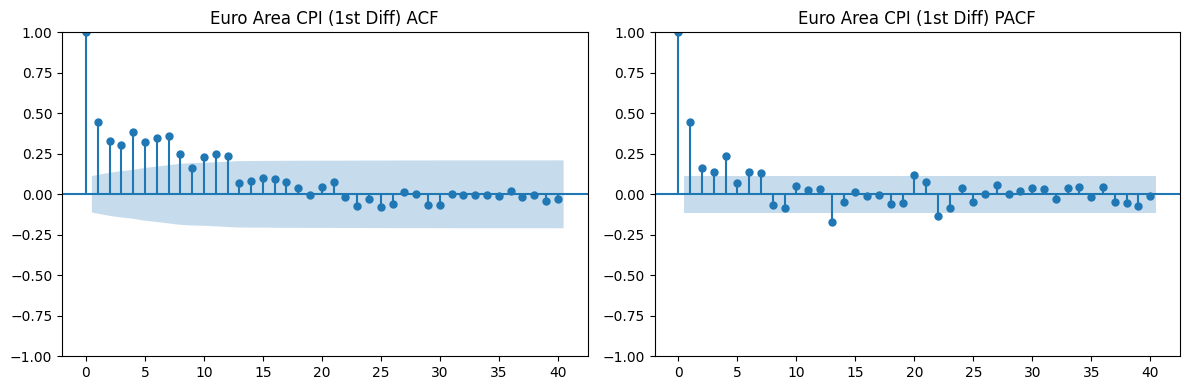

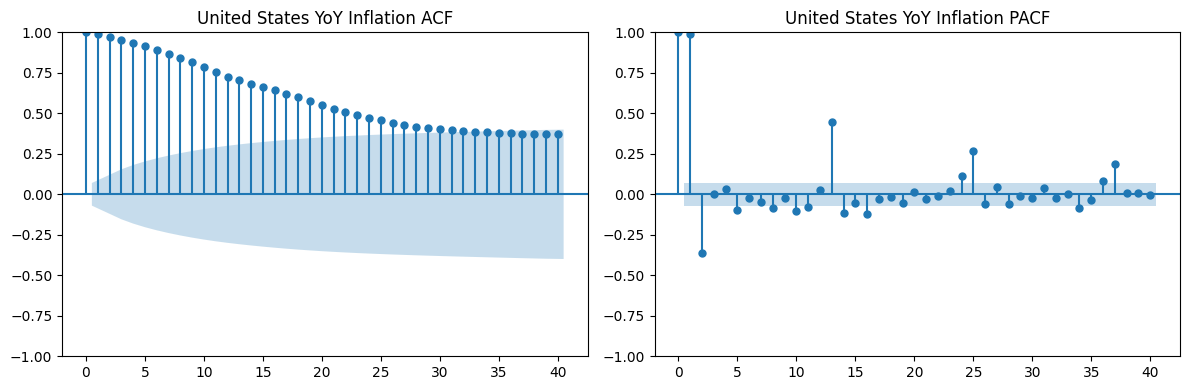

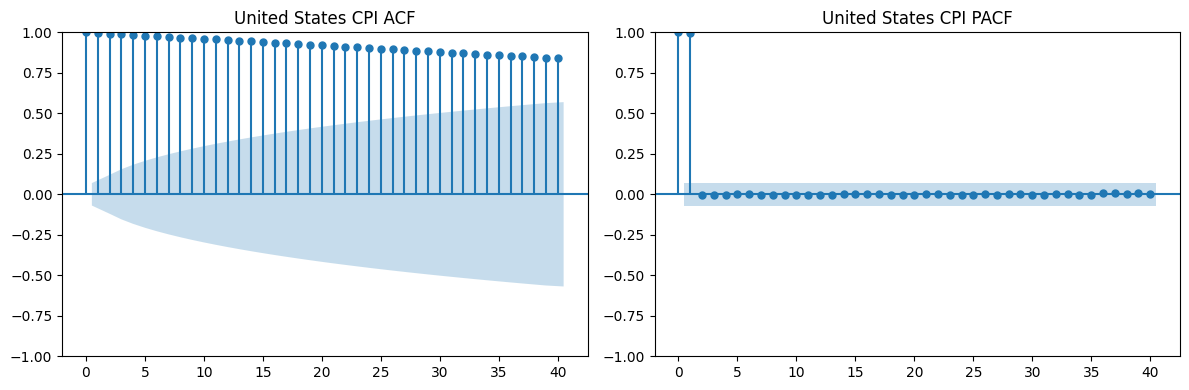

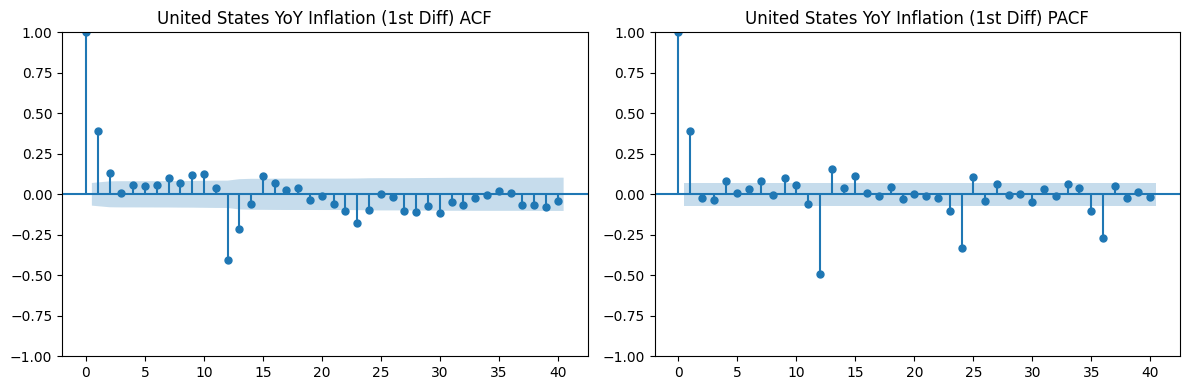

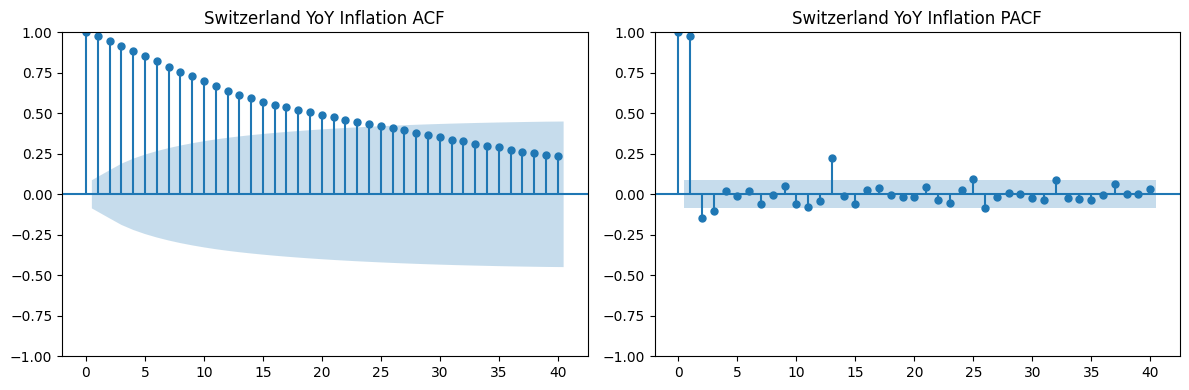

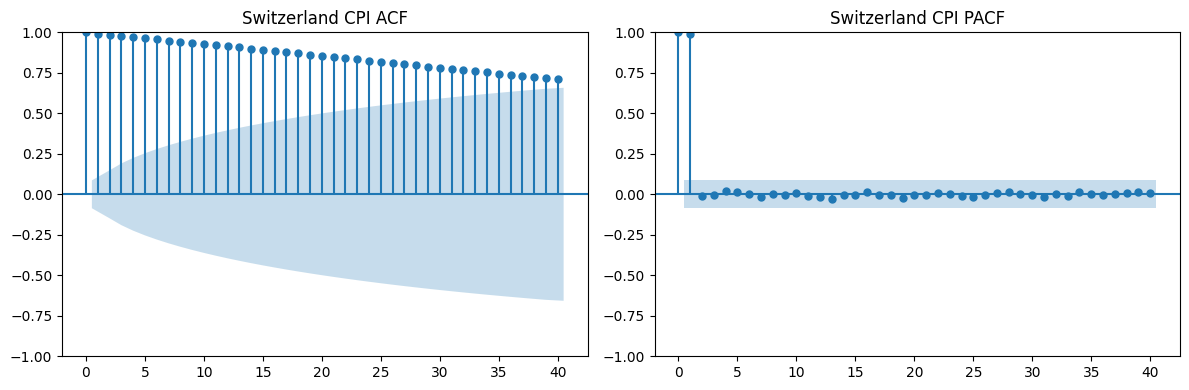

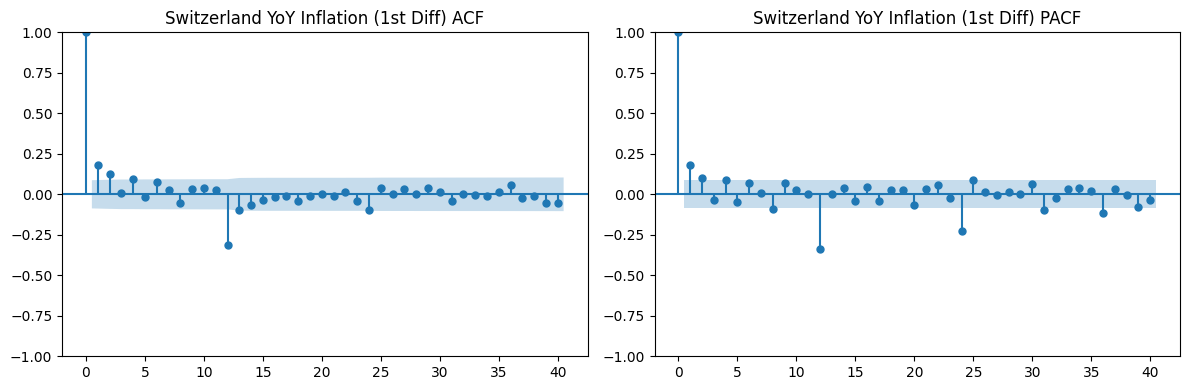

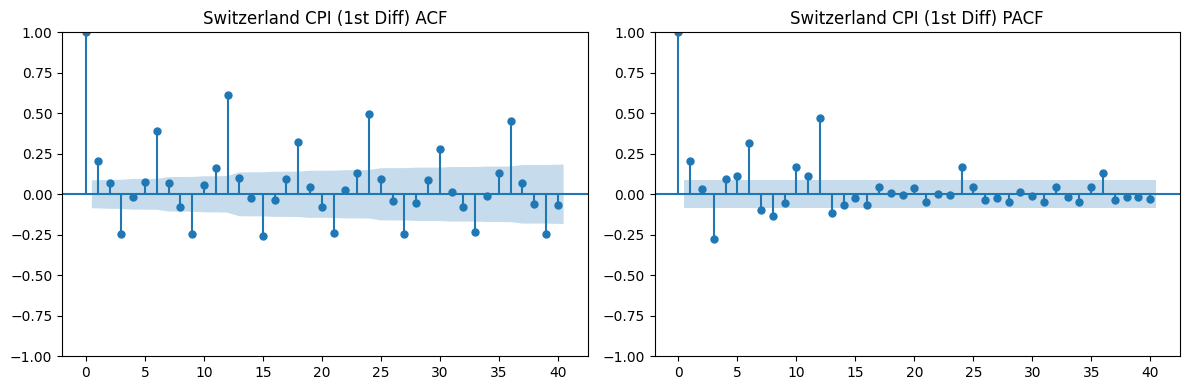

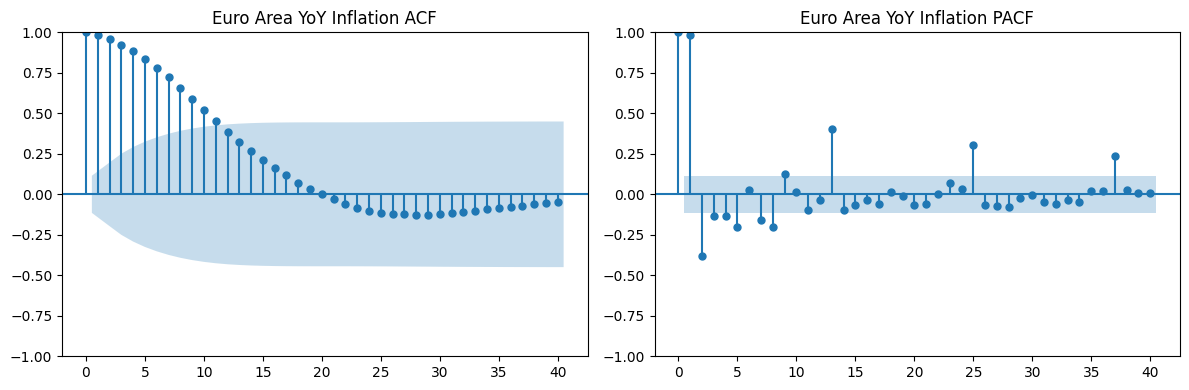

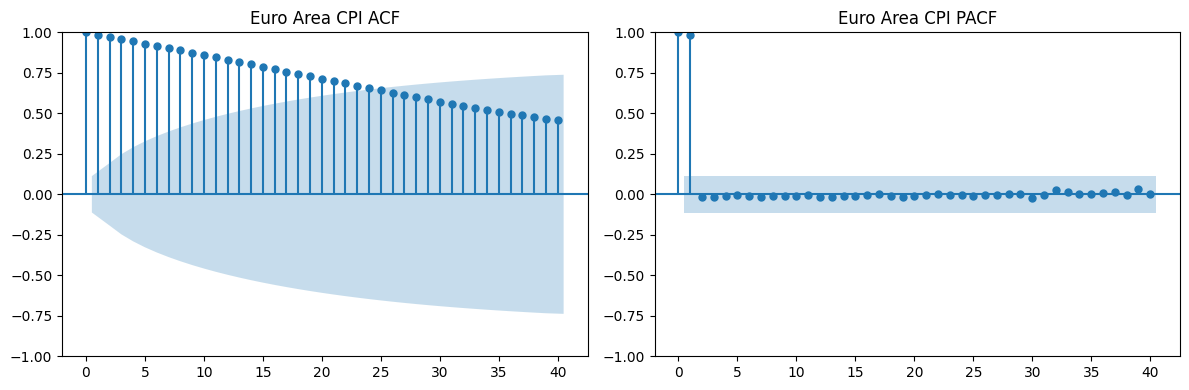

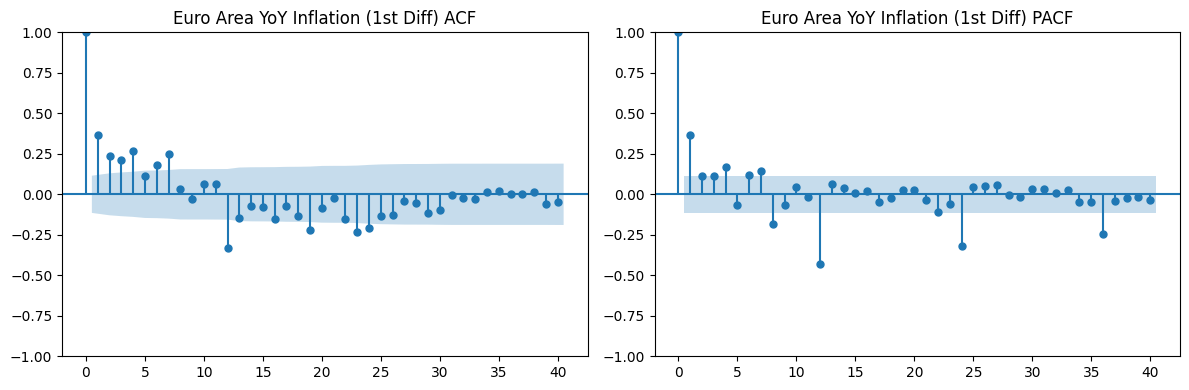

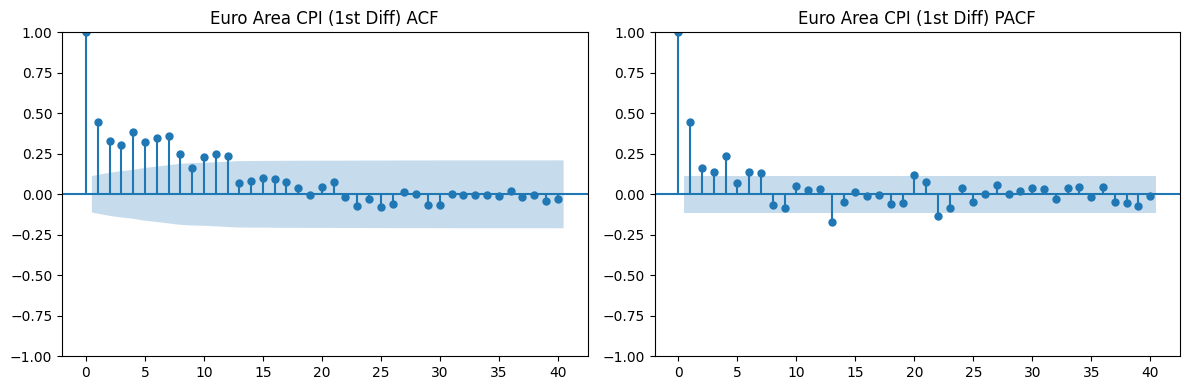

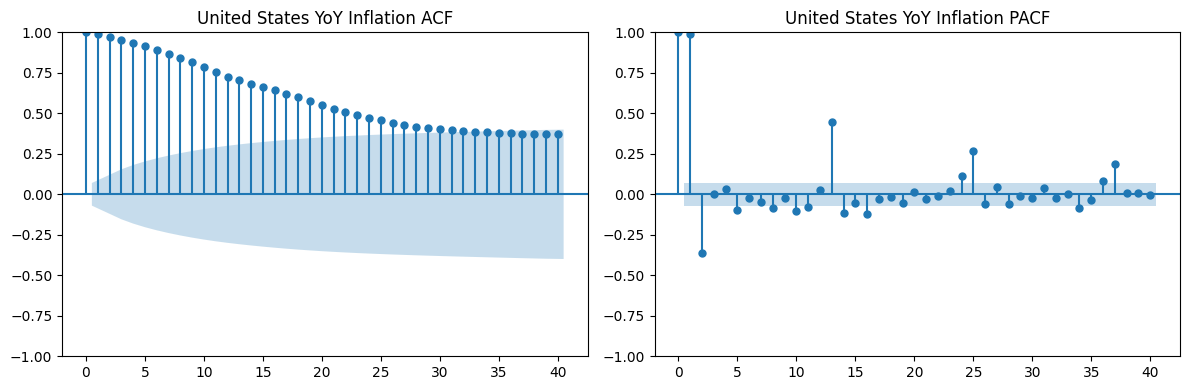

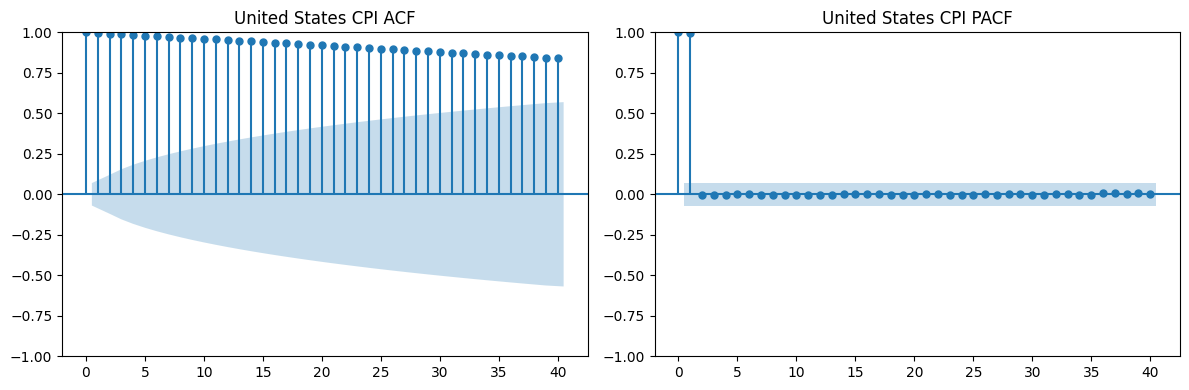

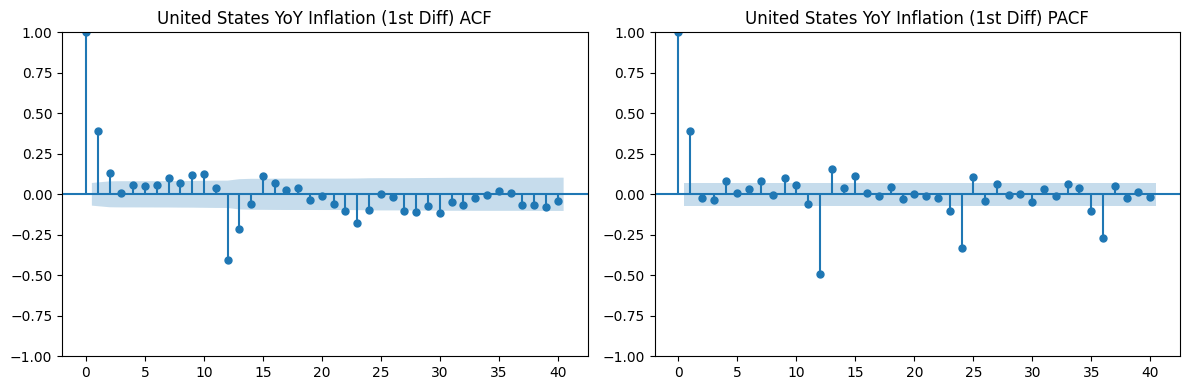

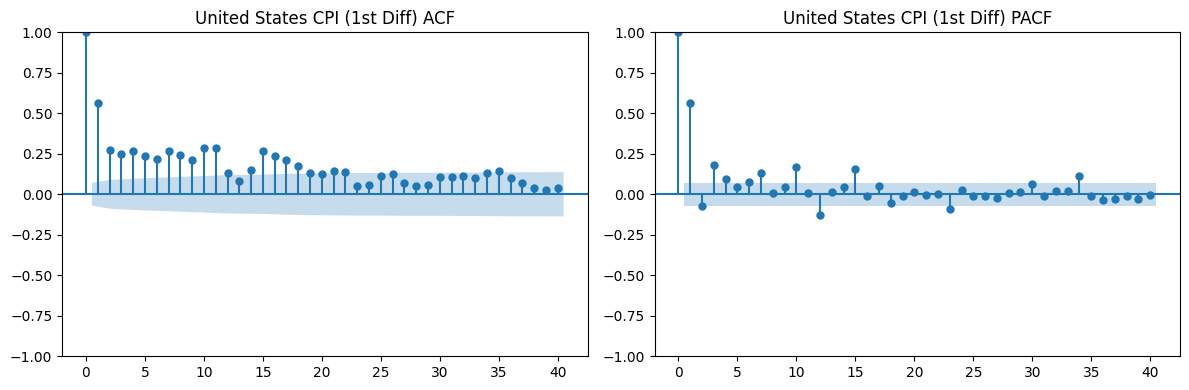

In [7]:
# Helper function to plot ACF and PACF
def plot_acf_pacf(ts, name, lags=40):
    """Plots the ACF and PACF for a given time series."""
    plt.figure(figsize=(12, 4))
    
    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(ts, lags=lags, ax=plt.gca(), title=f'{name} ACF')
    
    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(ts, lags=lags, ax=plt.gca(), title=f'{name} PACF')
    
    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for all original and differenced series
for key in series:
    # Original series
    plot_acf_pacf(series[key], f"{labels[key]} YoY Inflation")
    plot_acf_pacf(cpi_series[key], f"{labels[key]} CPI")
    
    # Differenced series
    plot_acf_pacf(diff_series[key], f"{labels[key]} YoY Inflation (1st Diff)")
    plot_acf_pacf(diff_cpi_series[key], f"{labels[key]} CPI (1st Diff)")

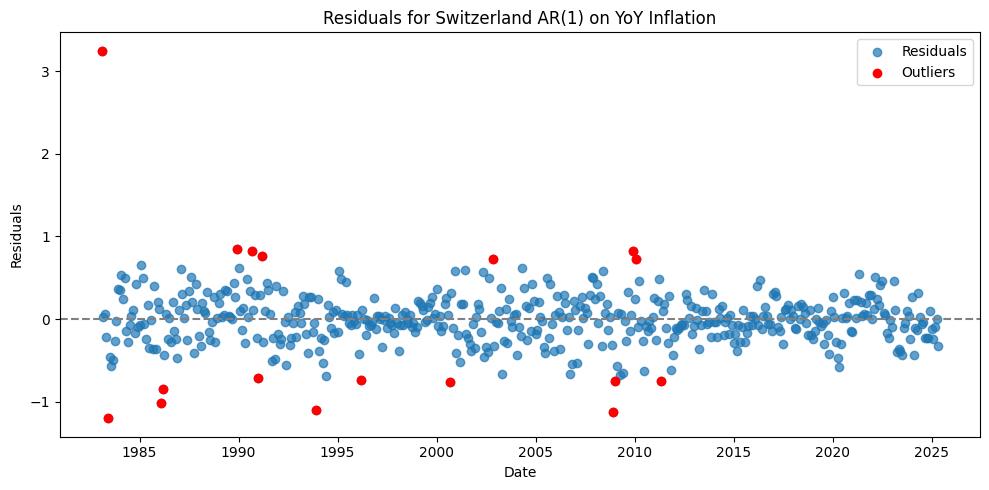

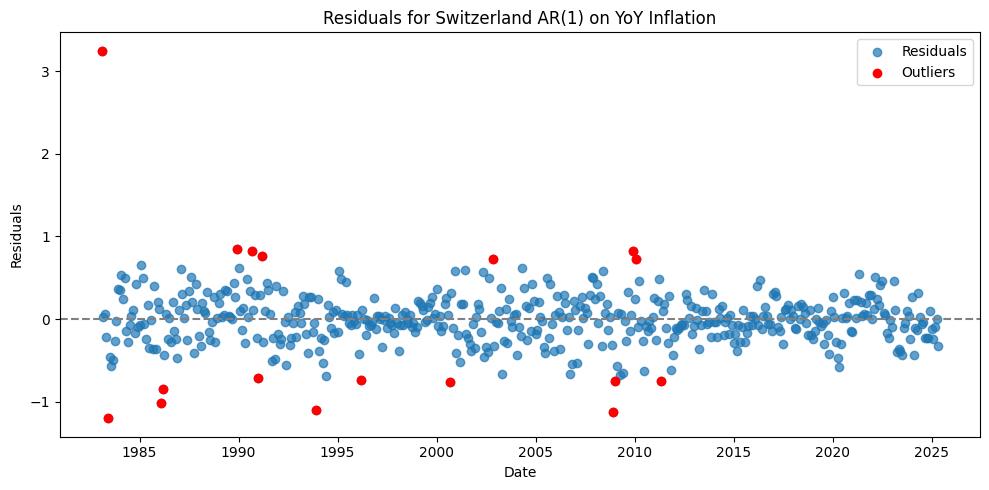

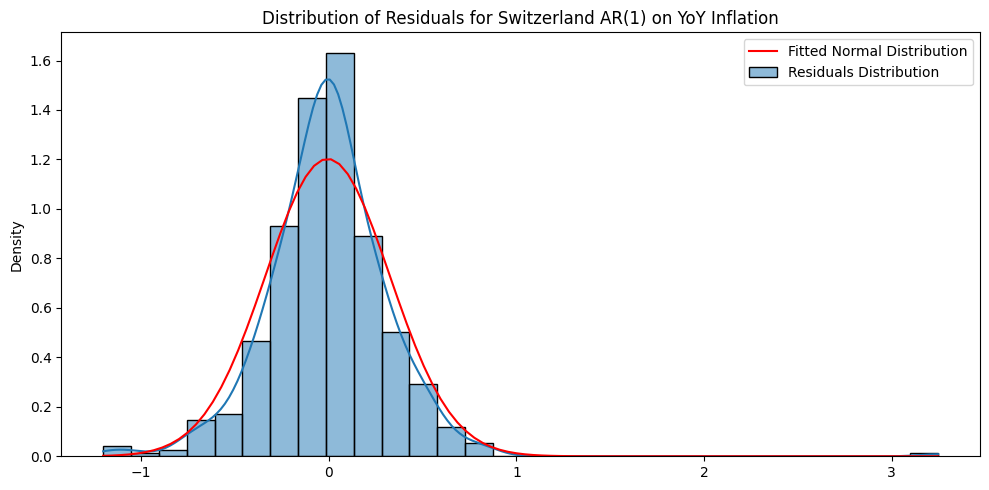

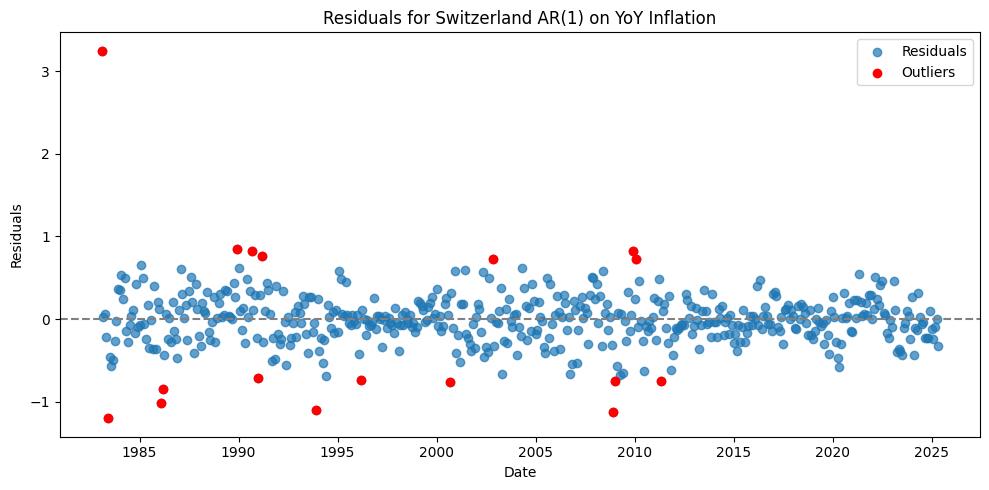

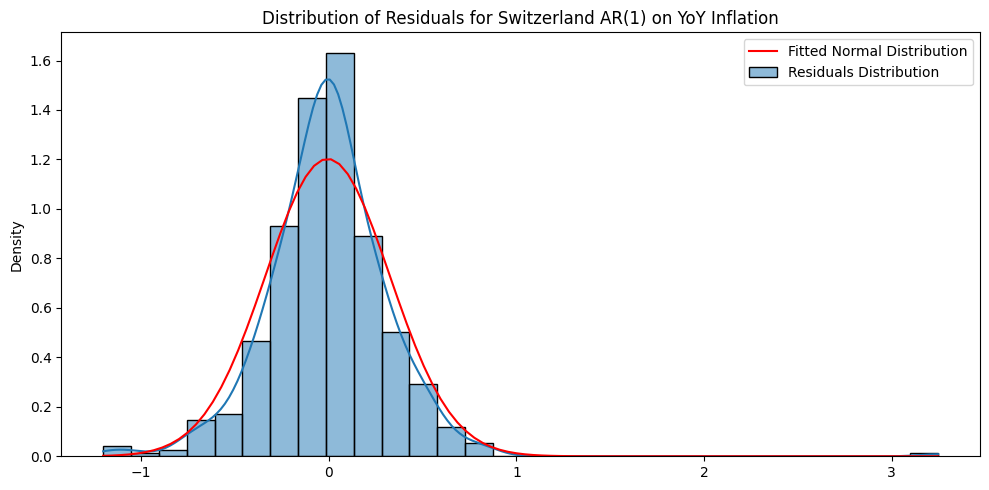

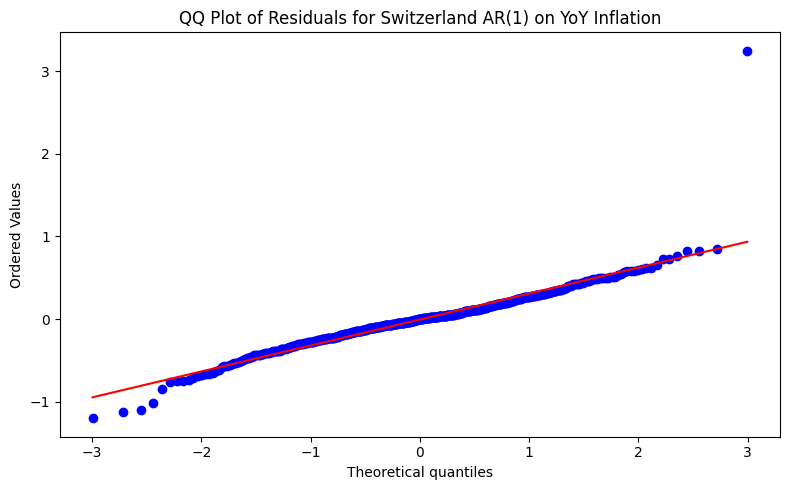

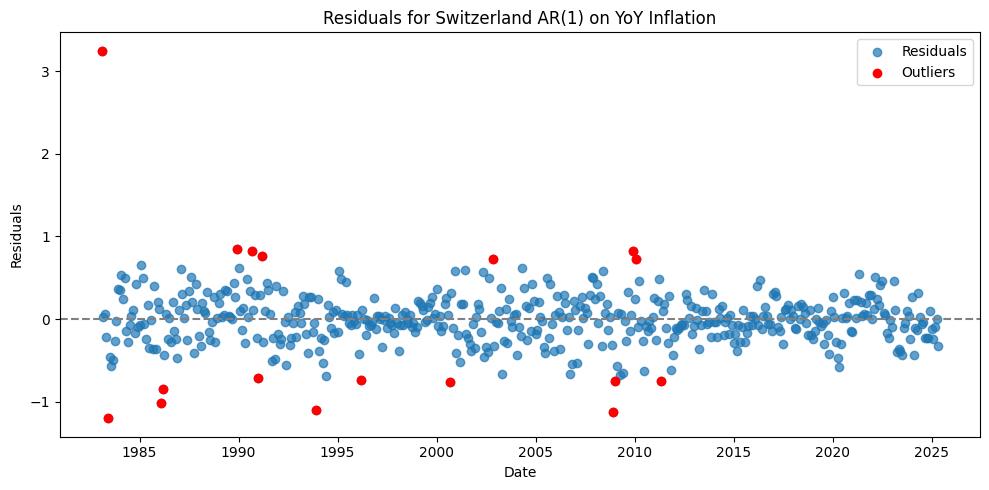

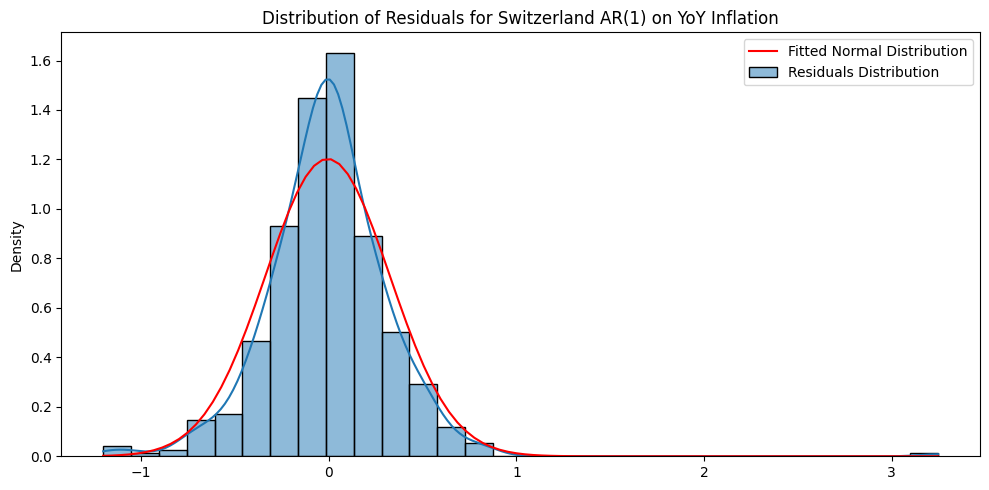

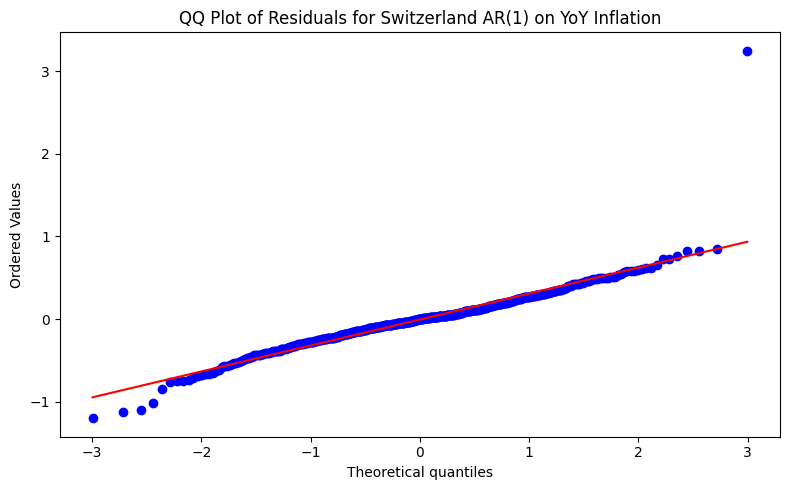

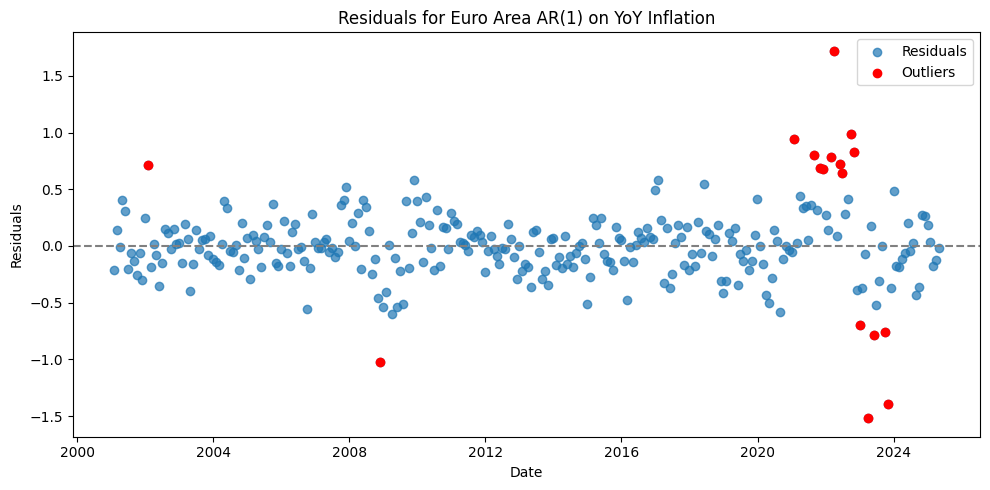

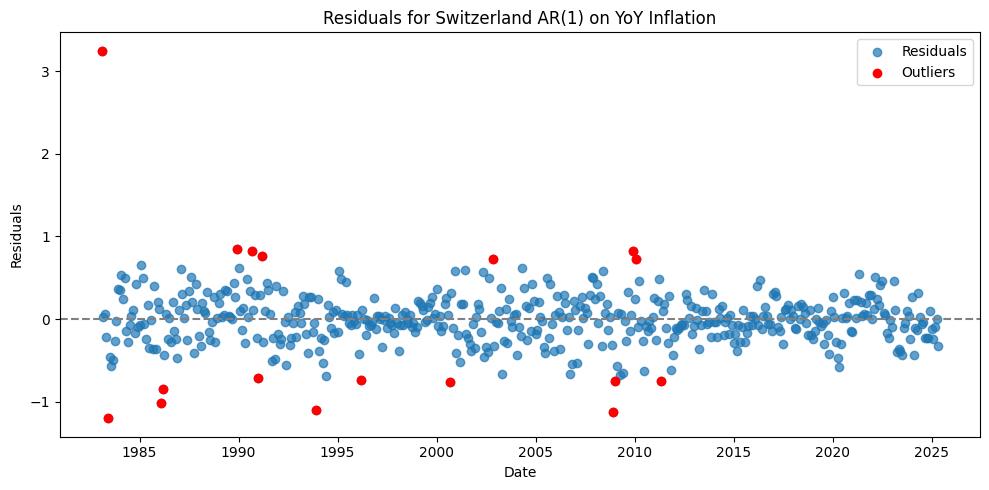

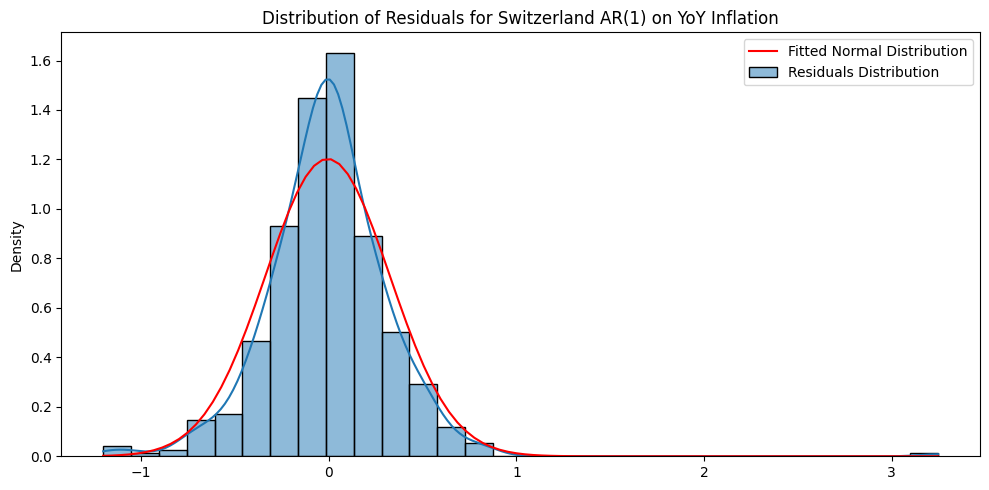

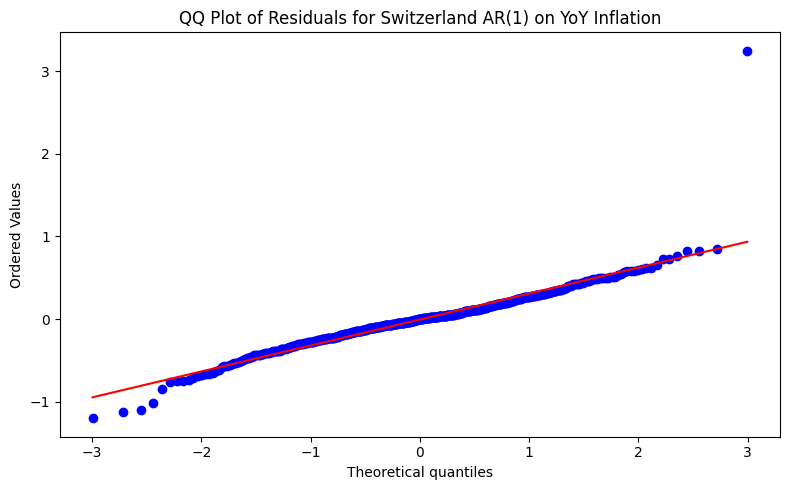

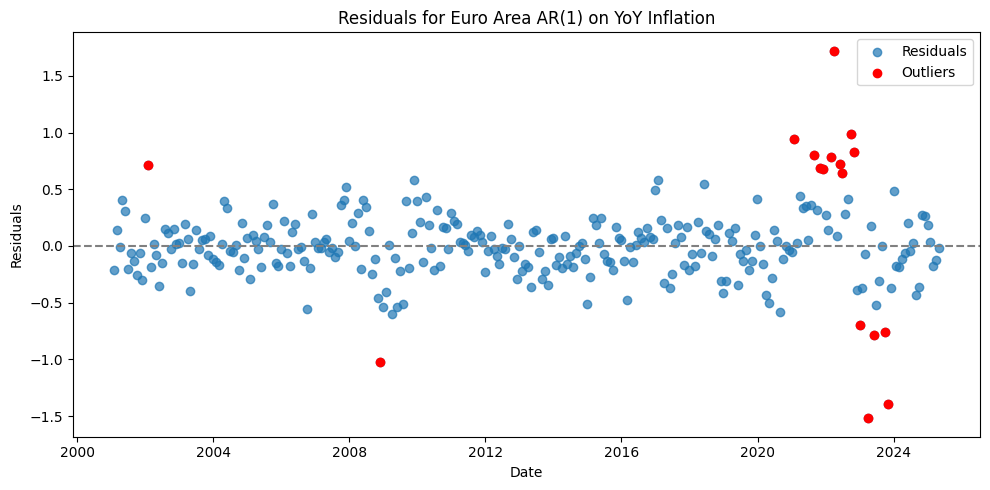

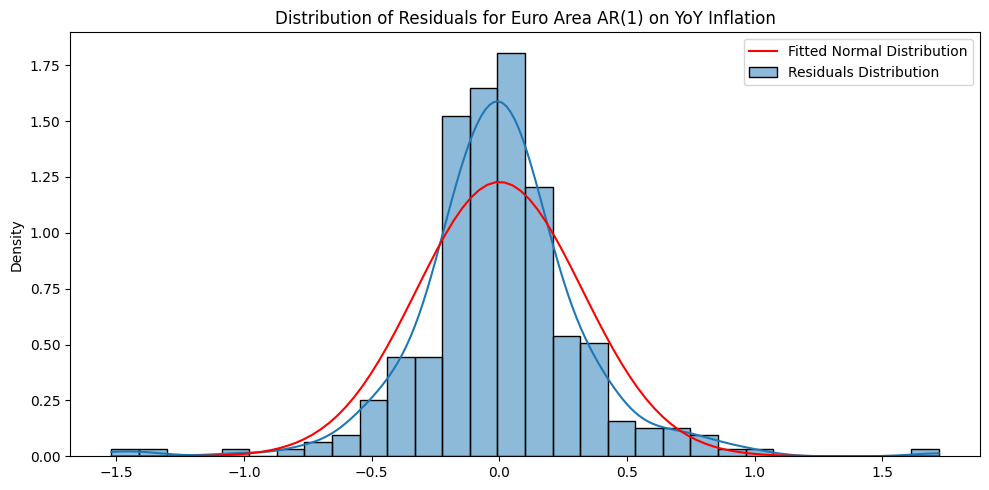

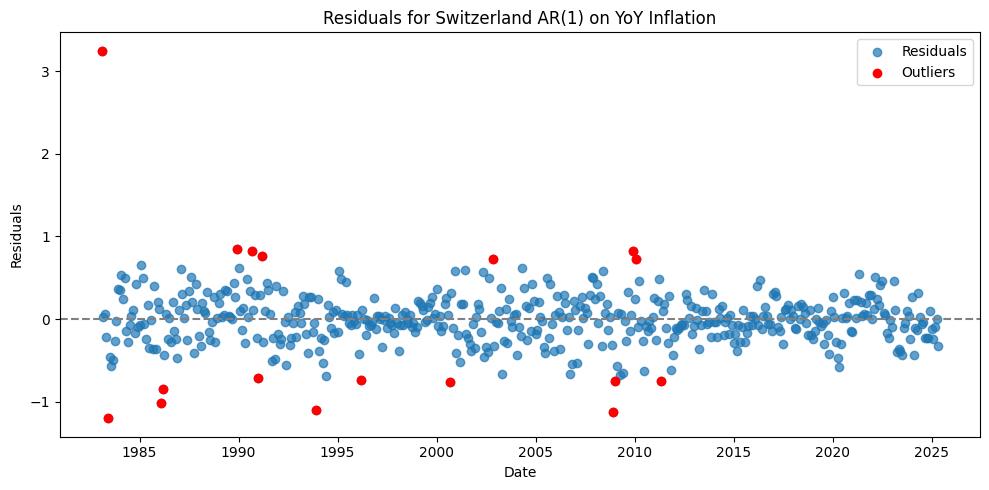

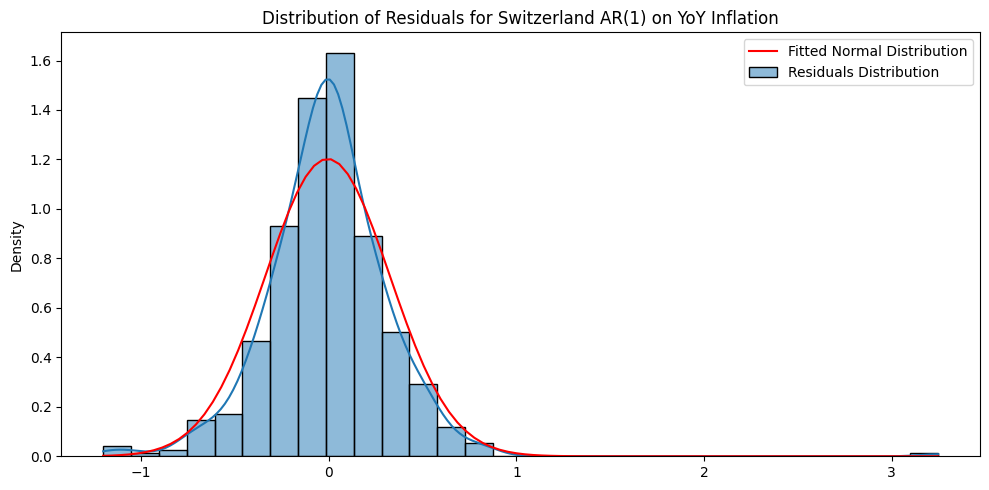

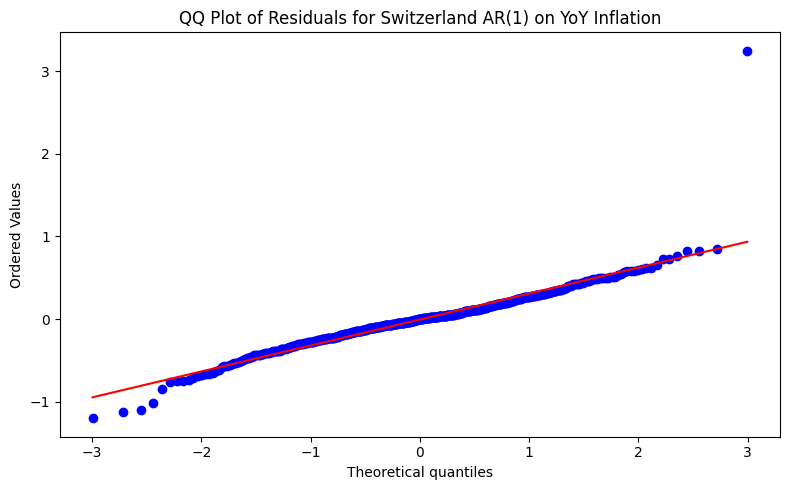

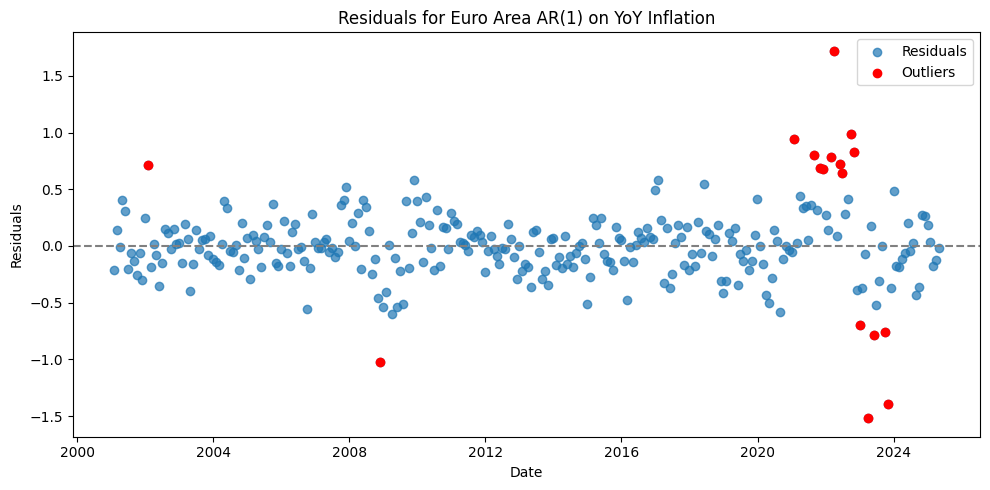

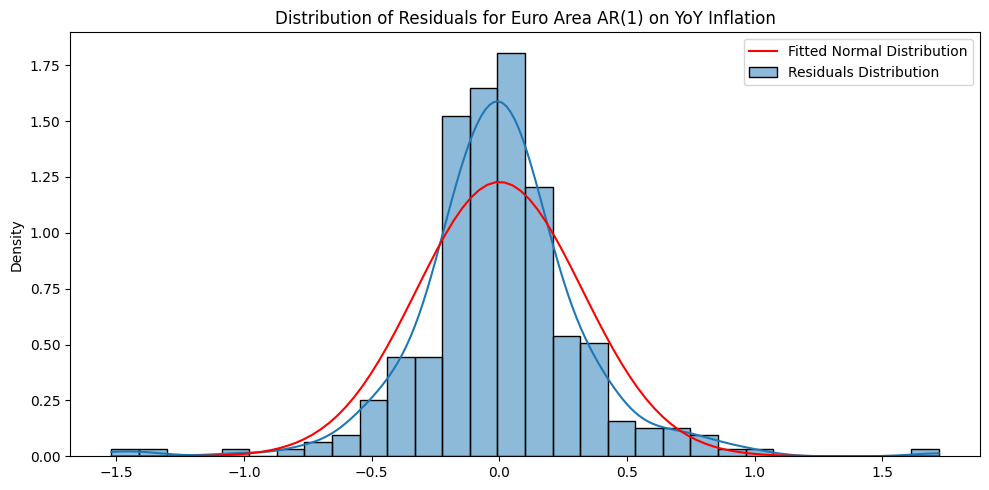

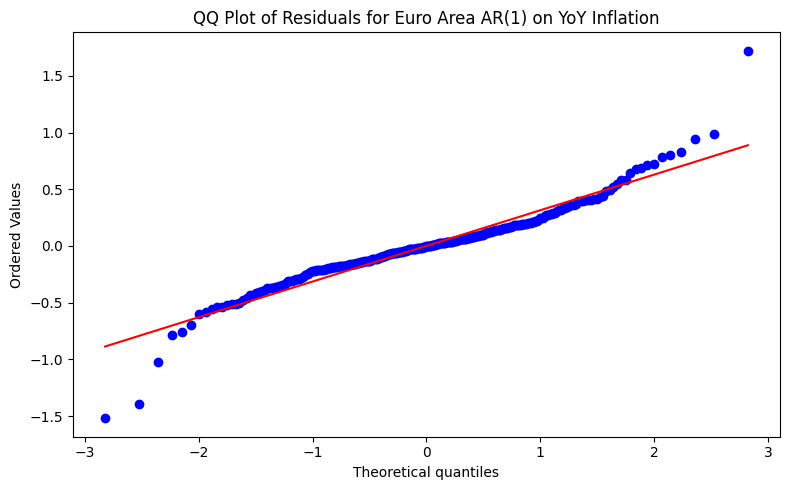

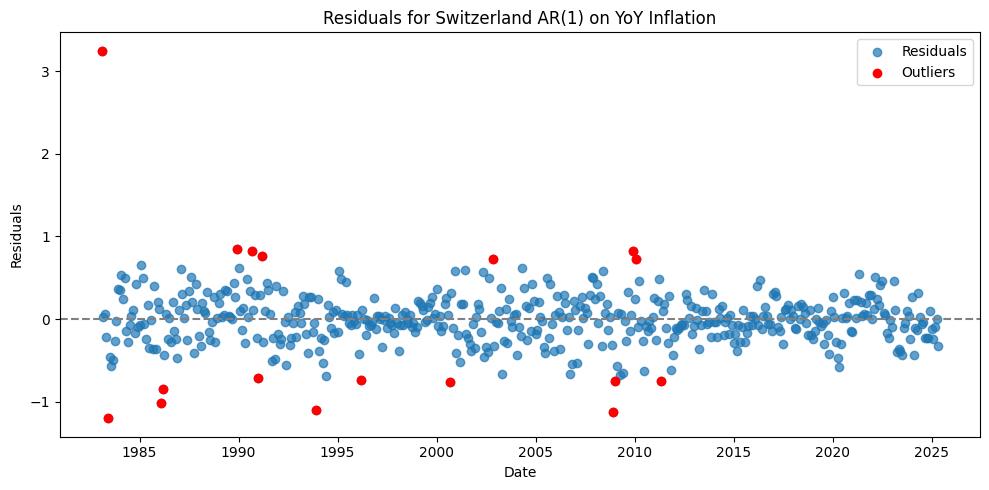

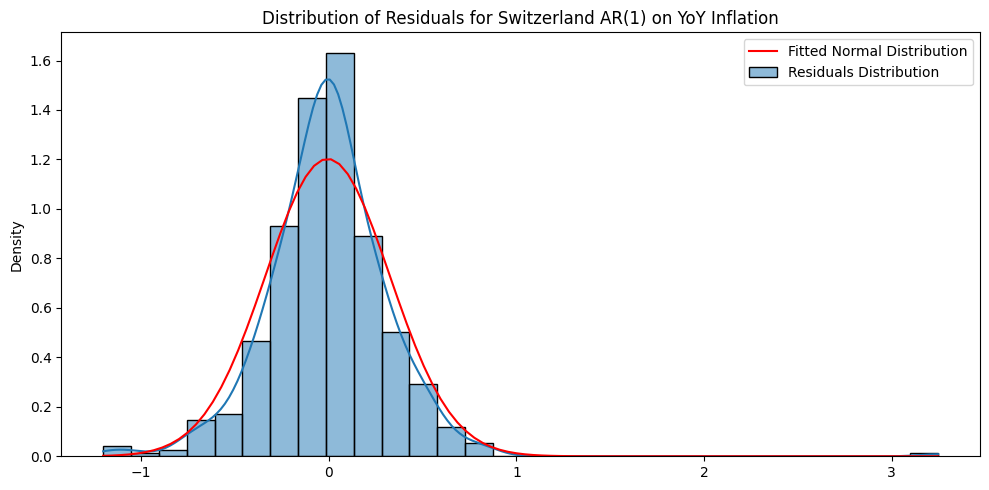

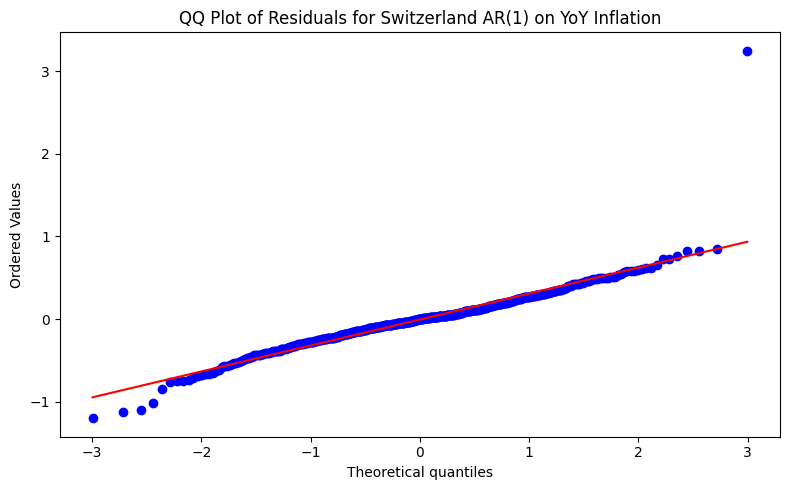

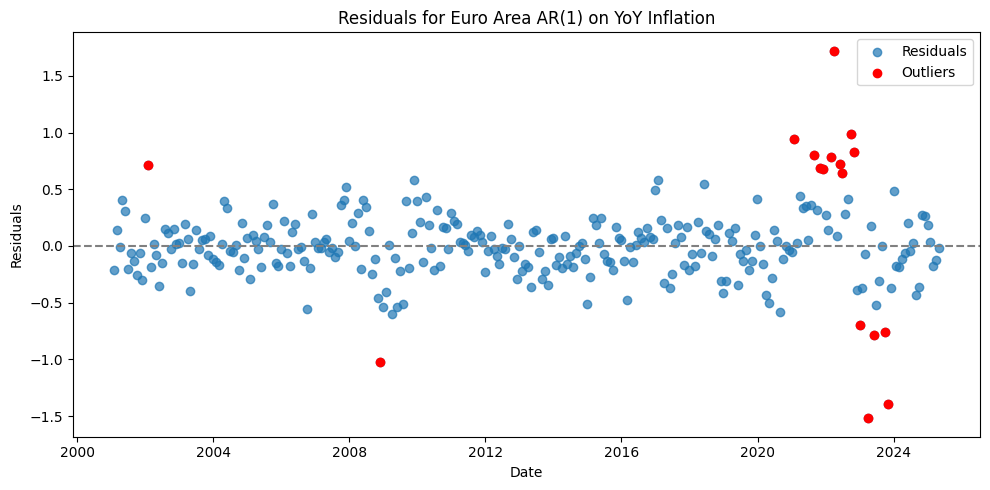

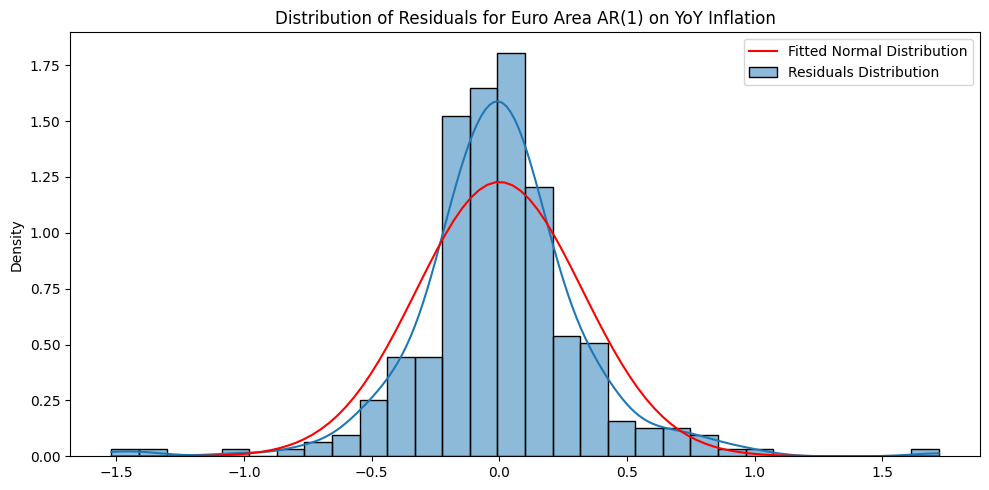

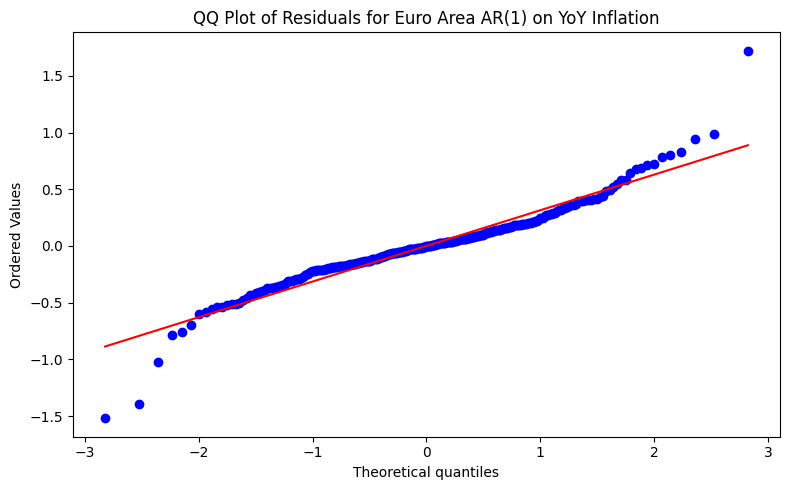

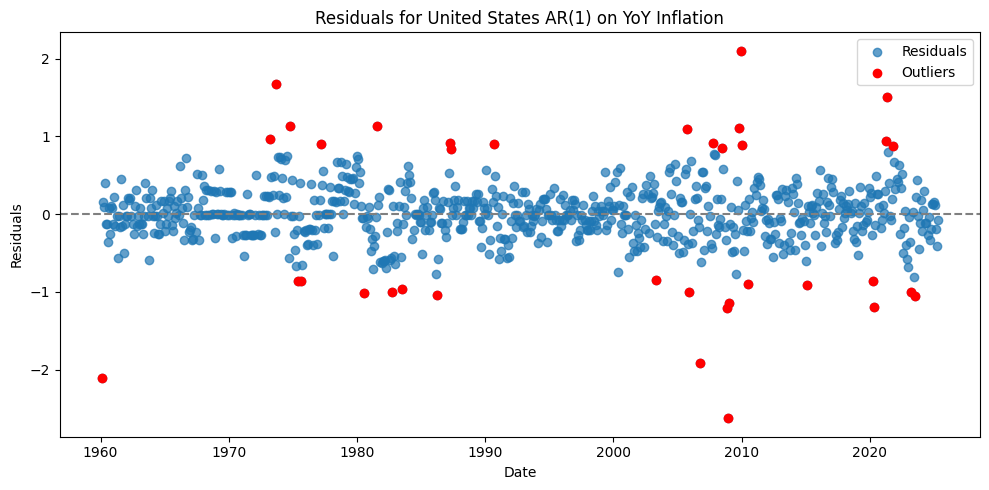

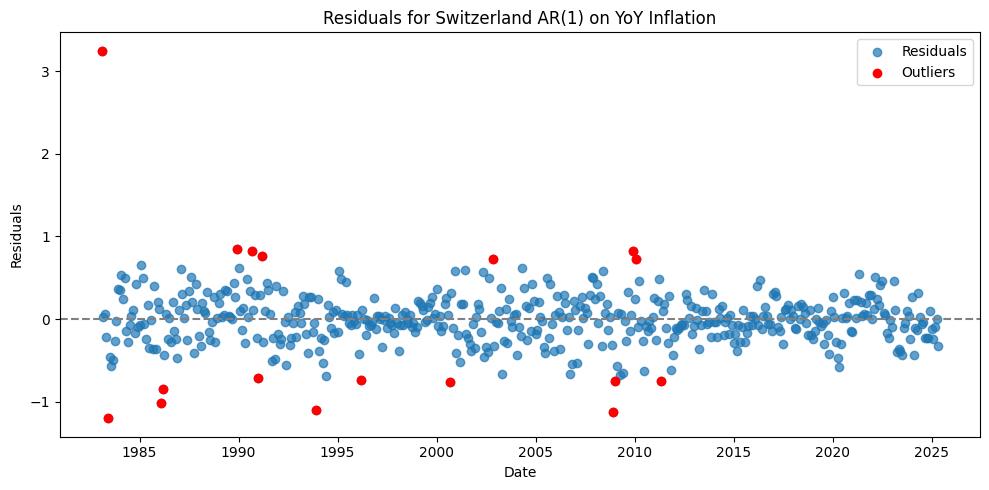

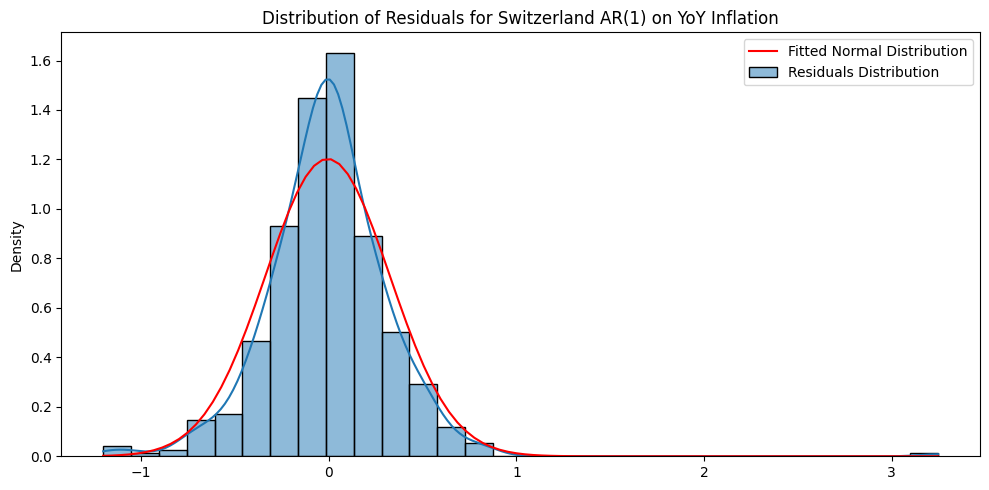

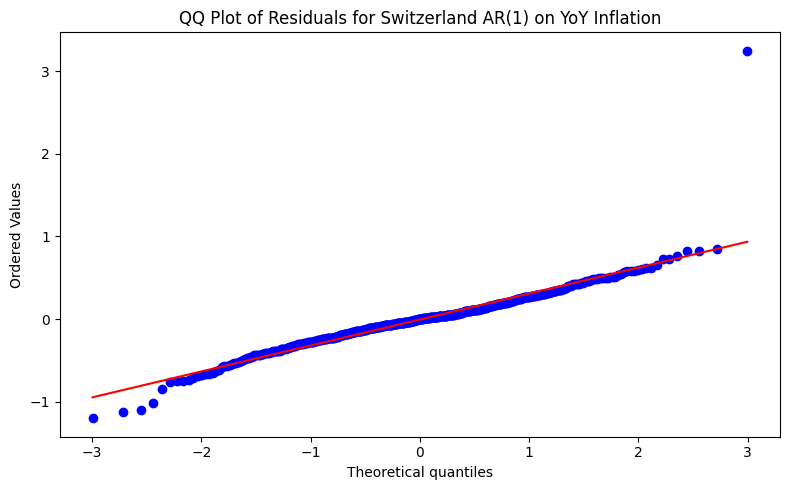

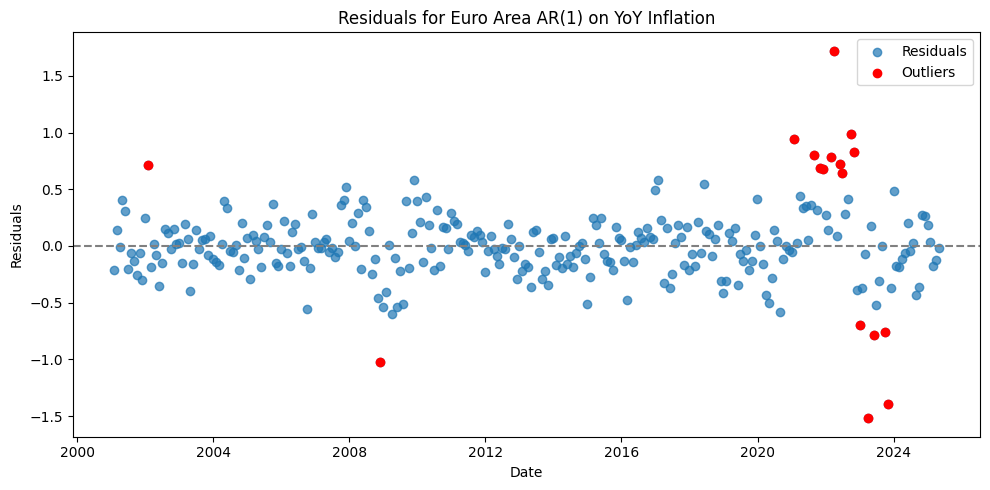

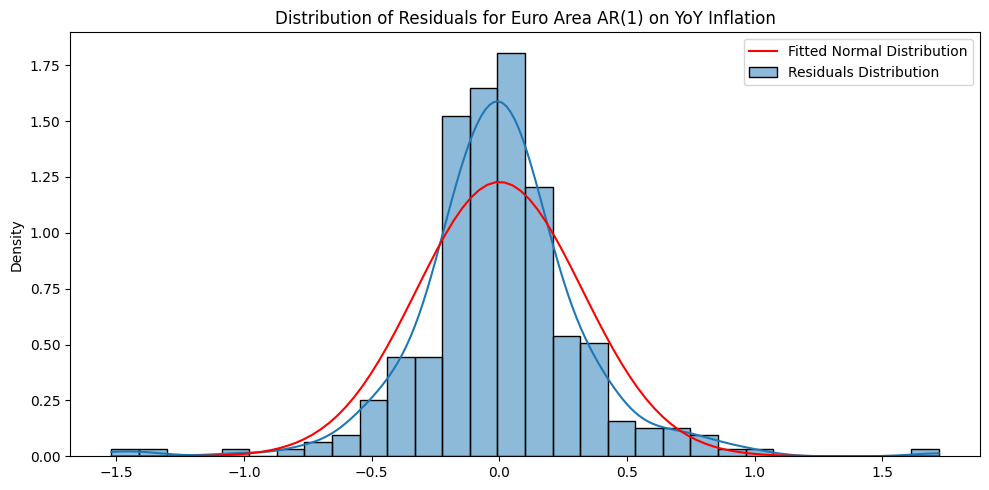

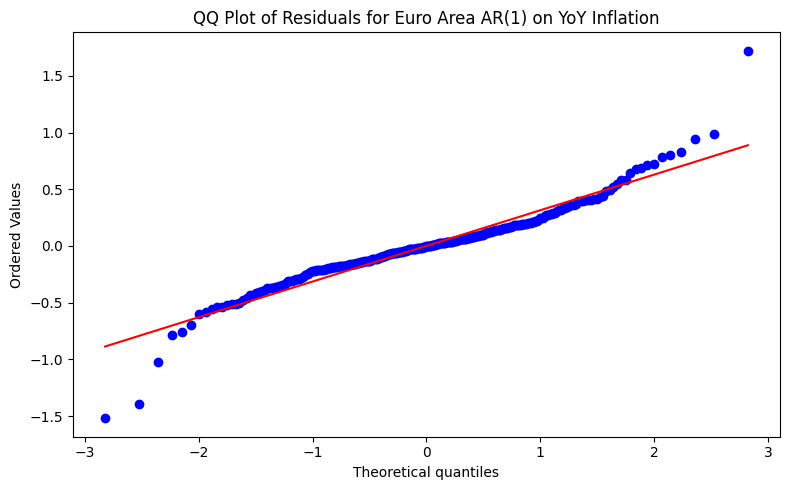

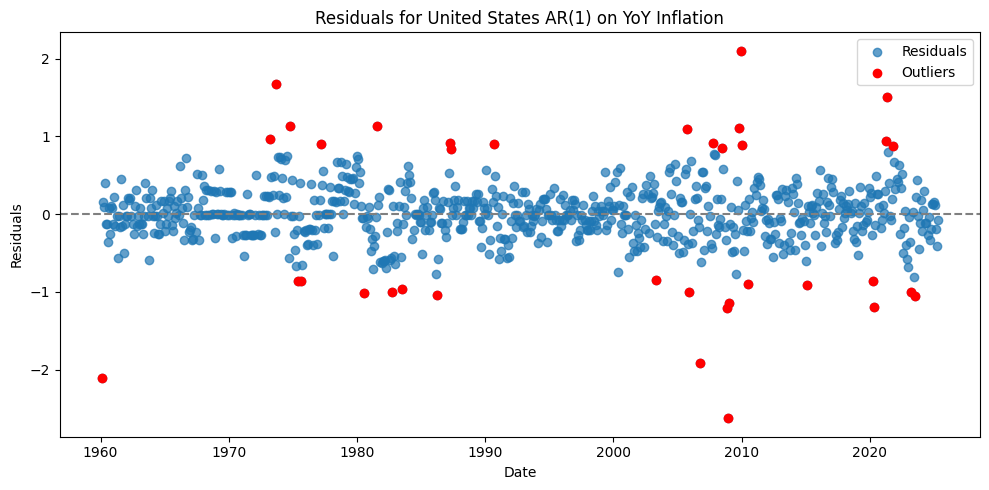

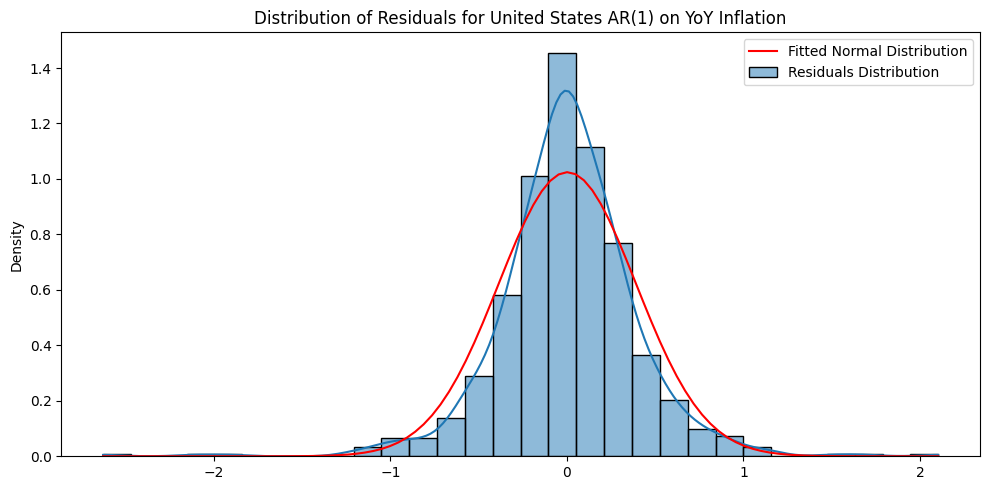

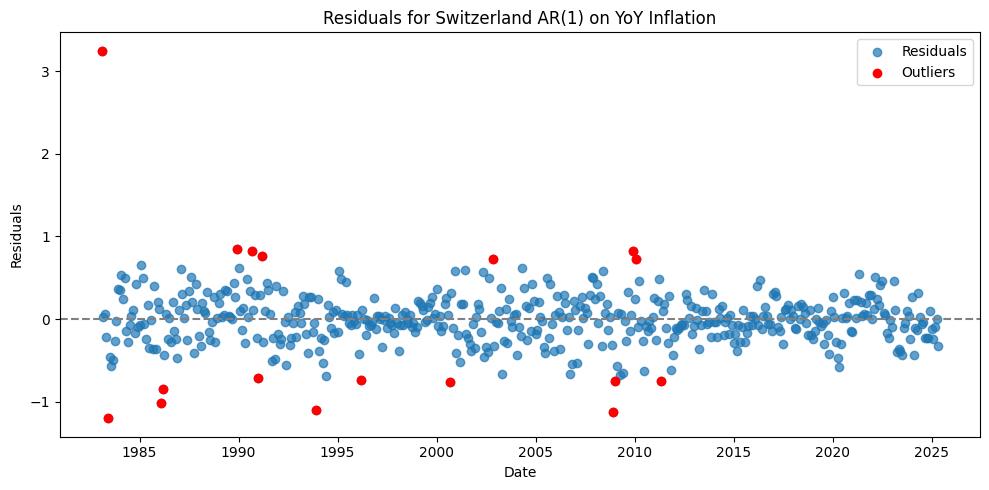

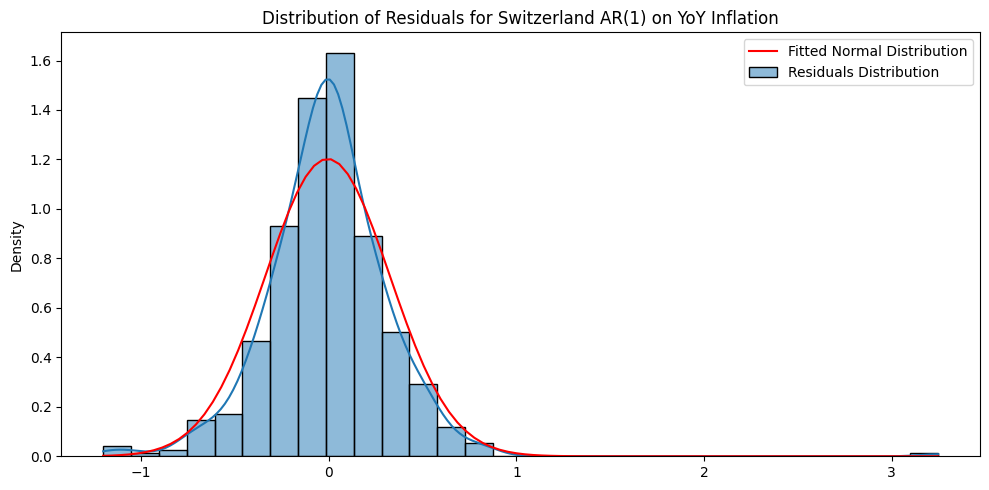

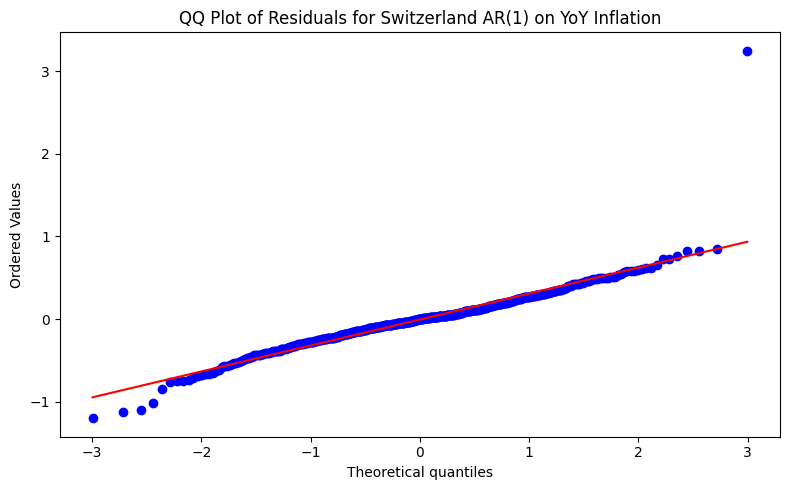

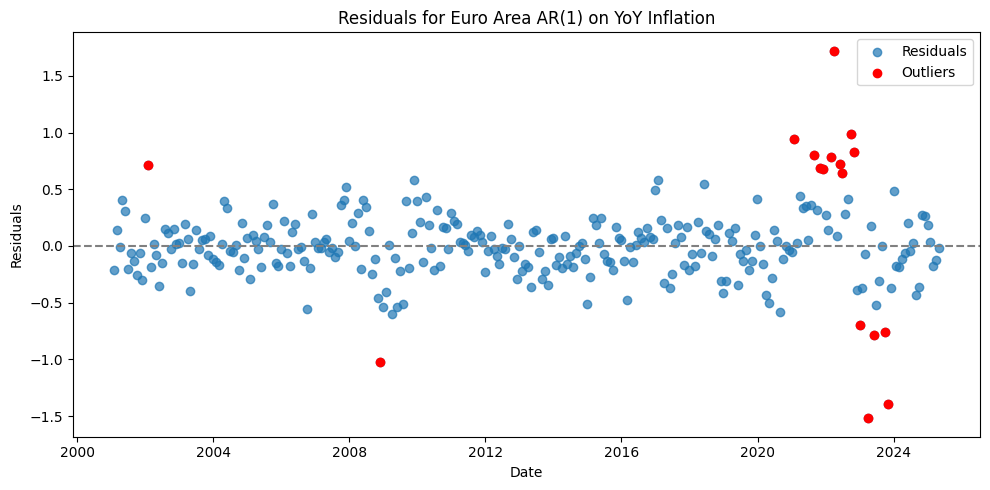

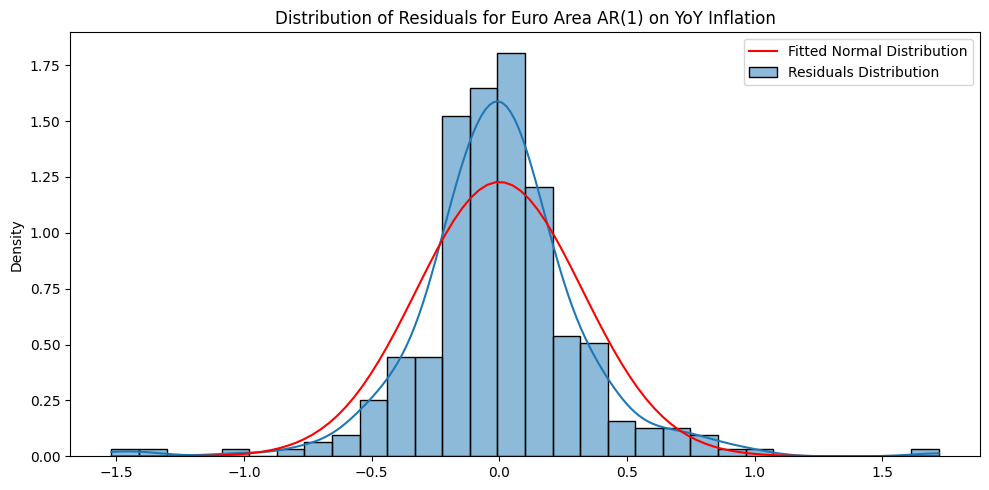

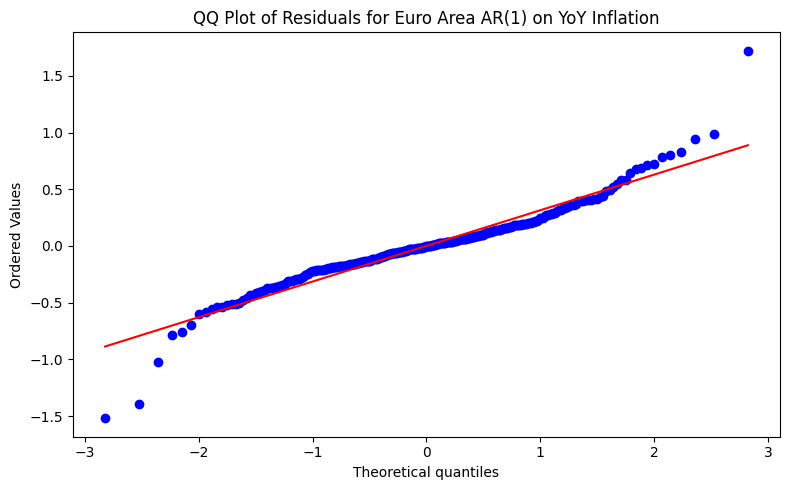

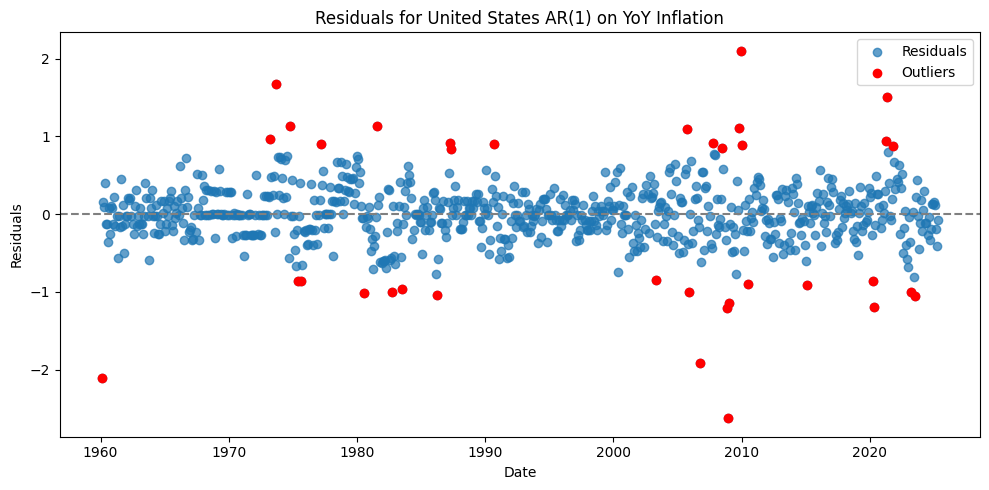

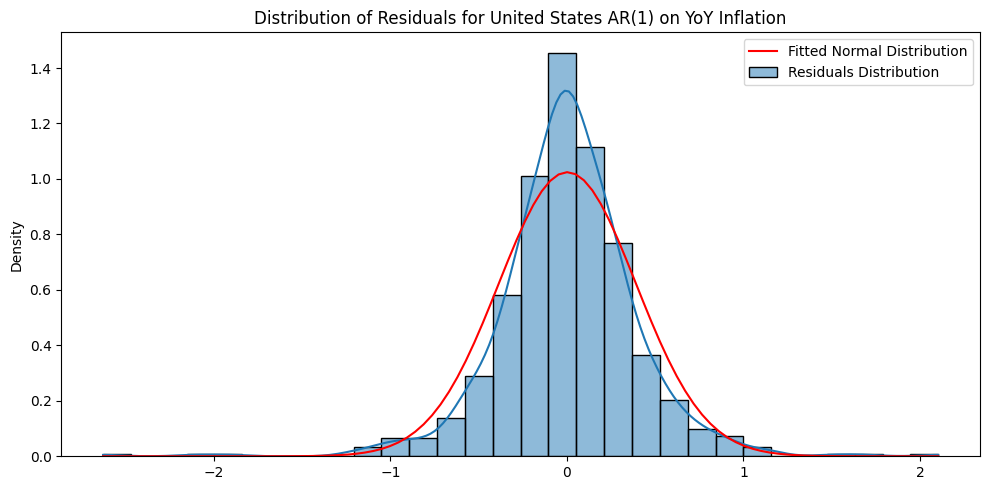

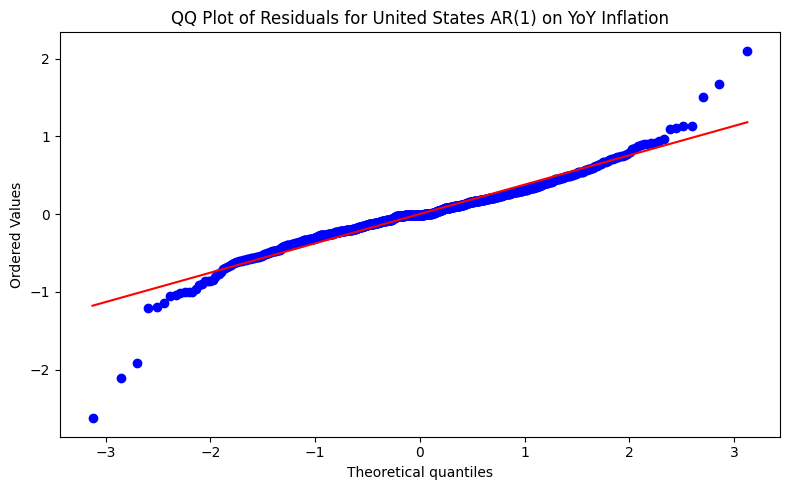

In [8]:
# Helper function for residual analysis
def analyze_residuals(ts, order, model_name):
    """Fits an ARIMA model and performs a comprehensive residual analysis."""
    # Fit model
    model = ARIMA(ts, order=order)
    result = model.fit()
    residuals = result.resid
    
    # --- Plot 1: Residuals over time with outliers ---
    Q1, Q3 = residuals.quantile(0.25), residuals.quantile(0.75)
    IQR = Q3 - Q1
    outliers = residuals[(residuals < Q1 - 1.5 * IQR) | (residuals > Q3 + 1.5 * IQR)]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(residuals.index, residuals, label="Residuals", alpha=0.7)
    plt.scatter(outliers.index, outliers, color="red", label="Outliers")
    plt.axhline(0, color="grey", linestyle="--")
    plt.title(f'Residuals for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Plot 2: Residuals distribution ---
    mean, std = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = norm.pdf(x, mean, std)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, label="Residuals Distribution", stat="density", bins=30)
    plt.plot(x, normal_dist, color="red", label="Fitted Normal Distribution")
    plt.title(f'Distribution of Residuals for {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Plot 3: QQ plot ---
    plt.figure(figsize=(8, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'QQ Plot of Residuals for {model_name}')
    plt.tight_layout()
    plt.show()

# --- Residual Analysis for AR(1) on Original YoY Inflation Series ---
for key in series:
    analyze_residuals(series[key], order=(1, 0, 0), model_name=f"{labels[key]} AR(1) on YoY Inflation")

In [9]:
# Apply auto_arima to both YoY inflation and CPI series
auto_arima_results = {}
auto_arima_cpi_results = {}

for key in series:
    # Auto ARIMA for YoY inflation
    print(f"Auto ARIMA for {labels[key]} YoY Inflation:")
    model_inflation = auto_arima(
        series[key],
        start_p=1,  # Initial value for p
        start_q=1,  # Initial value for q
        max_p=5,    # Maximum p value
        max_q=5,    # Maximum q value
        max_d=2,    # Maximum d value
        seasonal=False,  # Set to True if the data has seasonality
        stepwise=True,   # Use stepwise search to reduce computation time
        trace=True,      # Print the model selection process
        max_order=10,    # Limit the maximum p, d, q values
        information_criterion='bic',
    )
    auto_arima_results[key] = model_inflation
    print(model_inflation.summary())
    
    # Auto ARIMA for CPI series
    print(f"Auto ARIMA for {labels[key]} CPI Column:")
    model_cpi = auto_arima(
        cpi_series[key],
        start_p=1,  # Initial value for p
        start_q=1,  # Initial value for q
        max_p=5,    # Maximum p value
        max_q=5,    # Maximum q value
        max_d=2,    # Maximum d value
        seasonal=False,  # Set to True if the data has seasonality
        stepwise=True,   # Use stepwise search to reduce computation time
        trace=True,      # Print the model selection process
        max_order=10,    # Limit the maximum p, d, q values
        information_criterion='bic',
    )
    auto_arima_cpi_results[key] = model_cpi
    print(model_cpi.summary())

Auto ARIMA for Switzerland YoY Inflation:
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=222.756, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=231.726, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=220.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=223.831, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=225.992, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=221.900, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=220.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=223.831, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=225.992, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=221.900, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=224.605, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=214.635, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=215.965, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=216.811, Time=0.05 sec
 ARIM

## Auto ARIMA: Rolling Order Selection Analysis

In this section, we perform a rolling `auto_arima` fit for each region. This is computationally intensive. The primary goal is to analyze how the optimal model order, as selected by the BIC, changes over time. This provides insight into the stability of the time-series process.

In [11]:
regions = ["ch", "eu", "us"]
results = {}

for region in regions:
    df = series[region]
    model_orders = []
    
    # Use the 40% split as the start of the rolling window
    start_date = split_dates[region][1]
    
    # Use tqdm for a progress bar
    forecast_range = df.index[df.index.get_loc(start_date):]
    
    print(f"\n--- Running Rolling Auto ARIMA for {labels[region]} ---")
    for cutoff_date in tqdm(forecast_range):
        train_series = df[:cutoff_date]
        
        try:
            model = auto_arima(
                train_series,
                start_p=1, start_q=1, max_p=5, max_q=5, max_d=2,
                seasonal=False, stepwise=False, trace=False,
                error_action='ignore', suppress_warnings=True,
                information_criterion="bic"
            )
            
            model_order_str = f"ARIMA{model.order}"
            
            model_orders.append({
                "cutoff": cutoff_date,
                "model_order": model_order_str,
            })
        except Exception as e:
            print(f"Error for {region} at {cutoff_date}: {e}")

    # Store results in a DataFrame
    model_order_df = pd.DataFrame(model_orders)
    results[region] = model_order_df
    
    print(f"Finished model order analysis for {region}")


--- Running Rolling Auto ARIMA for Switzerland ---


100%|██████████| 305/305 [20:22<00:00,  4.01s/it]


Finished model order analysis for ch

--- Running Rolling Auto ARIMA for Euro Area ---


100%|██████████| 176/176 [08:59<00:00,  3.06s/it]


Finished model order analysis for eu

--- Running Rolling Auto ARIMA for United States ---


100%|██████████| 471/471 [52:01<00:00,  6.63s/it]  

Finished model order analysis for us



--- Generating Model Selection Plots ---


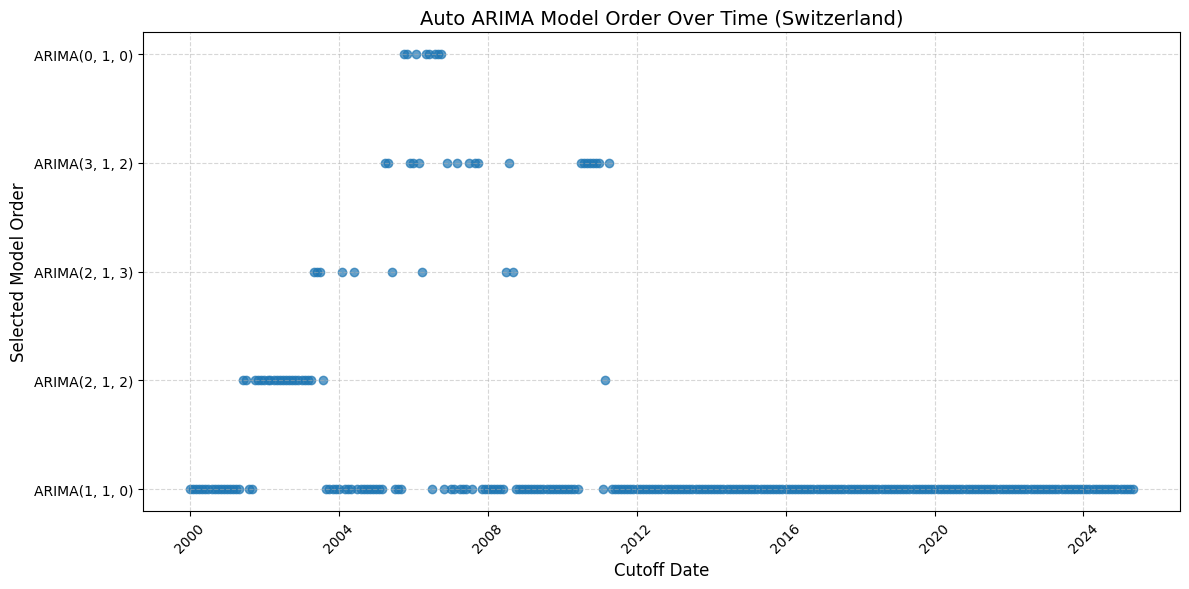

--- Model Selection Frequencies for Switzerland ---
model_order
ARIMA(1, 1, 0)    80.66
ARIMA(2, 1, 2)     7.54
ARIMA(3, 1, 2)     6.23
ARIMA(2, 1, 3)     2.95
ARIMA(0, 1, 0)     2.62
Name: proportion, dtype: float64
--------------------------------------------------


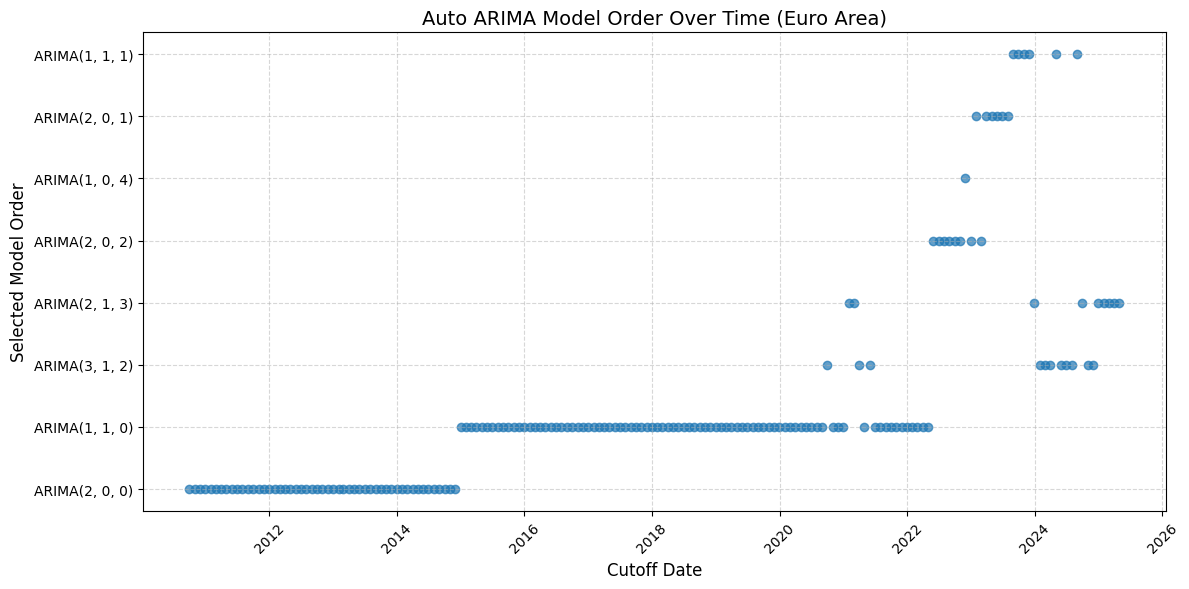

--- Model Selection Frequencies for Euro Area ---
model_order
ARIMA(1, 1, 0)    47.73
ARIMA(2, 0, 0)    28.98
ARIMA(3, 1, 2)     6.25
ARIMA(2, 1, 3)     5.11
ARIMA(2, 0, 2)     4.55
ARIMA(1, 1, 1)     3.41
ARIMA(2, 0, 1)     3.41
ARIMA(1, 0, 4)     0.57
Name: proportion, dtype: float64
--------------------------------------------------


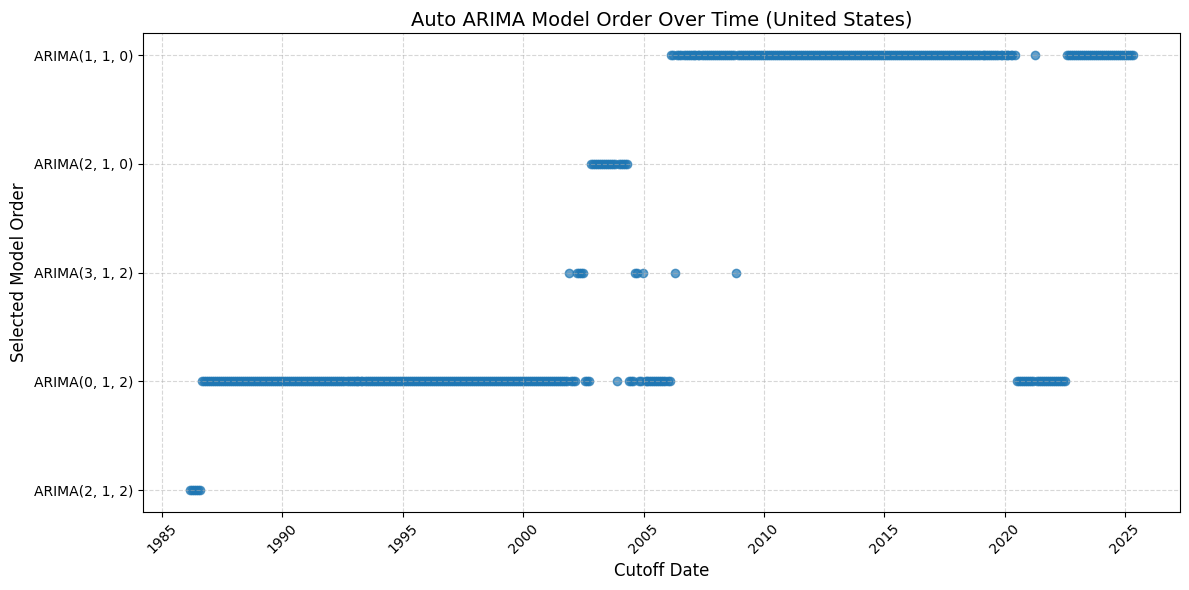

--- Model Selection Frequencies for United States ---
model_order
ARIMA(0, 1, 2)    49.26
ARIMA(1, 1, 0)    43.52
ARIMA(2, 1, 0)     3.82
ARIMA(3, 1, 2)     2.12
ARIMA(2, 1, 2)     1.27
Name: proportion, dtype: float64
--------------------------------------------------


In [12]:
print("\n--- Generating Model Selection Plots ---")

for region in regions:
    # Load the results we just generated
    model_order_df = results[region].copy()
    
    # Ensure 'model_order' is a categorical variable for plotting
    model_order_df["model_order"] = pd.Categorical(model_order_df["model_order"])

    # --- Plot 1: Model Order Over Time ---
    plt.figure(figsize=(12, 6))
    plt.scatter(model_order_df["cutoff"], model_order_df["model_order"], alpha=0.7)
    plt.title(f"Auto ARIMA Model Order Over Time ({labels[region]})", fontsize=14)
    plt.xlabel("Cutoff Date", fontsize=12)
    plt.ylabel("Selected Model Order", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Analysis 2: Frequency of Selected Models ---
    print(f"--- Model Selection Frequencies for {labels[region]} ---")
    total_counts = model_order_df['model_order'].value_counts(normalize=True).mul(100).round(2)
    print(total_counts)
    print("-" * 50)